In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/UROLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 8 questions
Page 1, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=213.4, y1=135.6
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 699
Page 1, Q1, A: Yellow percentage: 0.0%


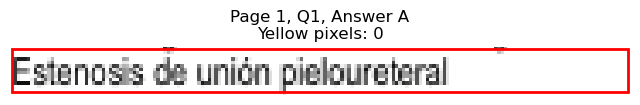

Page 1, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=219.9, y1=148.2
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 694
Page 1, Q1, B: Yellow percentage: 0.0%


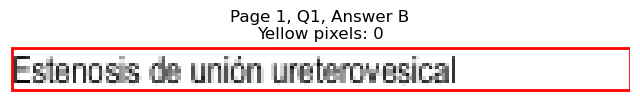

Page 1, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=219.4, y1=160.9
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 706
Page 1, Q1, C: Yellow percentage: 0.0%


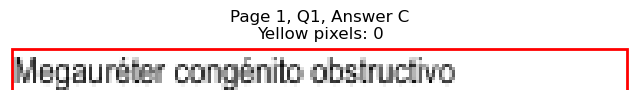

Page 1, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=455.9, y1=135.6
Page 1, Q1, D: Yellow pixels: 1741
Page 1, Q1, D: Total non-white pixels: 2408
Page 1, Q1, D: Yellow percentage: 72.3%


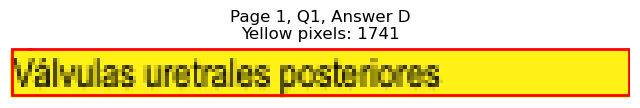

Page 1, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=450.5, y1=148.2
Page 1, Q1, E: Yellow pixels: 167
Page 1, Q1, E: Total non-white pixels: 776
Page 1, Q1, E: Yellow percentage: 21.5%


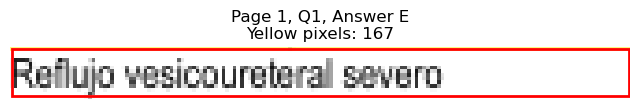


Page 1, Q1 - Selected Answer: D (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=168.3, y1=198.7
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 508
Page 1, Q2, A: Yellow percentage: 0.0%


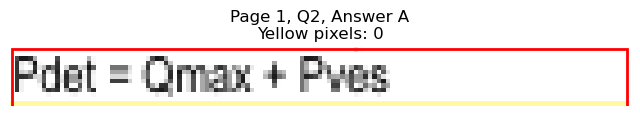

Page 1, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=163.0, y1=211.3
Page 1, Q2, B: Yellow pixels: 1320
Page 1, Q2, B: Total non-white pixels: 1834
Page 1, Q2, B: Yellow percentage: 72.0%


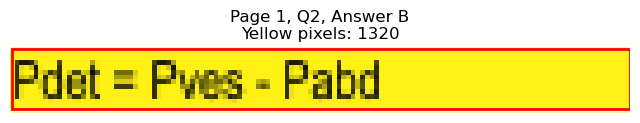

Page 1, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=165.7, y1=224.0
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 511
Page 1, Q2, C: Yellow percentage: 0.0%


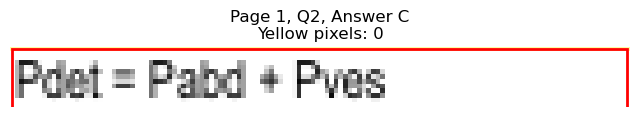

Page 1, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=419.1, y1=198.7
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 367
Page 1, Q2, D: Yellow percentage: 0.0%


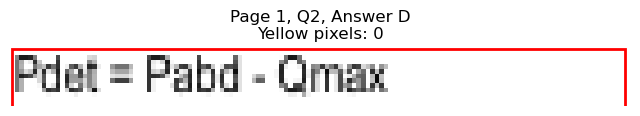

Page 1, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=414.8, y1=211.3
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 358
Page 1, Q2, E: Yellow percentage: 0.0%


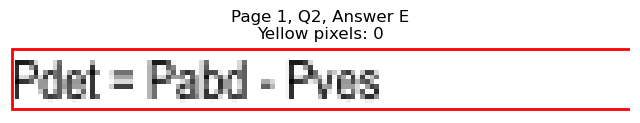


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.5, y0=249.1, x1=275.3, y1=261.8
Page 1, Q3, A: Yellow pixels: 1815
Page 1, Q3, A: Total non-white pixels: 2528
Page 1, Q3, A: Yellow percentage: 71.8%


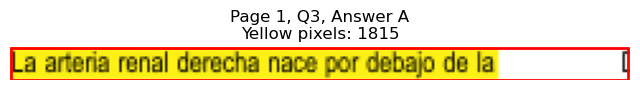

Page 1, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=275.2, y1=287.1
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 902
Page 1, Q3, B: Yellow percentage: 0.0%


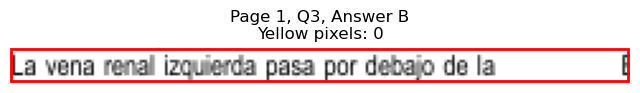

Page 1, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=275.3, y1=312.3
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 914
Page 1, Q3, C: Yellow percentage: 0.0%


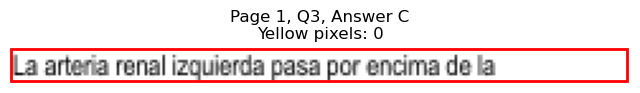

Page 1, Q3 - D: Detected box: x0=334.6, y0=249.1, x1=527.0, y1=261.8
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 827
Page 1, Q3, D: Yellow percentage: 0.0%


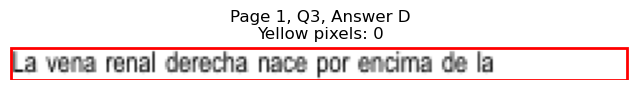

Page 1, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=527.0, y1=287.1
Page 1, Q3, E: Yellow pixels: 0
Page 1, Q3, E: Total non-white pixels: 845
Page 1, Q3, E: Yellow percentage: 0.0%


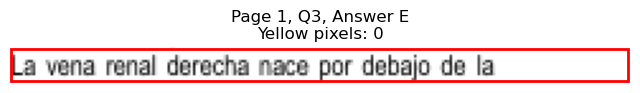


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.5, y0=350.2, x1=130.6, y1=362.9
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 266
Page 1, Q4, A: Yellow percentage: 0.0%


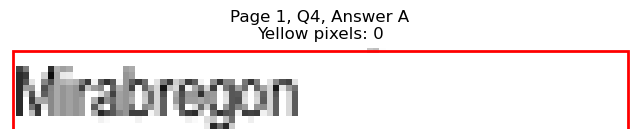

Page 1, Q4 - B: Detected box: x0=82.5, y0=362.8, x1=130.1, y1=375.5
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 237
Page 1, Q4, B: Yellow percentage: 0.0%


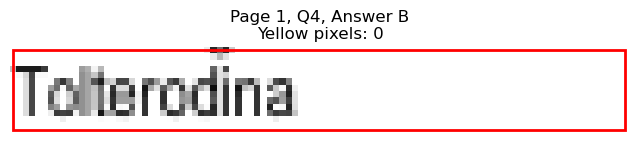

Page 1, Q4 - C: Detected box: x0=82.9, y0=375.4, x1=136.6, y1=388.1
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 256
Page 1, Q4, C: Yellow percentage: 0.0%


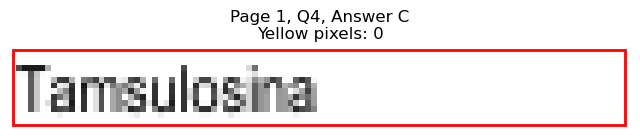

Page 1, Q4 - D: Detected box: x0=334.6, y0=350.2, x1=376.3, y1=362.9
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 294
Page 1, Q4, D: Yellow percentage: 0.0%


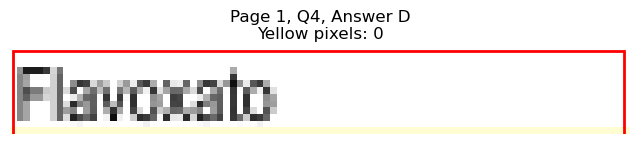

Page 1, Q4 - E: Detected box: x0=334.1, y0=362.8, x1=385.9, y1=375.5
Page 1, Q4, E: Yellow pixels: 1120
Page 1, Q4, E: Total non-white pixels: 1428
Page 1, Q4, E: Yellow percentage: 78.4%


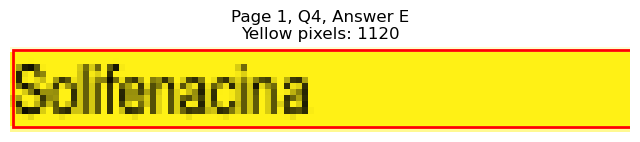


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.5, y0=425.9, x1=275.3, y1=438.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 950
Page 1, Q5, A: Yellow percentage: 0.0%


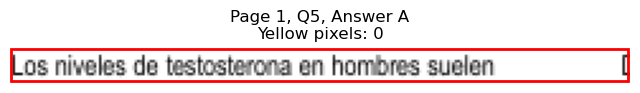

Page 1, Q5 - B: Detected box: x0=82.5, y0=451.1, x1=275.3, y1=463.8
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 851
Page 1, Q5, B: Yellow percentage: 0.0%


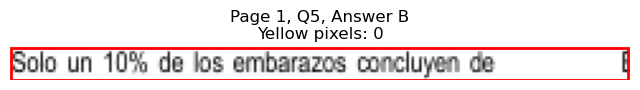

Page 1, Q5 - C: Detected box: x0=82.9, y0=476.3, x1=275.2, y1=489.0
Page 1, Q5, C: Yellow pixels: 1735
Page 1, Q5, C: Total non-white pixels: 2702
Page 1, Q5, C: Yellow percentage: 64.2%


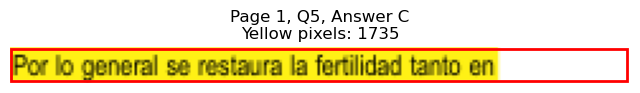

Page 1, Q5 - D: Detected box: x0=334.6, y0=425.9, x1=526.9, y1=438.6
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 942
Page 1, Q5, D: Yellow percentage: 0.0%


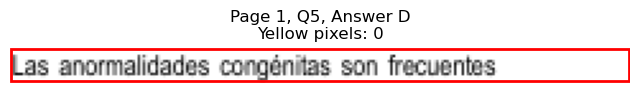

Page 1, Q5 - E: Detected box: x0=334.1, y0=451.1, x1=526.9, y1=463.8
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 951
Page 1, Q5, E: Yellow percentage: 0.0%


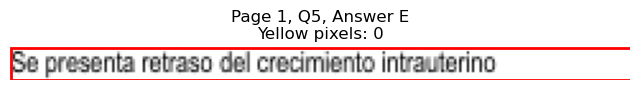


Page 1, Q5 - Selected Answer: C (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.5, y0=526.9, x1=117.6, y1=539.5
Page 1, Q6, A: Yellow pixels: 86
Page 1, Q6, A: Total non-white pixels: 210
Page 1, Q6, A: Yellow percentage: 41.0%


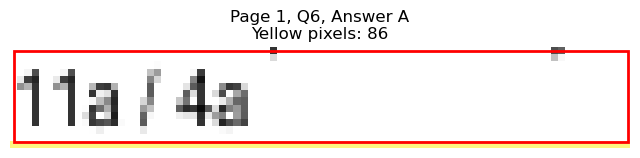

Page 1, Q6 - B: Detected box: x0=82.5, y0=539.5, x1=117.6, y1=552.1
Page 1, Q6, B: Yellow pixels: 1018
Page 1, Q6, B: Total non-white pixels: 1204
Page 1, Q6, B: Yellow percentage: 84.6%


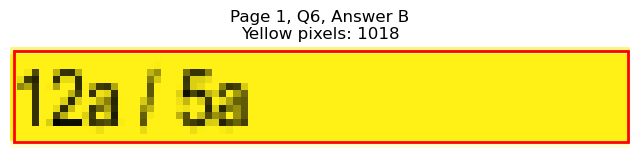

Page 1, Q6 - C: Detected box: x0=82.9, y0=552.2, x1=118.1, y1=564.8
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 226
Page 1, Q6, C: Yellow percentage: 0.0%


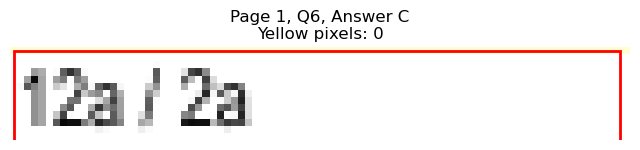

Page 1, Q6 - D: Detected box: x0=334.6, y0=526.9, x1=369.8, y1=539.5
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 136
Page 1, Q6, D: Yellow percentage: 0.0%


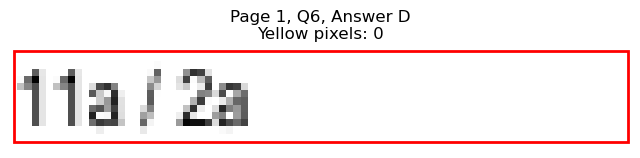

Page 1, Q6 - E: Detected box: x0=334.1, y0=539.5, x1=369.4, y1=552.1
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 137
Page 1, Q6, E: Yellow percentage: 0.0%


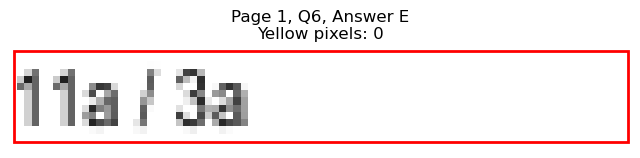


Page 1, Q6 - Selected Answer: B (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.5, y0=602.6, x1=113.1, y1=615.2
Page 1, Q7, A: Yellow pixels: 82
Page 1, Q7, A: Total non-white pixels: 217
Page 1, Q7, A: Yellow percentage: 37.8%


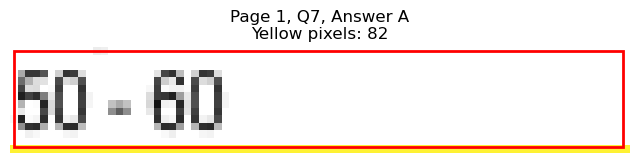

Page 1, Q7 - B: Detected box: x0=82.5, y0=615.2, x1=100.3, y1=627.8
Page 1, Q7, B: Yellow pixels: 835
Page 1, Q7, B: Total non-white pixels: 897
Page 1, Q7, B: Yellow percentage: 93.1%


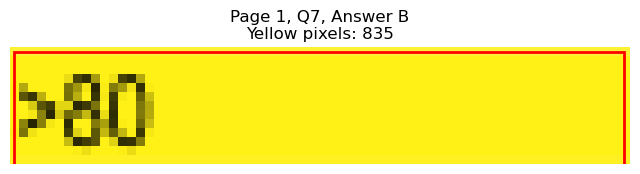

Page 1, Q7 - C: Detected box: x0=82.9, y0=627.9, x1=113.5, y1=640.6
Page 1, Q7, C: Yellow pixels: 82
Page 1, Q7, C: Total non-white pixels: 211
Page 1, Q7, C: Yellow percentage: 38.9%


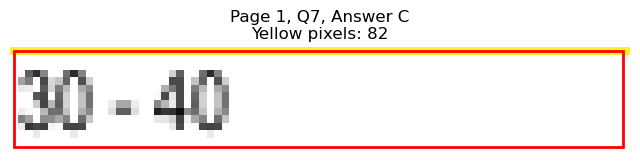

Page 1, Q7 - D: Detected box: x0=334.6, y0=602.6, x1=362.7, y1=615.2
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 118
Page 1, Q7, D: Yellow percentage: 0.0%


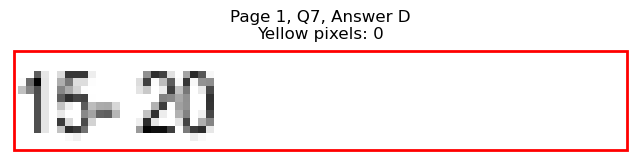

Page 1, Q7 - E: Detected box: x0=334.1, y0=615.2, x1=352.0, y1=627.8
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 62
Page 1, Q7, E: Yellow percentage: 0.0%


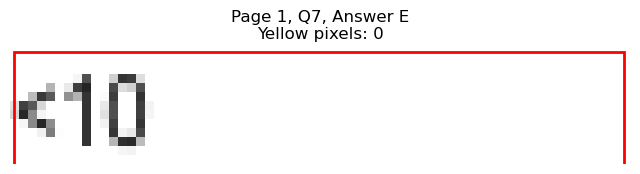


Page 1, Q7 - Selected Answer: B (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.5, y0=691.1, x1=132.1, y1=703.7
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 253
Page 1, Q8, A: Yellow percentage: 0.0%


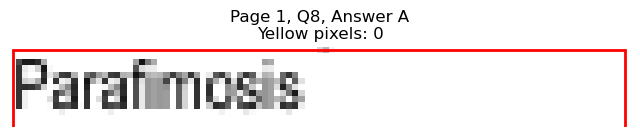

Page 1, Q8 - B: Detected box: x0=82.5, y0=703.7, x1=168.7, y1=716.3
Page 1, Q8, B: Yellow pixels: 137
Page 1, Q8, B: Total non-white pixels: 564
Page 1, Q8, B: Yellow percentage: 24.3%


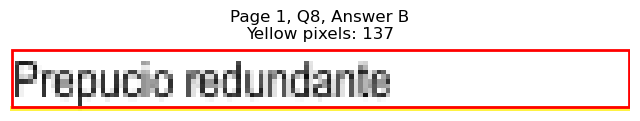

Page 1, Q8 - C: Detected box: x0=82.9, y0=716.3, x1=154.2, y1=728.9
Page 1, Q8, C: Yellow pixels: 1341
Page 1, Q8, C: Total non-white pixels: 1599
Page 1, Q8, C: Yellow percentage: 83.9%


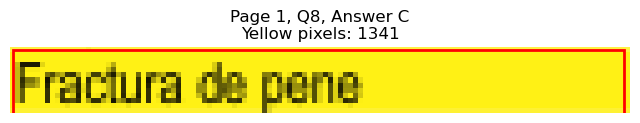

Page 1, Q8 - D: Detected box: x0=334.6, y0=691.1, x1=393.3, y1=703.7
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 322
Page 1, Q8, D: Yellow percentage: 0.0%


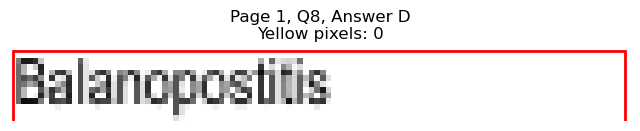

Page 1, Q8 - E: Detected box: x0=334.1, y0=703.7, x1=412.5, y1=716.3
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 397
Page 1, Q8, E: Yellow percentage: 0.0%


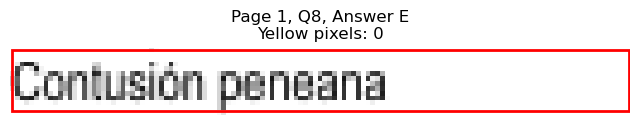


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 8 questions
Page 2, Q1 - A: Detected box: x0=70.8, y0=122.9, x1=79.3, y1=135.6
Page 2, Q1, A: Yellow pixels: 741
Page 2, Q1, A: Total non-white pixels: 840
Page 2, Q1, A: Yellow percentage: 88.2%


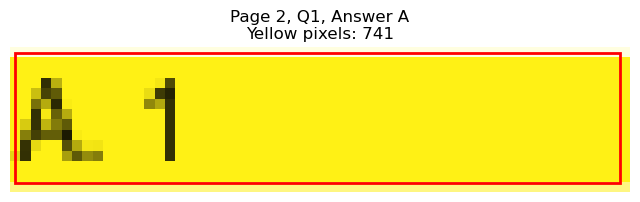

Page 2, Q1 - B: Detected box: x0=70.8, y0=135.5, x1=79.3, y1=148.2
Page 2, Q1, B: Yellow pixels: 60
Page 2, Q1, B: Total non-white pixels: 128
Page 2, Q1, B: Yellow percentage: 46.9%


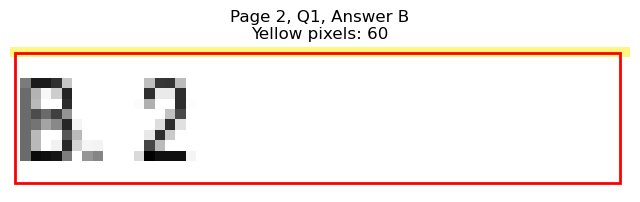

Page 2, Q1 - C: Detected box: x0=70.8, y0=148.2, x1=79.8, y1=160.9
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 66
Page 2, Q1, C: Yellow percentage: 0.0%


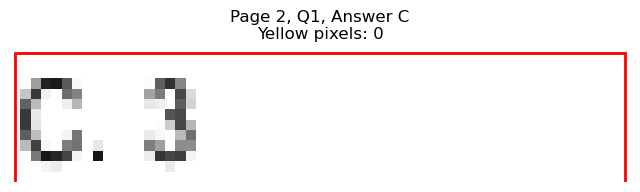

Page 2, Q1 - D: Detected box: x0=322.5, y0=122.9, x1=331.5, y1=135.6
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 72
Page 2, Q1, D: Yellow percentage: 0.0%


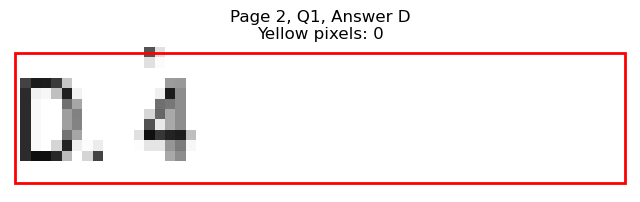

Page 2, Q1 - E: Detected box: x0=322.5, y0=135.5, x1=331.0, y1=148.2
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 68
Page 2, Q1, E: Yellow percentage: 0.0%


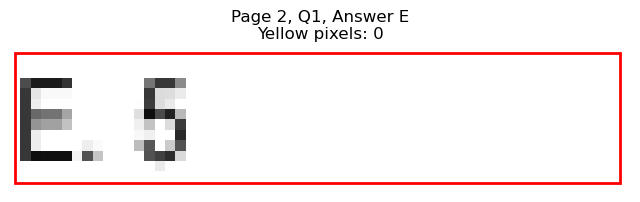


Page 2, Q1 - Selected Answer: A (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=163.7, y1=224.0
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 395
Page 2, Q2, A: Yellow percentage: 0.0%


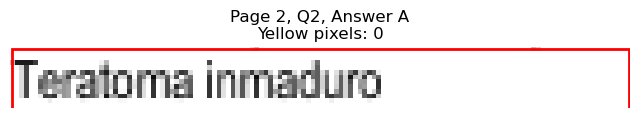

Page 2, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=163.2, y1=236.6
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 422
Page 2, Q2, B: Yellow percentage: 0.0%


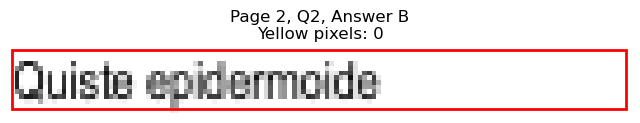

Page 2, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=196.3, y1=249.2
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 548
Page 2, Q2, C: Yellow percentage: 0.0%


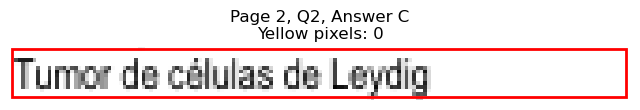

Page 2, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=446.9, y1=224.0
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 695
Page 2, Q2, D: Yellow percentage: 0.0%


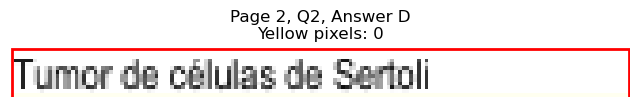

Page 2, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=432.4, y1=236.6
Page 2, Q2, E: Yellow pixels: 1570
Page 2, Q2, E: Total non-white pixels: 2086
Page 2, Q2, E: Yellow percentage: 75.3%


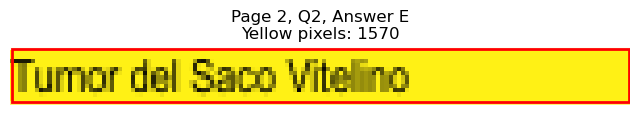


Page 2, Q2 - Selected Answer: E (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.5, y0=312.3, x1=214.4, y1=324.9
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 700
Page 2, Q3, A: Yellow percentage: 0.0%


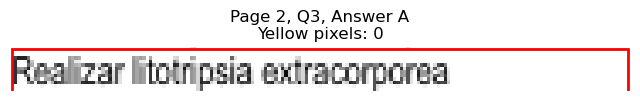

Page 2, Q3 - B: Detected box: x0=82.5, y0=324.9, x1=240.0, y1=337.5
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 786
Page 2, Q3, B: Yellow percentage: 0.0%


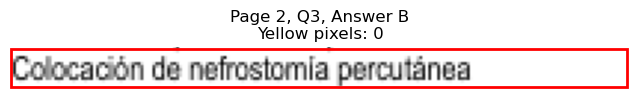

Page 2, Q3 - C: Detected box: x0=82.9, y0=337.5, x1=249.6, y1=350.1
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 781
Page 2, Q3, C: Yellow percentage: 0.0%


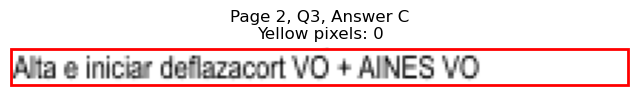

Page 2, Q3 - D: Detected box: x0=334.6, y0=312.3, x1=506.1, y1=324.9
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 1090
Page 2, Q3, D: Yellow percentage: 0.0%


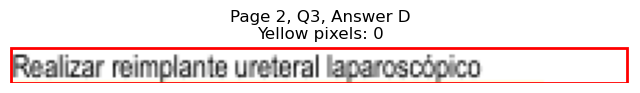

Page 2, Q3 - E: Detected box: x0=334.1, y0=324.9, x1=504.9, y1=337.5
Page 2, Q3, E: Yellow pixels: 1875
Page 2, Q3, E: Total non-white pixels: 2688
Page 2, Q3, E: Yellow percentage: 69.8%


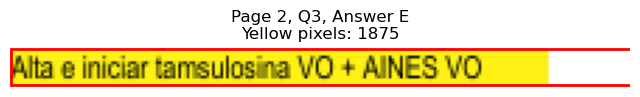


Page 2, Q3 - Selected Answer: E (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.5, y0=400.6, x1=176.8, y1=413.3
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 482
Page 2, Q4, A: Yellow percentage: 0.0%


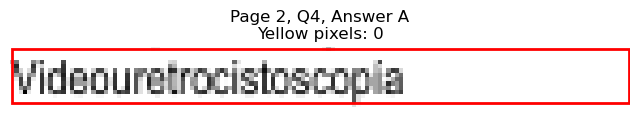

Page 2, Q4 - B: Detected box: x0=82.5, y0=413.3, x1=148.7, y1=426.0
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 321
Page 2, Q4, B: Yellow percentage: 0.0%


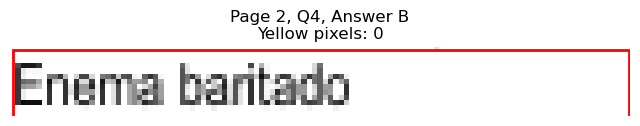

Page 2, Q4 - C: Detected box: x0=82.9, y0=425.9, x1=213.4, y1=438.6
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 676
Page 2, Q4, C: Yellow percentage: 0.0%


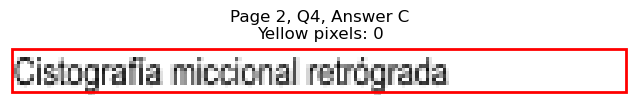

Page 2, Q4 - D: Detected box: x0=334.6, y0=400.6, x1=415.9, y1=413.3
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 396
Page 2, Q4, D: Yellow percentage: 0.0%


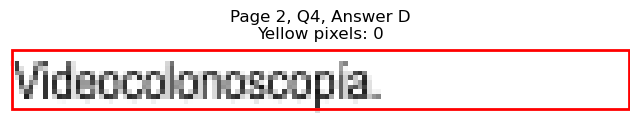

Page 2, Q4 - E: Detected box: x0=334.1, y0=413.3, x1=478.7, y1=426.0
Page 2, Q4, E: Yellow pixels: 1977
Page 2, Q4, E: Total non-white pixels: 2496
Page 2, Q4, E: Yellow percentage: 79.2%


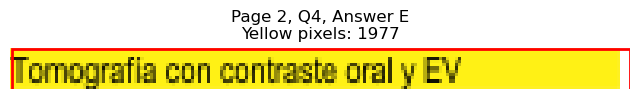


Page 2, Q4 - Selected Answer: E (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.5, y0=489.1, x1=116.1, y1=501.7
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 167
Page 2, Q5, A: Yellow percentage: 0.0%


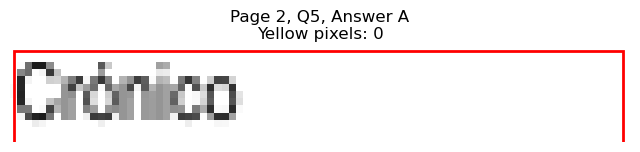

Page 2, Q5 - B: Detected box: x0=82.5, y0=501.7, x1=131.7, y1=514.3
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 271
Page 2, Q5, B: Yellow percentage: 0.0%


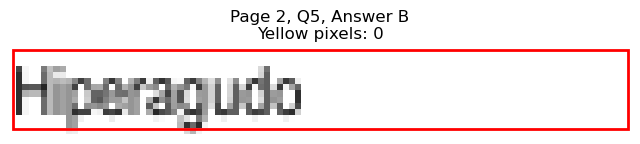

Page 2, Q5 - C: Detected box: x0=82.9, y0=514.3, x1=126.0, y1=526.9
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 215
Page 2, Q5, C: Yellow percentage: 0.0%


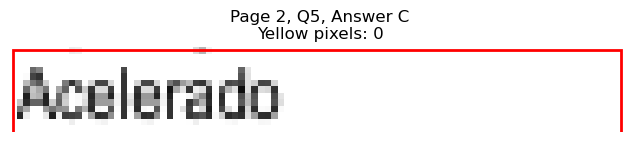

Page 2, Q5 - D: Detected box: x0=334.6, y0=489.1, x1=363.2, y1=501.7
Page 2, Q5, D: Yellow pixels: 934
Page 2, Q5, D: Total non-white pixels: 1040
Page 2, Q5, D: Yellow percentage: 89.8%


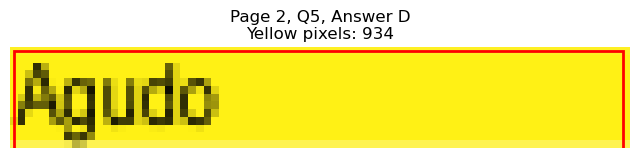

Page 2, Q5 - E: Detected box: x0=334.1, y0=501.7, x1=377.8, y1=514.3
Page 2, Q5, E: Yellow pixels: 92
Page 2, Q5, E: Total non-white pixels: 303
Page 2, Q5, E: Yellow percentage: 30.4%


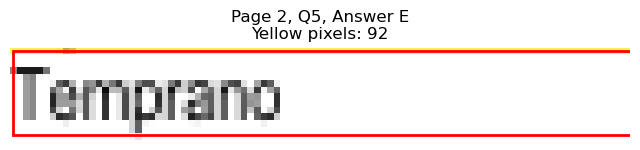


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.5, y0=577.4, x1=142.1, y1=590.0
Page 2, Q6, A: Yellow pixels: 111
Page 2, Q6, A: Total non-white pixels: 533
Page 2, Q6, A: Yellow percentage: 20.8%


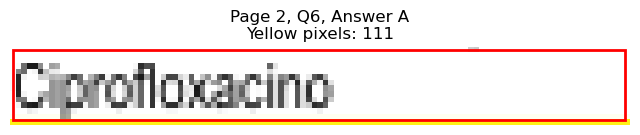

Page 2, Q6 - B: Detected box: x0=82.5, y0=590.0, x1=128.1, y1=602.6
Page 2, Q6, B: Yellow pixels: 1094
Page 2, Q6, B: Total non-white pixels: 1358
Page 2, Q6, B: Yellow percentage: 80.6%


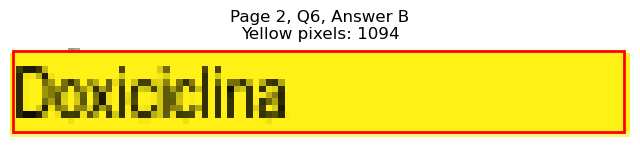

Page 2, Q6 - C: Detected box: x0=82.9, y0=602.6, x1=137.1, y1=615.2
Page 2, Q6, C: Yellow pixels: 106
Page 2, Q6, C: Total non-white pixels: 396
Page 2, Q6, C: Yellow percentage: 26.8%


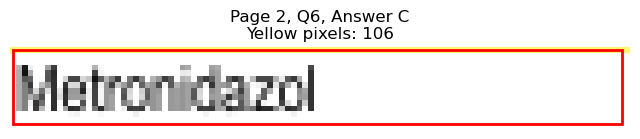

Page 2, Q6 - D: Detected box: x0=334.6, y0=577.4, x1=383.2, y1=590.0
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 245
Page 2, Q6, D: Yellow percentage: 0.0%


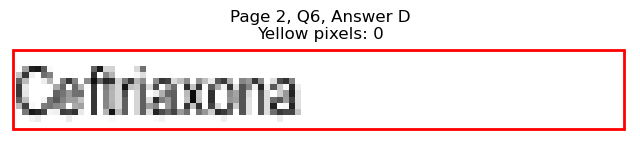

Page 2, Q6 - E: Detected box: x0=334.1, y0=590.0, x1=423.9, y1=602.6
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 487
Page 2, Q6, E: Yellow percentage: 0.0%


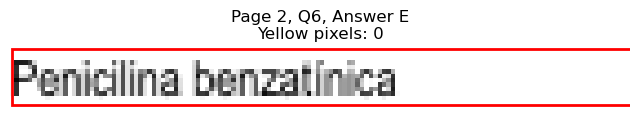


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=70.8, y0=665.7, x1=79.3, y1=678.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 51
Page 2, Q7, A: Yellow percentage: 0.0%


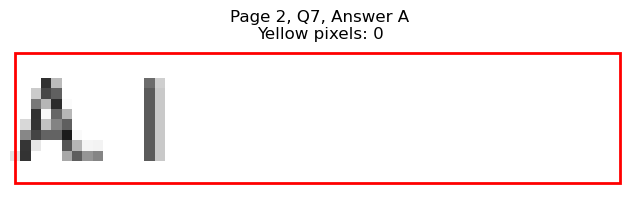

Page 2, Q7 - B: Detected box: x0=82.5, y0=678.3, x1=92.5, y1=691.0
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 48
Page 2, Q7, B: Yellow percentage: 0.0%


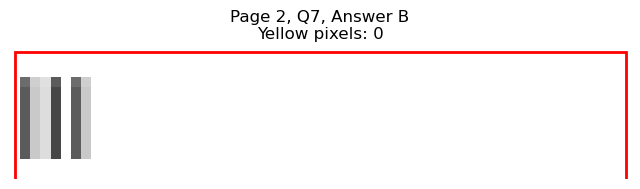

Page 2, Q7 - C: Detected box: x0=82.9, y0=691.1, x1=94.0, y1=703.7
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 45
Page 2, Q7, C: Yellow percentage: 0.0%


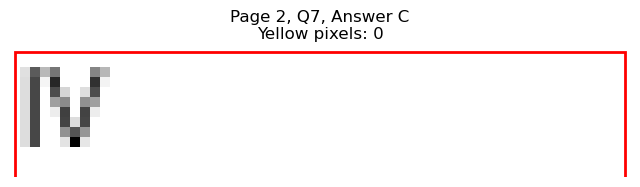

Page 2, Q7 - D: Detected box: x0=322.5, y0=665.7, x1=331.5, y1=678.4
Page 2, Q7, D: Yellow pixels: 666
Page 2, Q7, D: Total non-white pixels: 840
Page 2, Q7, D: Yellow percentage: 79.3%


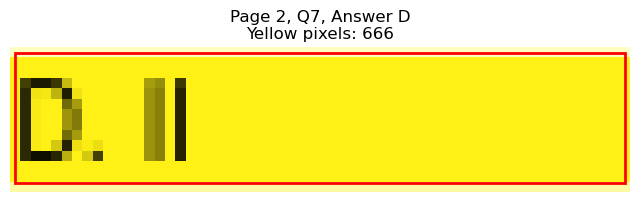

Page 2, Q7 - E: Detected box: x0=334.1, y0=678.3, x1=342.7, y1=691.0
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 87
Page 2, Q7, E: Yellow percentage: 0.0%


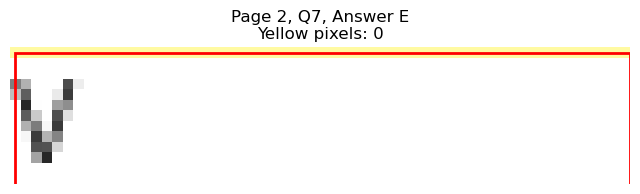


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.5, y0=728.9, x1=258.4, y1=741.5
Page 2, Q8, A: Yellow pixels: 192
Page 2, Q8, A: Total non-white pixels: 1082
Page 2, Q8, A: Yellow percentage: 17.7%


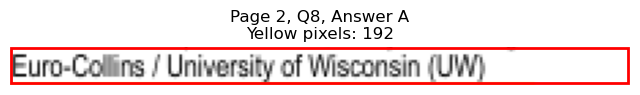

Page 2, Q8 - B: Detected box: x0=82.5, y0=741.4, x1=227.3, y1=754.1
Page 2, Q8, B: Yellow pixels: 1931
Page 2, Q8, B: Total non-white pixels: 2701
Page 2, Q8, B: Yellow percentage: 71.5%


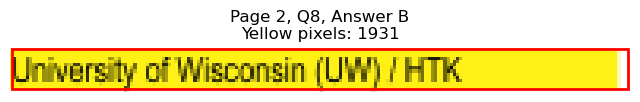

Page 2, Q8 - C: Detected box: x0=82.9, y0=754.0, x1=170.2, y1=766.7
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 572
Page 2, Q8, C: Yellow percentage: 0.0%


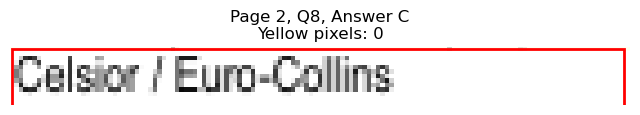

Page 2, Q8 - D: Detected box: x0=334.6, y0=728.9, x1=390.8, y1=741.5
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 268
Page 2, Q8, D: Yellow percentage: 0.0%


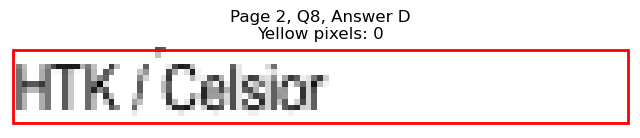

Page 2, Q8 - E: Detected box: x0=334.1, y0=741.4, x1=411.3, y1=754.1
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 367
Page 2, Q8, E: Yellow percentage: 0.0%


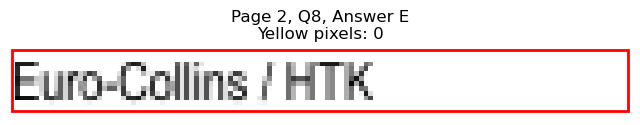


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)





Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=139.7, y1=123.0
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 250
Page 3, Q1, A: Yellow percentage: 0.0%


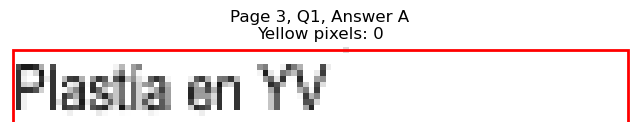

Page 3, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=163.2, y1=135.6
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 421
Page 3, Q1, B: Yellow percentage: 0.0%


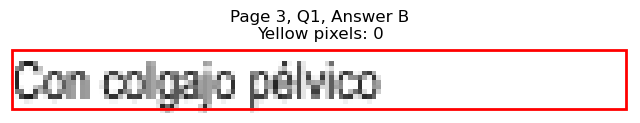

Page 3, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=120.6, y1=148.2
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 200
Page 3, Q1, C: Yellow percentage: 0.0%


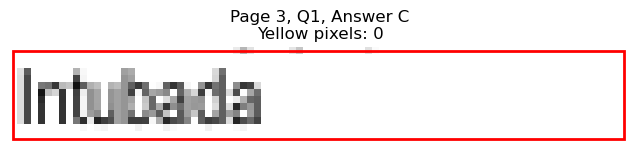

Page 3, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=393.8, y1=123.0
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 382
Page 3, Q1, D: Yellow percentage: 0.0%


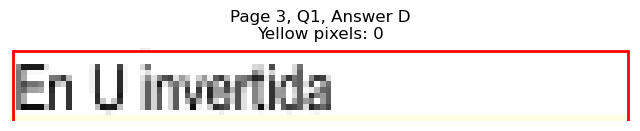

Page 3, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=395.8, y1=135.6
Page 3, Q1, E: Yellow pixels: 1210
Page 3, Q1, E: Total non-white pixels: 1568
Page 3, Q1, E: Yellow percentage: 77.2%


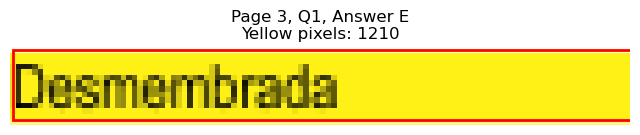


Page 3, Q1 - Selected Answer: E (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=219.9, y1=186.1
Page 3, Q2, A: Yellow pixels: 1979
Page 3, Q2, A: Total non-white pixels: 2632
Page 3, Q2, A: Yellow percentage: 75.2%


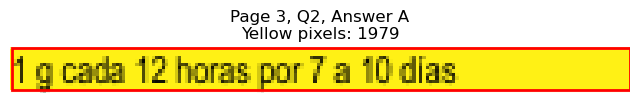

Page 3, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=219.9, y1=198.7
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 791
Page 3, Q2, B: Yellow percentage: 0.0%


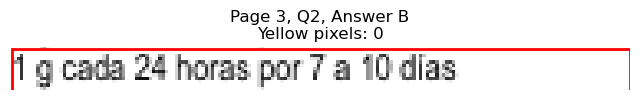

Page 3, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=215.3, y1=211.3
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 582
Page 3, Q2, C: Yellow percentage: 0.0%


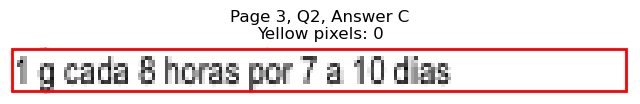

Page 3, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=467.0, y1=186.1
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 573
Page 3, Q2, D: Yellow percentage: 0.0%


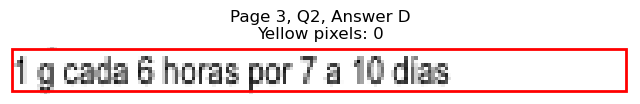

Page 3, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=466.5, y1=198.7
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 587
Page 3, Q2, E: Yellow percentage: 0.0%


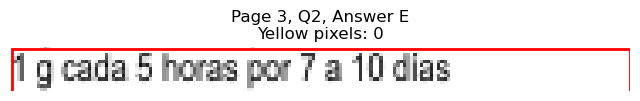


Page 3, Q2 - Selected Answer: A (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.5, y0=249.1, x1=209.9, y1=261.8
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 668
Page 3, Q3, A: Yellow percentage: 0.0%


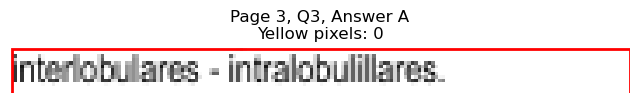

Page 3, Q3 - B: Detected box: x0=82.5, y0=261.7, x1=193.3, y1=274.4
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 564
Page 3, Q3, B: Yellow percentage: 0.0%


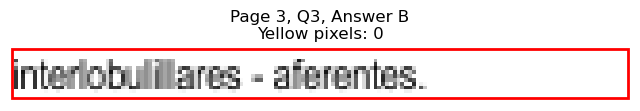

Page 3, Q3 - C: Detected box: x0=82.9, y0=274.5, x1=198.3, y1=287.1
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 541
Page 3, Q3, C: Yellow percentage: 0.0%


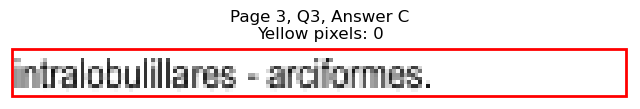

Page 3, Q3 - D: Detected box: x0=334.6, y0=249.1, x1=449.9, y1=261.8
Page 3, Q3, D: Yellow pixels: 1740
Page 3, Q3, D: Total non-white pixels: 2158
Page 3, Q3, D: Yellow percentage: 80.6%


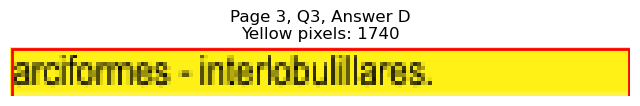

Page 3, Q3 - E: Detected box: x0=334.1, y0=261.7, x1=426.9, y1=274.4
Page 3, Q3, E: Yellow pixels: 143
Page 3, Q3, E: Total non-white pixels: 588
Page 3, Q3, E: Yellow percentage: 24.3%


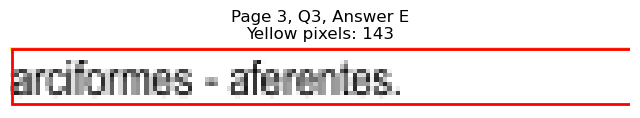


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=152.7, y1=350.1
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 348
Page 3, Q4, A: Yellow percentage: 0.0%


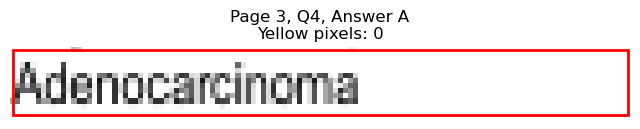

Page 3, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=152.2, y1=362.9
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 345
Page 3, Q4, B: Yellow percentage: 0.0%


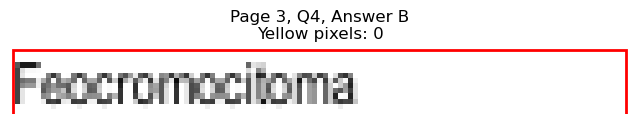

Page 3, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=133.6, y1=375.5
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 258
Page 3, Q4, C: Yellow percentage: 0.0%


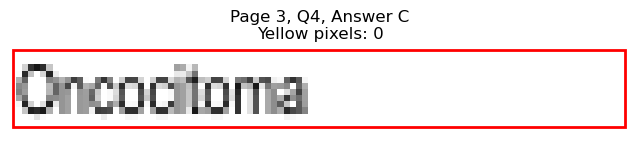

Page 3, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=375.8, y1=350.1
Page 3, Q4, D: Yellow pixels: 1046
Page 3, Q4, D: Total non-white pixels: 1288
Page 3, Q4, D: Yellow percentage: 81.2%


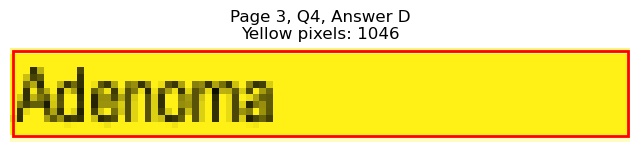

Page 3, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=377.3, y1=362.9
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 365
Page 3, Q4, E: Yellow percentage: 0.0%


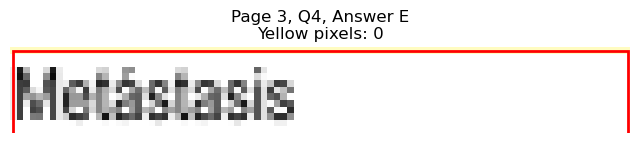


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.5, y0=400.6, x1=158.2, y1=413.3
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 374
Page 3, Q5, A: Yellow percentage: 0.0%


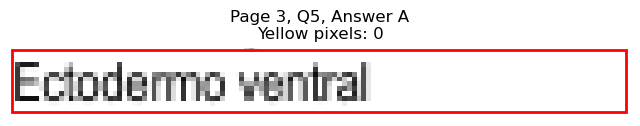

Page 3, Q5 - B: Detected box: x0=82.5, y0=413.3, x1=177.3, y1=426.0
Page 3, Q5, B: Yellow pixels: 1529
Page 3, Q5, B: Total non-white pixels: 1898
Page 3, Q5, B: Yellow percentage: 80.6%


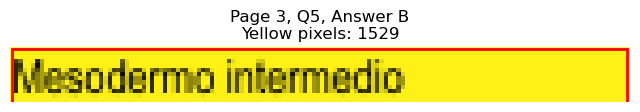

Page 3, Q5 - C: Detected box: x0=82.9, y0=425.9, x1=135.6, y1=438.6
Page 3, Q5, C: Yellow pixels: 104
Page 3, Q5, C: Total non-white pixels: 373
Page 3, Q5, C: Yellow percentage: 27.9%


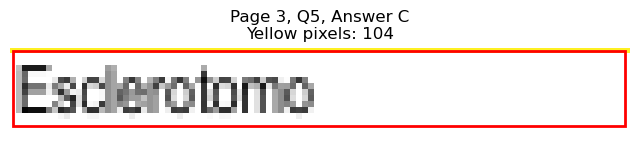

Page 3, Q5 - D: Detected box: x0=334.6, y0=400.6, x1=435.9, y1=413.3
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 502
Page 3, Q5, D: Yellow percentage: 0.0%


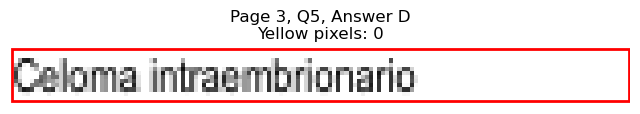

Page 3, Q5 - E: Detected box: x0=334.1, y0=413.3, x1=383.3, y1=426.0
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 253
Page 3, Q5, E: Yellow percentage: 0.0%


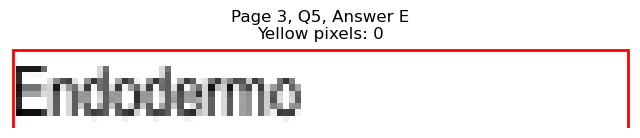


Page 3, Q5 - Selected Answer: B (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.5, y0=463.7, x1=109.1, y1=476.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 139
Page 3, Q6, A: Yellow percentage: 0.0%


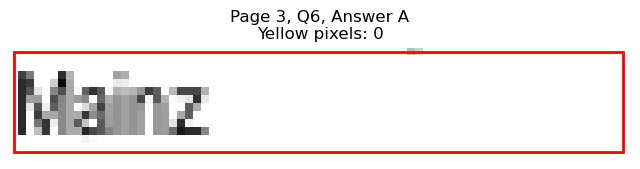

Page 3, Q6 - B: Detected box: x0=82.5, y0=476.3, x1=113.5, y1=489.0
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 150
Page 3, Q6, B: Yellow percentage: 0.0%


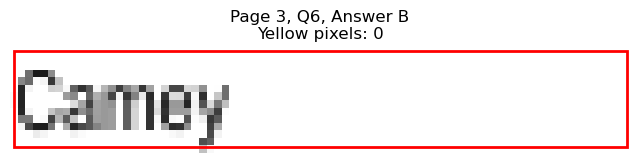

Page 3, Q6 - C: Detected box: x0=82.9, y0=489.1, x1=122.1, y1=501.7
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 184
Page 3, Q6, C: Yellow percentage: 0.0%


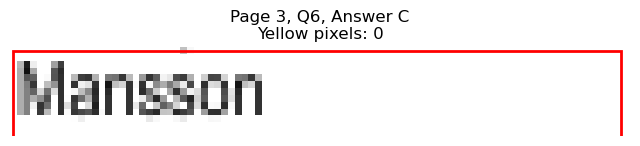

Page 3, Q6 - D: Detected box: x0=334.6, y0=463.7, x1=366.8, y1=476.4
Page 3, Q6, D: Yellow pixels: 83
Page 3, Q6, D: Total non-white pixels: 253
Page 3, Q6, D: Yellow percentage: 32.8%


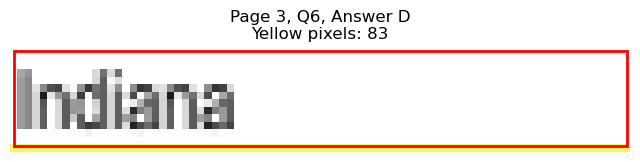

Page 3, Q6 - E: Detected box: x0=334.1, y0=476.3, x1=364.7, y1=489.0
Page 3, Q6, E: Yellow pixels: 926
Page 3, Q6, E: Total non-white pixels: 1134
Page 3, Q6, E: Yellow percentage: 81.7%


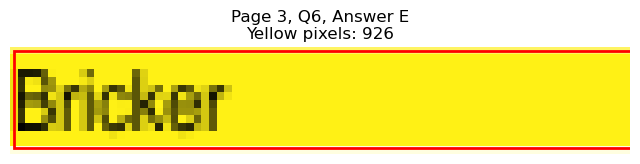


Page 3, Q6 - Selected Answer: E (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.5, y0=539.5, x1=122.1, y1=552.1
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 208
Page 3, Q7, A: Yellow percentage: 0.0%


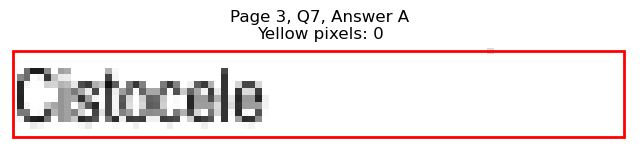

Page 3, Q7 - B: Detected box: x0=82.5, y0=552.2, x1=148.2, y1=564.8
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 335
Page 3, Q7, B: Yellow percentage: 0.0%


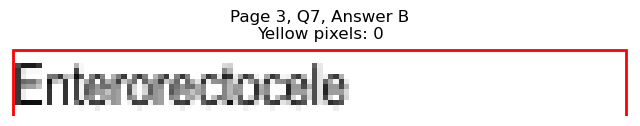

Page 3, Q7 - C: Detected box: x0=82.9, y0=564.8, x1=130.6, y1=577.4
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 250
Page 3, Q7, C: Yellow percentage: 0.0%


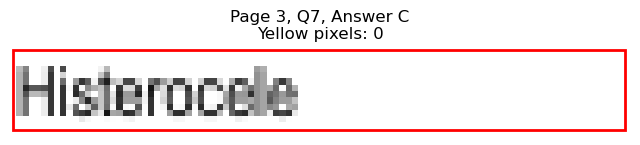

Page 3, Q7 - D: Detected box: x0=334.6, y0=539.5, x1=378.8, y1=552.1
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 224
Page 3, Q7, D: Yellow percentage: 0.0%


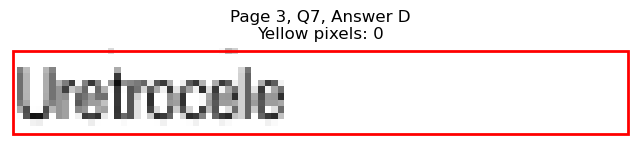

Page 3, Q7 - E: Detected box: x0=334.1, y0=552.2, x1=396.8, y1=564.8
Page 3, Q7, E: Yellow pixels: 1222
Page 3, Q7, E: Total non-white pixels: 1469
Page 3, Q7, E: Yellow percentage: 83.2%


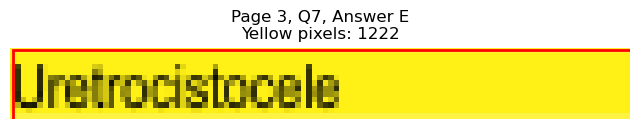


Page 3, Q7 - Selected Answer: E (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=236.1, y0=627.9, x1=275.1, y1=640.6
Page 3, Q8, A: Yellow pixels: 354
Page 3, Q8, A: Total non-white pixels: 569
Page 3, Q8, A: Yellow percentage: 62.2%


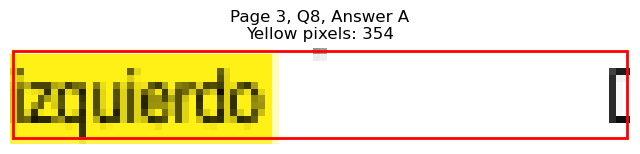

Page 3, Q8 - B: Detected box: x0=82.5, y0=653.1, x1=275.3, y1=665.8
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 1003
Page 3, Q8, B: Yellow percentage: 0.0%


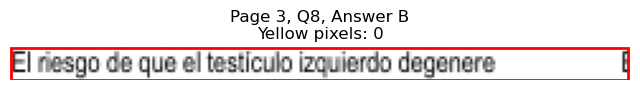

Page 3, Q8 - C: Detected box: x0=82.9, y0=678.3, x1=275.2, y1=691.0
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 946
Page 3, Q8, C: Yellow percentage: 0.0%


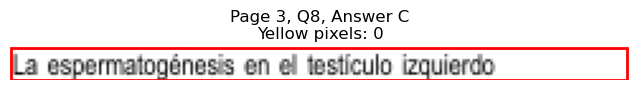

Page 3, Q8 - D: Detected box: x0=334.6, y0=627.9, x1=351.8, y1=640.6
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 236
Page 3, Q8, D: Yellow percentage: 0.0%


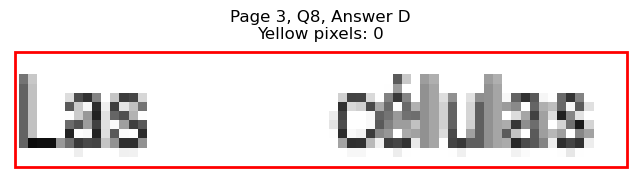

Page 3, Q8 - E: Detected box: x0=334.1, y0=653.1, x1=527.0, y1=665.8
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 946
Page 3, Q8, E: Yellow percentage: 0.0%


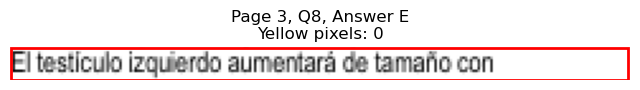


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=82.5, y0=728.9, x1=165.3, y1=741.5
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 434
Page 3, Q9, A: Yellow percentage: 0.0%


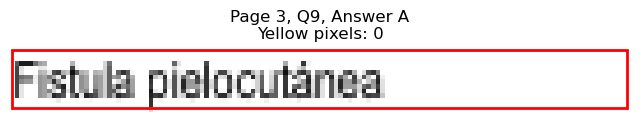

Page 3, Q9 - B: Detected box: x0=82.5, y0=741.4, x1=168.7, y1=754.1
Page 3, Q9, B: Yellow pixels: 137
Page 3, Q9, B: Total non-white pixels: 545
Page 3, Q9, B: Yellow percentage: 25.1%


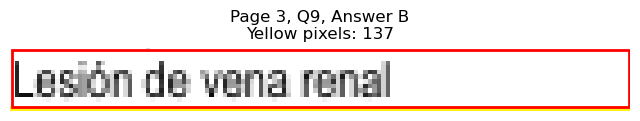

Page 3, Q9 - C: Detected box: x0=82.9, y0=754.0, x1=188.3, y1=766.7
Page 3, Q9, C: Yellow pixels: 1654
Page 3, Q9, C: Total non-white pixels: 2041
Page 3, Q9, C: Yellow percentage: 81.0%


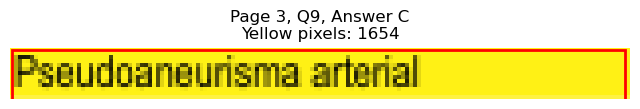

Page 3, Q9 - D: Detected box: x0=334.6, y0=728.9, x1=432.4, y1=741.5
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 530
Page 3, Q9, D: Yellow percentage: 0.0%


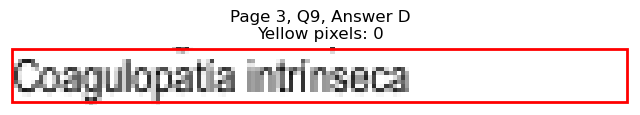

Page 3, Q9 - E: Detected box: x0=334.1, y0=741.4, x1=436.0, y1=754.1
Page 3, Q9, E: Yellow pixels: 0
Page 3, Q9, E: Total non-white pixels: 539
Page 3, Q9, E: Yellow percentage: 0.0%


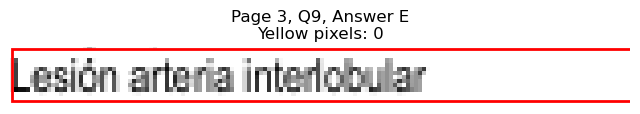


Page 3, Q9 - Selected Answer: C (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=188.8, y1=123.0
Page 4, Q1, A: Yellow pixels: 1610
Page 4, Q1, A: Total non-white pixels: 2041
Page 4, Q1, A: Yellow percentage: 78.9%


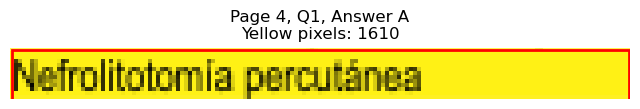

Page 4, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=220.8, y1=135.6
Page 4, Q1, B: Yellow pixels: 187
Page 4, Q1, B: Total non-white pixels: 913
Page 4, Q1, B: Yellow percentage: 20.5%


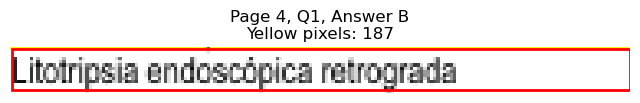

Page 4, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=206.9, y1=148.2
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 626
Page 4, Q1, C: Yellow percentage: 0.0%


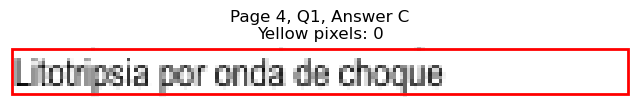

Page 4, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=451.5, y1=123.0
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 594
Page 4, Q1, D: Yellow percentage: 0.0%


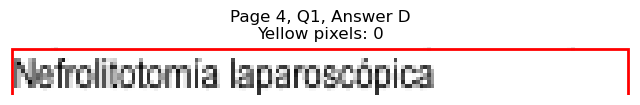

Page 4, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=448.0, y1=135.6
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 573
Page 4, Q1, E: Yellow percentage: 0.0%


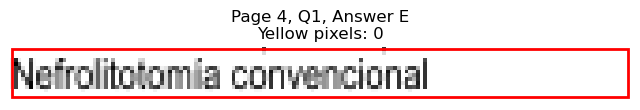


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=70.8, y0=186.0, x1=79.3, y1=198.7
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 74
Page 4, Q2, A: Yellow percentage: 0.0%


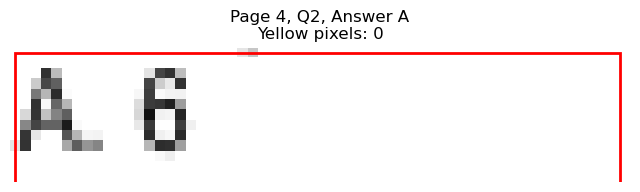

Page 4, Q2 - B: Detected box: x0=70.8, y0=198.6, x1=79.3, y1=211.3
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 75
Page 4, Q2, B: Yellow percentage: 0.0%


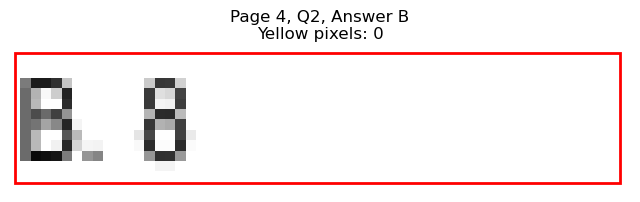

Page 4, Q2 - C: Detected box: x0=70.8, y0=211.3, x1=79.8, y1=224.0
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 61
Page 4, Q2, C: Yellow percentage: 0.0%


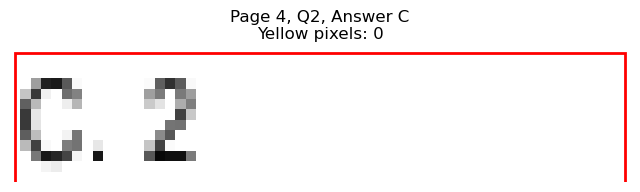

Page 4, Q2 - D: Detected box: x0=322.5, y0=186.0, x1=331.5, y1=198.7
Page 4, Q2, D: Yellow pixels: 728
Page 4, Q2, D: Total non-white pixels: 780
Page 4, Q2, D: Yellow percentage: 93.3%


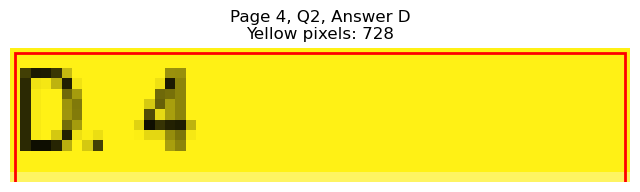

Page 4, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=346.7, y1=211.3
Page 4, Q2, E: Yellow pixels: 63
Page 4, Q2, E: Total non-white pixels: 114
Page 4, Q2, E: Yellow percentage: 55.3%


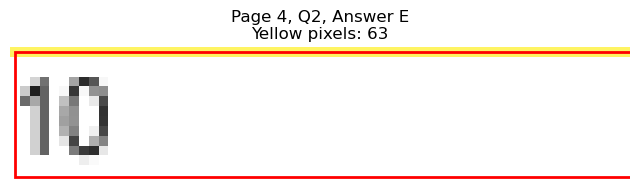


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=252.5, y1=274.4
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 855
Page 4, Q3, A: Yellow percentage: 0.0%


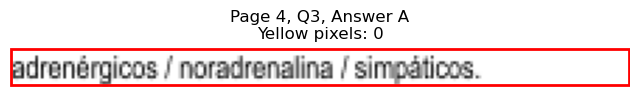

Page 4, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=260.1, y1=287.1
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 912
Page 4, Q3, B: Yellow percentage: 0.0%


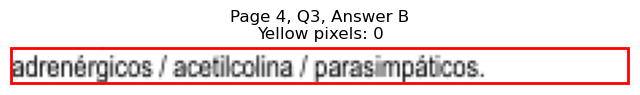

Page 4, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=251.9, y1=299.7
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 825
Page 4, Q3, C: Yellow percentage: 0.0%


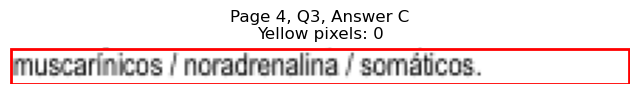

Page 4, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=492.1, y1=274.4
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 792
Page 4, Q3, D: Yellow percentage: 0.0%


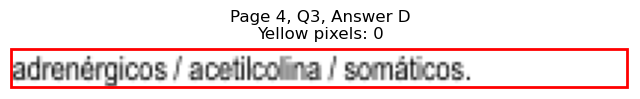

Page 4, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=512.7, y1=287.1
Page 4, Q3, E: Yellow pixels: 1822
Page 4, Q3, E: Total non-white pixels: 2688
Page 4, Q3, E: Yellow percentage: 67.8%


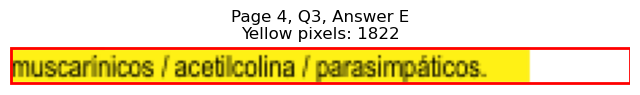


Page 4, Q3 - Selected Answer: E (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=163.7, y1=350.1
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 412
Page 4, Q4, A: Yellow percentage: 0.0%


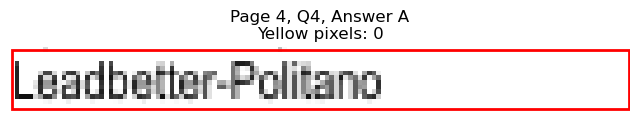

Page 4, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=128.1, y1=362.9
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 292
Page 4, Q4, B: Yellow percentage: 0.0%


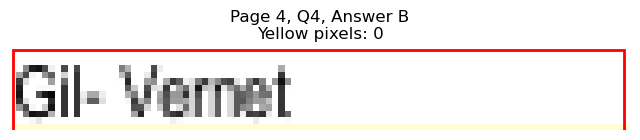

Page 4, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=135.1, y1=375.5
Page 4, Q4, C: Yellow pixels: 1162
Page 4, Q4, C: Total non-white pixels: 1456
Page 4, Q4, C: Yellow percentage: 79.8%


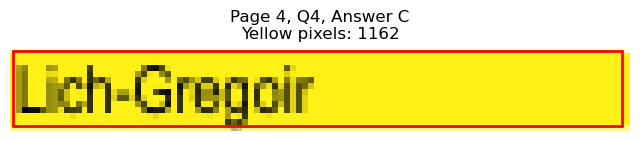

Page 4, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=402.8, y1=350.1
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 344
Page 4, Q4, D: Yellow percentage: 0.0%


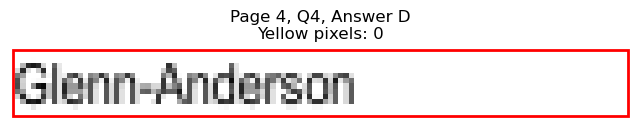

Page 4, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=387.8, y1=362.9
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 271
Page 4, Q4, E: Yellow percentage: 0.0%


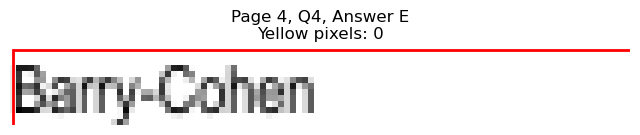


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.5, y0=400.6, x1=154.2, y1=413.3
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 361
Page 4, Q5, A: Yellow percentage: 0.0%


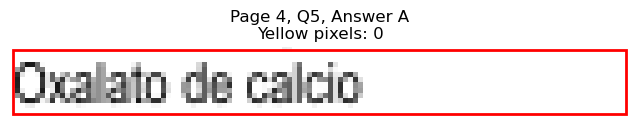

Page 4, Q5 - B: Detected box: x0=82.5, y0=413.3, x1=129.6, y1=426.0
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 225
Page 4, Q5, B: Yellow percentage: 0.0%


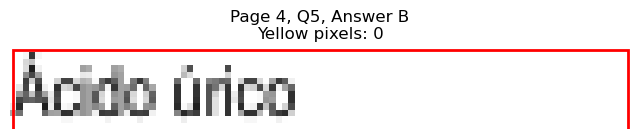

Page 4, Q5 - C: Detected box: x0=82.9, y0=425.9, x1=113.1, y1=438.6
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 135
Page 4, Q5, C: Yellow percentage: 0.0%


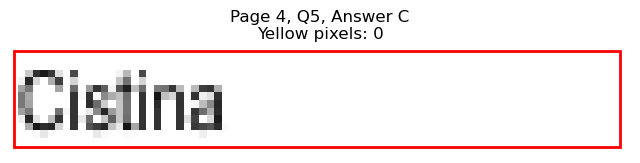

Page 4, Q5 - D: Detected box: x0=334.6, y0=400.6, x1=405.3, y1=413.3
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 343
Page 4, Q5, D: Yellow percentage: 0.0%


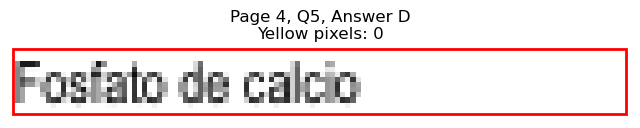

Page 4, Q5 - E: Detected box: x0=334.1, y0=413.3, x1=371.7, y1=426.0
Page 4, Q5, E: Yellow pixels: 990
Page 4, Q5, E: Total non-white pixels: 1144
Page 4, Q5, E: Yellow percentage: 86.5%


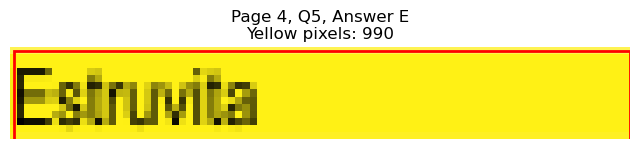


Page 4, Q5 - Selected Answer: E (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.5, y0=501.7, x1=168.7, y1=514.3
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 450
Page 4, Q6, A: Yellow percentage: 0.0%


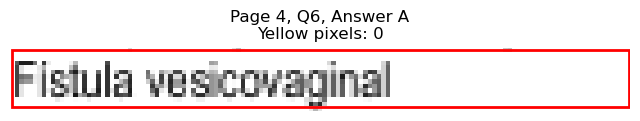

Page 4, Q6 - B: Detected box: x0=82.5, y0=514.3, x1=220.4, y1=526.9
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 701
Page 4, Q6, B: Yellow percentage: 0.0%


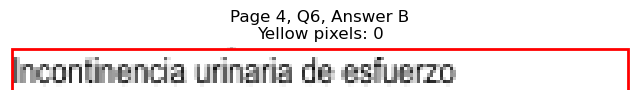

Page 4, Q6 - C: Detected box: x0=82.9, y0=526.9, x1=195.3, y1=539.5
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 559
Page 4, Q6, C: Yellow percentage: 0.0%


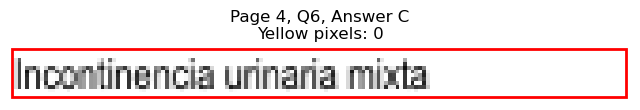

Page 4, Q6 - D: Detected box: x0=334.6, y0=501.7, x1=452.0, y1=514.3
Page 4, Q6, D: Yellow pixels: 168
Page 4, Q6, D: Total non-white pixels: 743
Page 4, Q6, D: Yellow percentage: 22.6%


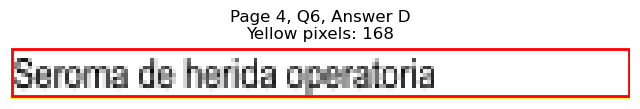

Page 4, Q6 - E: Detected box: x0=334.1, y0=514.3, x1=423.4, y1=526.9
Page 4, Q6, E: Yellow pixels: 1448
Page 4, Q6, E: Total non-white pixels: 1820
Page 4, Q6, E: Yellow percentage: 79.6%


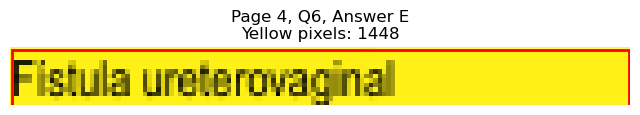


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.5, y0=590.0, x1=186.3, y1=602.6
Page 4, Q7, A: Yellow pixels: 155
Page 4, Q7, A: Total non-white pixels: 720
Page 4, Q7, A: Yellow percentage: 21.5%


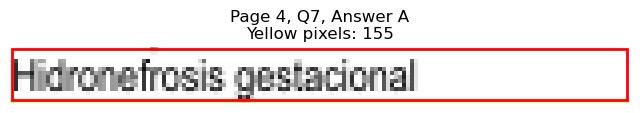

Page 4, Q7 - B: Detected box: x0=82.5, y0=602.6, x1=162.3, y1=615.2
Page 4, Q7, B: Yellow pixels: 1406
Page 4, Q7, B: Total non-white pixels: 1834
Page 4, Q7, B: Yellow percentage: 76.7%


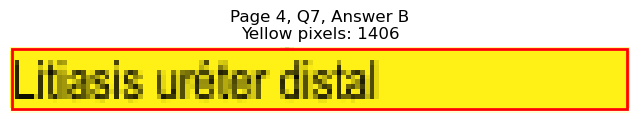

Page 4, Q7 - C: Detected box: x0=82.9, y0=615.2, x1=213.9, y1=627.8
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 864
Page 4, Q7, C: Yellow percentage: 0.0%


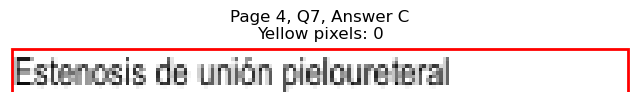

Page 4, Q7 - D: Detected box: x0=334.6, y0=590.0, x1=423.9, y1=602.6
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 457
Page 4, Q7, D: Yellow percentage: 0.0%


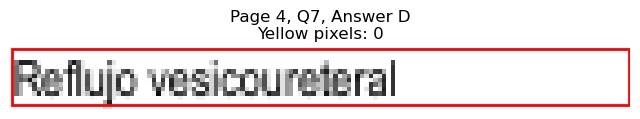

Page 4, Q7 - E: Detected box: x0=334.1, y0=602.6, x1=427.5, y1=615.2
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 477
Page 4, Q7, E: Yellow percentage: 0.0%


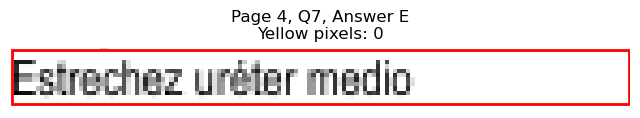


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.5, y0=653.1, x1=95.5, y1=665.8
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 112
Page 4, Q8, A: Yellow percentage: 0.0%


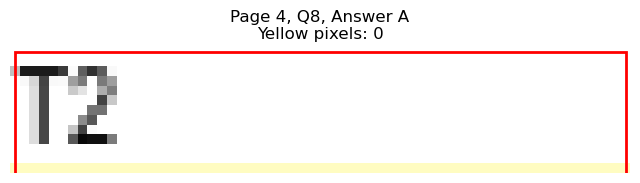

Page 4, Q8 - B: Detected box: x0=82.5, y0=665.7, x1=95.5, y1=678.4
Page 4, Q8, B: Yellow pixels: 737
Page 4, Q8, B: Total non-white pixels: 896
Page 4, Q8, B: Yellow percentage: 82.3%


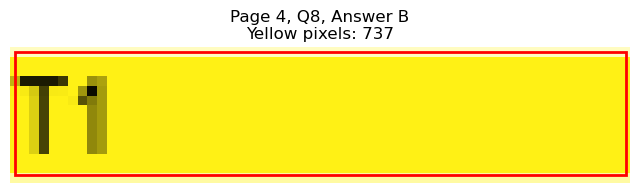

Page 4, Q8 - C: Detected box: x0=82.9, y0=678.3, x1=96.0, y1=691.0
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 114
Page 4, Q8, C: Yellow percentage: 0.0%


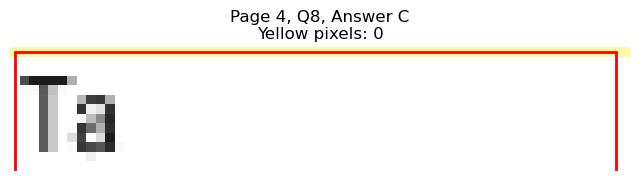

Page 4, Q8 - D: Detected box: x0=334.6, y0=653.1, x1=349.1, y1=665.8
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 59
Page 4, Q8, D: Yellow percentage: 0.0%


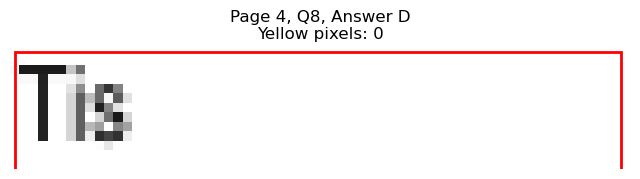

Page 4, Q8 - E: Detected box: x0=334.1, y0=665.7, x1=347.2, y1=678.4
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 52
Page 4, Q8, E: Yellow percentage: 0.0%


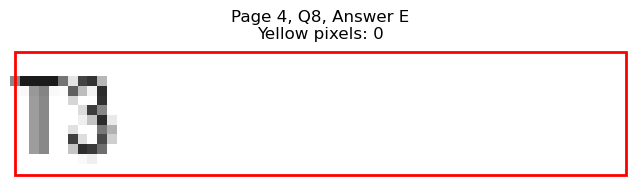


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=82.5, y0=716.3, x1=181.2, y1=728.9
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 469
Page 4, Q9, A: Yellow percentage: 0.0%


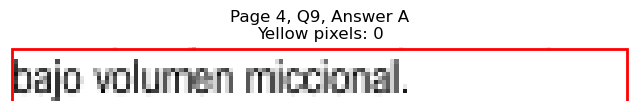

Page 4, Q9 - B: Detected box: x0=82.5, y0=728.9, x1=146.7, y1=741.5
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 294
Page 4, Q9, B: Yellow percentage: 0.0%


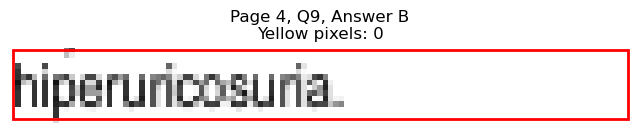

Page 4, Q9 - C: Detected box: x0=82.9, y0=741.4, x1=166.2, y1=754.1
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 387
Page 4, Q9, C: Yellow percentage: 0.0%


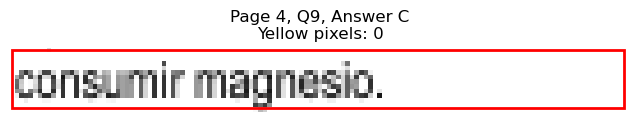

Page 4, Q9 - D: Detected box: x0=334.6, y0=716.3, x1=391.3, y1=728.9
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 393
Page 4, Q9, D: Yellow percentage: 0.0%


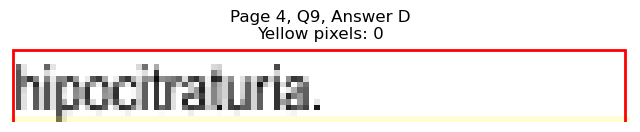

Page 4, Q9 - E: Detected box: x0=334.1, y0=728.9, x1=400.5, y1=741.5
Page 4, Q9, E: Yellow pixels: 1268
Page 4, Q9, E: Total non-white pixels: 1638
Page 4, Q9, E: Yellow percentage: 77.4%


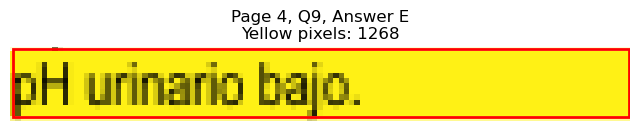


Page 4, Q9 - Selected Answer: E (based on yellow pixel count)





Page 5: Found 8 questions
Page 5, Q1 - A: Detected box: x0=82.5, y0=135.5, x1=209.4, y1=148.2
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 647
Page 5, Q1, A: Yellow percentage: 0.0%


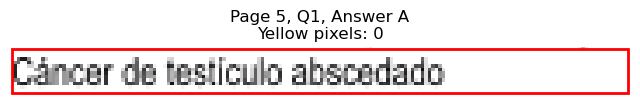

Page 5, Q1 - B: Detected box: x0=82.5, y0=148.2, x1=232.0, y1=160.9
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 760
Page 5, Q1, B: Yellow percentage: 0.0%


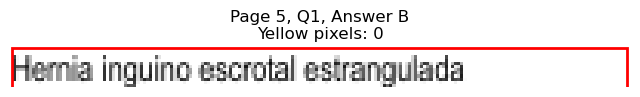

Page 5, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=174.3, y1=173.5
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 472
Page 5, Q1, C: Yellow percentage: 0.0%


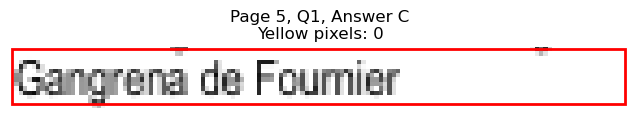

Page 5, Q1 - D: Detected box: x0=334.6, y0=135.5, x1=414.4, y1=148.2
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 424
Page 5, Q1, D: Yellow percentage: 0.0%


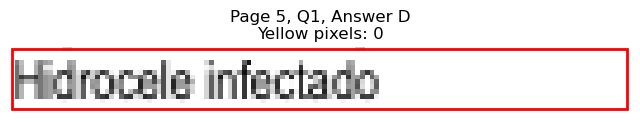

Page 5, Q1 - E: Detected box: x0=334.1, y0=148.2, x1=453.5, y1=160.9
Page 5, Q1, E: Yellow pixels: 1742
Page 5, Q1, E: Total non-white pixels: 2210
Page 5, Q1, E: Yellow percentage: 78.8%


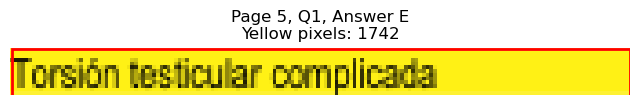


Page 5, Q1 - Selected Answer: E (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=153.6, y1=224.0
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 355
Page 5, Q2, A: Yellow percentage: 0.0%


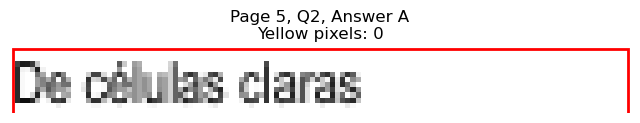

Page 5, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=157.7, y1=236.6
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 384
Page 5, Q2, B: Yellow percentage: 0.0%


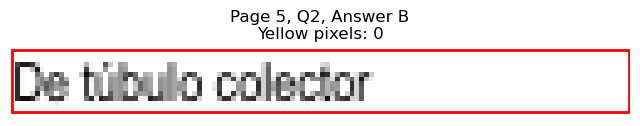

Page 5, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=130.1, y1=249.2
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 230
Page 5, Q2, C: Yellow percentage: 0.0%


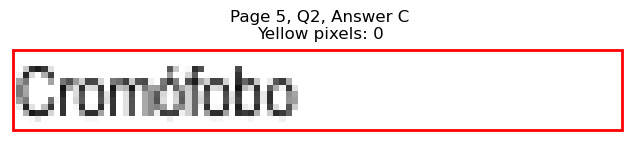

Page 5, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=369.8, y1=224.0
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 279
Page 5, Q2, D: Yellow percentage: 0.0%


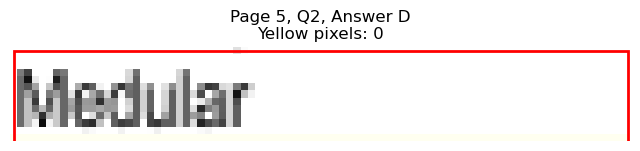

Page 5, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=362.3, y1=236.6
Page 5, Q2, E: Yellow pixels: 899
Page 5, Q2, E: Total non-white pixels: 1106
Page 5, Q2, E: Yellow percentage: 81.3%


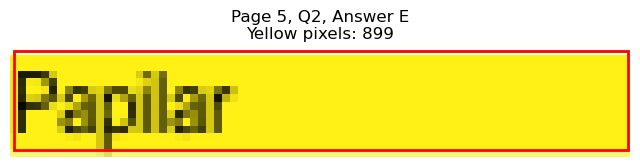


Page 5, Q2 - Selected Answer: E (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=220.0, y1=312.3
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 712
Page 5, Q3, A: Yellow percentage: 0.0%


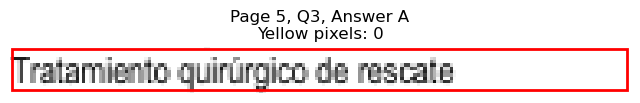

Page 5, Q3 - B: Detected box: x0=82.5, y0=312.3, x1=221.9, y1=324.9
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 705
Page 5, Q3, B: Yellow percentage: 0.0%


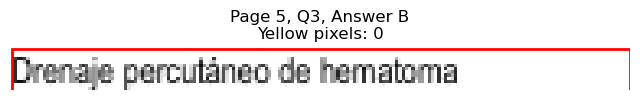

Page 5, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=230.0, y1=337.5
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 755
Page 5, Q3, C: Yellow percentage: 0.0%


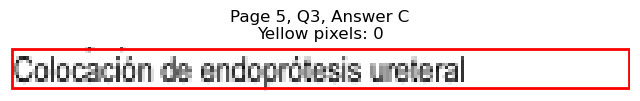

Page 5, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=440.9, y1=312.3
Page 5, Q3, D: Yellow pixels: 157
Page 5, Q3, D: Total non-white pixels: 687
Page 5, Q3, D: Yellow percentage: 22.9%


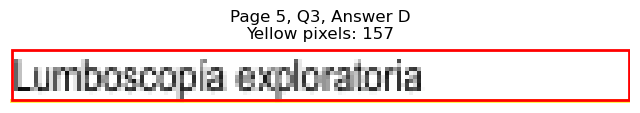

Page 5, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=476.6, y1=324.9
Page 5, Q3, E: Yellow pixels: 1956
Page 5, Q3, E: Total non-white pixels: 2496
Page 5, Q3, E: Yellow percentage: 78.4%


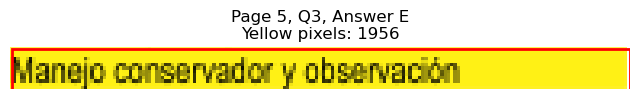


Page 5, Q3 - Selected Answer: E (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.5, y0=362.8, x1=201.4, y1=375.5
Page 5, Q4, A: Yellow pixels: 170
Page 5, Q4, A: Total non-white pixels: 802
Page 5, Q4, A: Yellow percentage: 21.2%


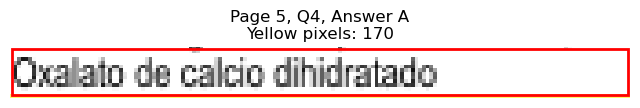

Page 5, Q4 - B: Detected box: x0=82.5, y0=375.4, x1=217.0, y1=388.1
Page 5, Q4, B: Yellow pixels: 1890
Page 5, Q4, B: Total non-white pixels: 2604
Page 5, Q4, B: Yellow percentage: 72.6%


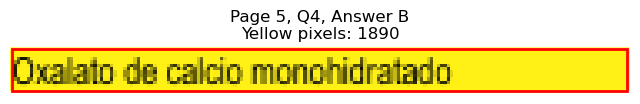

Page 5, Q4 - C: Detected box: x0=82.9, y0=388.0, x1=193.8, y1=400.7
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 723
Page 5, Q4, C: Yellow percentage: 0.0%


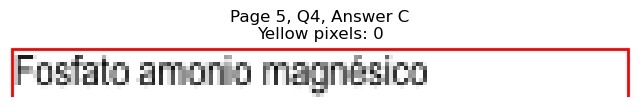

Page 5, Q4 - D: Detected box: x0=334.6, y0=362.8, x1=381.8, y1=375.5
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 236
Page 5, Q4, D: Yellow percentage: 0.0%


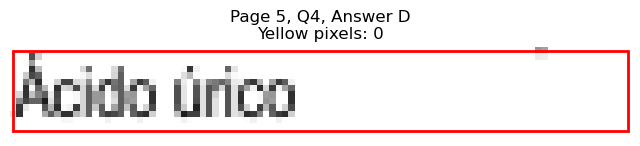

Page 5, Q4 - E: Detected box: x0=334.1, y0=375.4, x1=404.8, y1=388.1
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 333
Page 5, Q4, E: Yellow percentage: 0.0%


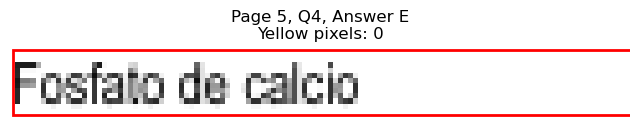


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.5, y0=451.1, x1=149.2, y1=463.8
Page 5, Q5, A: Yellow pixels: 1260
Page 5, Q5, A: Total non-white pixels: 1534
Page 5, Q5, A: Yellow percentage: 82.1%


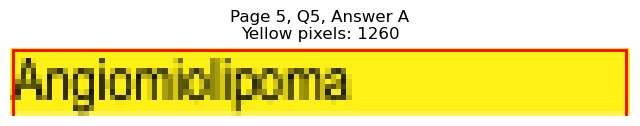

Page 5, Q5 - B: Detected box: x0=82.5, y0=463.7, x1=155.7, y1=476.4
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 355
Page 5, Q5, B: Yellow percentage: 0.0%


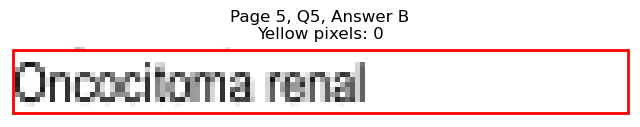

Page 5, Q5 - C: Detected box: x0=82.9, y0=476.3, x1=172.7, y1=489.0
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 454
Page 5, Q5, C: Yellow percentage: 0.0%


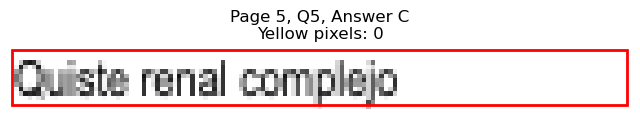

Page 5, Q5 - D: Detected box: x0=334.6, y0=451.1, x1=405.3, y1=463.8
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 364
Page 5, Q5, D: Yellow percentage: 0.0%


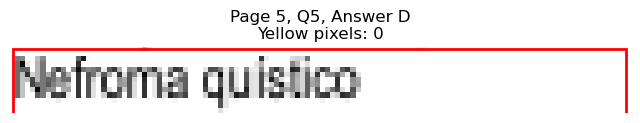

Page 5, Q5 - E: Detected box: x0=334.1, y0=463.7, x1=404.3, y1=476.4
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 378
Page 5, Q5, E: Yellow percentage: 0.0%


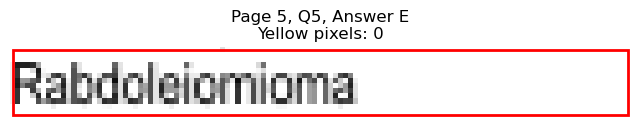


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.5, y0=526.9, x1=173.2, y1=539.5
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 463
Page 5, Q6, A: Yellow percentage: 0.0%


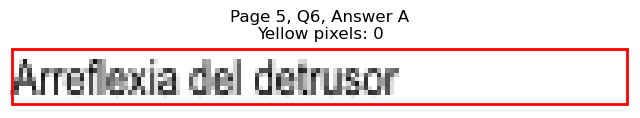

Page 5, Q6 - B: Detected box: x0=82.5, y0=539.5, x1=176.3, y1=552.1
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 503
Page 5, Q6, B: Yellow percentage: 0.0%


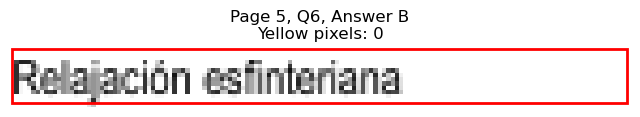

Page 5, Q6 - C: Detected box: x0=82.9, y0=552.2, x1=161.7, y1=564.8
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 387
Page 5, Q6, C: Yellow percentage: 0.0%


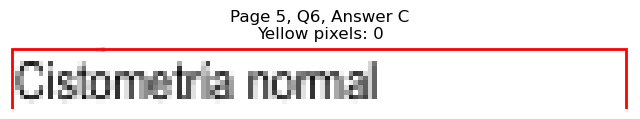

Page 5, Q6 - D: Detected box: x0=334.6, y0=526.9, x1=444.4, y1=539.5
Page 5, Q6, D: Yellow pixels: 1642
Page 5, Q6, D: Total non-white pixels: 2254
Page 5, Q6, D: Yellow percentage: 72.8%


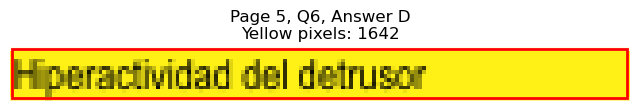

Page 5, Q6 - E: Detected box: x0=334.1, y0=539.5, x1=448.0, y1=552.1
Page 5, Q6, E: Yellow pixels: 165
Page 5, Q6, E: Total non-white pixels: 723
Page 5, Q6, E: Yellow percentage: 22.8%


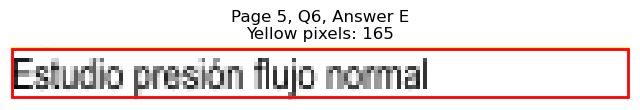


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.5, y0=615.2, x1=183.3, y1=627.8
Page 5, Q7, A: Yellow pixels: 1573
Page 5, Q7, A: Total non-white pixels: 1976
Page 5, Q7, A: Yellow percentage: 79.6%


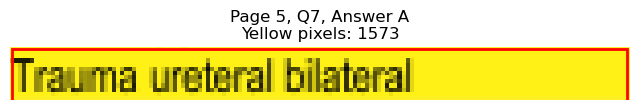

Page 5, Q7 - B: Detected box: x0=82.5, y0=627.9, x1=180.7, y1=640.6
Page 5, Q7, B: Yellow pixels: 149
Page 5, Q7, B: Total non-white pixels: 625
Page 5, Q7, B: Yellow percentage: 23.8%


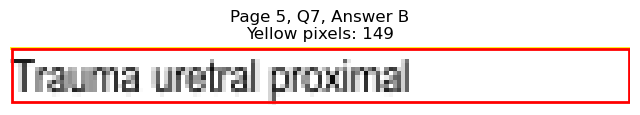

Page 5, Q7 - C: Detected box: x0=82.9, y0=640.5, x1=189.3, y1=653.2
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 529
Page 5, Q7, C: Yellow percentage: 0.0%


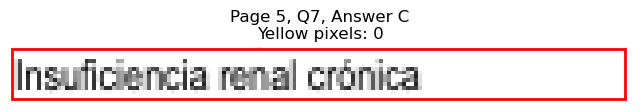

Page 5, Q7 - D: Detected box: x0=334.6, y0=615.2, x1=458.0, y1=627.8
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 640
Page 5, Q7, D: Yellow percentage: 0.0%


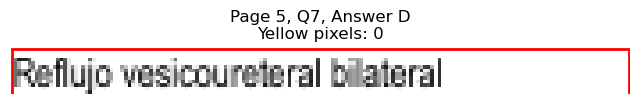

Page 5, Q7 - E: Detected box: x0=334.1, y0=627.9, x1=426.9, y1=640.6
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 437
Page 5, Q7, E: Yellow percentage: 0.0%


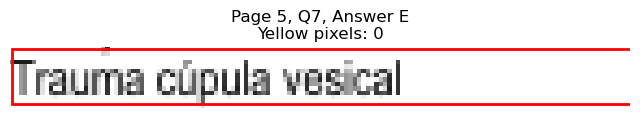


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.5, y0=741.4, x1=148.7, y1=754.1
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 359
Page 5, Q8, A: Yellow percentage: 0.0%


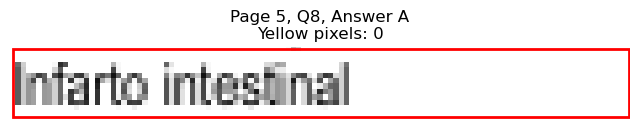

Page 5, Q8 - B: Detected box: x0=82.5, y0=754.0, x1=135.6, y1=766.7
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 278
Page 5, Q8, B: Yellow percentage: 0.0%


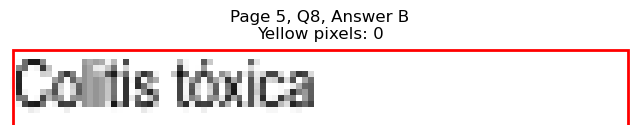

Page 5, Q8 - C: Detected box: x0=82.9, y0=766.8, x1=152.3, y1=779.4
Page 5, Q8, C: Yellow pixels: 1195
Page 5, Q8, C: Total non-white pixels: 1694
Page 5, Q8, C: Yellow percentage: 70.5%


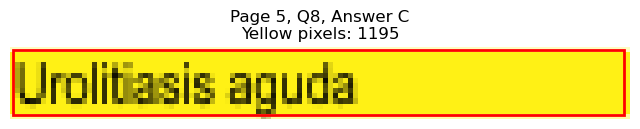

Page 5, Q8 - D: Detected box: x0=334.6, y0=741.4, x1=441.9, y1=754.1
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 545
Page 5, Q8, D: Yellow percentage: 0.0%


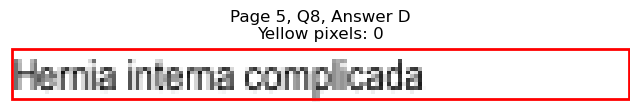

Page 5, Q8 - E: Detected box: x0=334.1, y0=754.0, x1=486.1, y1=766.7
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 735
Page 5, Q8, E: Yellow percentage: 0.0%


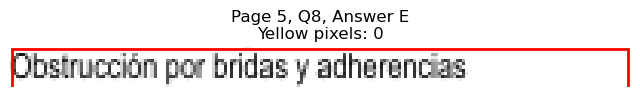


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=257.6, y1=123.0
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 850
Page 6, Q1, A: Yellow percentage: 0.0%


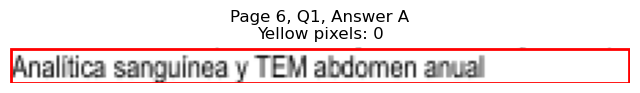

Page 6, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=245.9, y1=135.6
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 802
Page 6, Q1, B: Yellow percentage: 0.0%


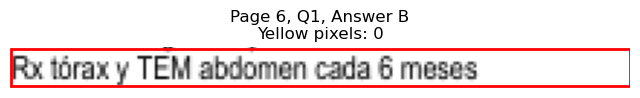

Page 6, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=209.9, y1=148.2
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 612
Page 6, Q1, C: Yellow percentage: 0.0%


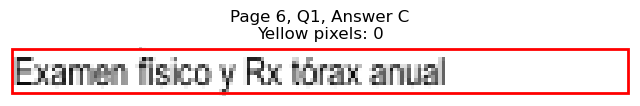

Page 6, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=517.2, y1=123.0
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 1084
Page 6, Q1, D: Yellow percentage: 0.0%


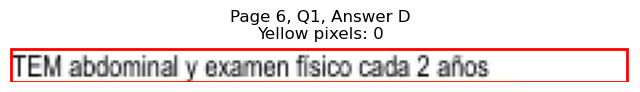

Page 6, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=505.8, y1=135.6
Page 6, Q1, E: Yellow pixels: 1830
Page 6, Q1, E: Total non-white pixels: 2688
Page 6, Q1, E: Yellow percentage: 68.1%


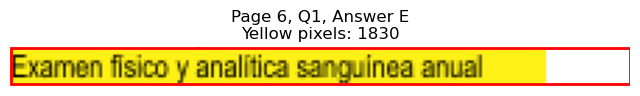


Page 6, Q1 - Selected Answer: E (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=144.1, y1=186.1
Page 6, Q2, A: Yellow pixels: 1218
Page 6, Q2, A: Total non-white pixels: 1582
Page 6, Q2, A: Yellow percentage: 77.0%


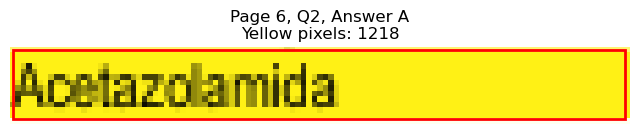

Page 6, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=119.1, y1=198.7
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 268
Page 6, Q2, B: Yellow percentage: 0.0%


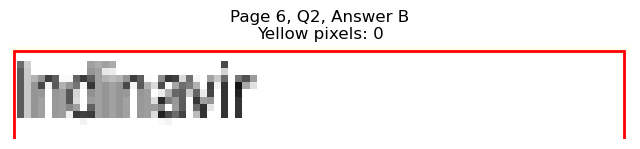

Page 6, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=134.1, y1=211.3
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 235
Page 6, Q2, C: Yellow percentage: 0.0%


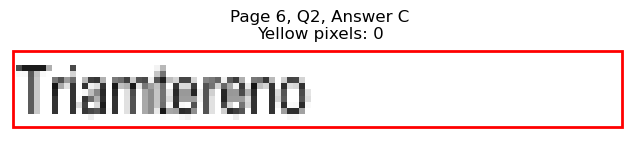

Page 6, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=400.4, y1=186.1
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 348
Page 6, Q2, D: Yellow percentage: 0.0%


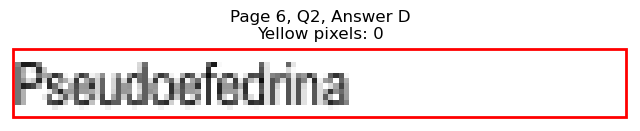

Page 6, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=389.8, y1=198.7
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 295
Page 6, Q2, E: Yellow percentage: 0.0%


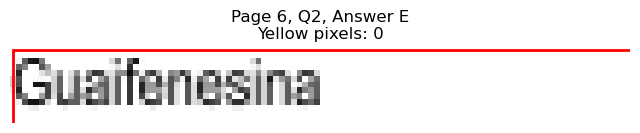


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.5, y0=249.1, x1=182.8, y1=261.8
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 525
Page 6, Q3, A: Yellow percentage: 0.0%


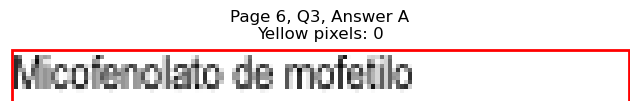

Page 6, Q3 - B: Detected box: x0=82.5, y0=261.7, x1=200.8, y1=274.4
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 596
Page 6, Q3, B: Yellow percentage: 0.0%


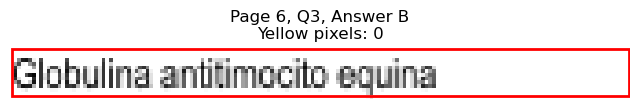

Page 6, Q3 - C: Detected box: x0=82.9, y0=274.5, x1=130.6, y1=287.1
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 254
Page 6, Q3, C: Yellow percentage: 0.0%


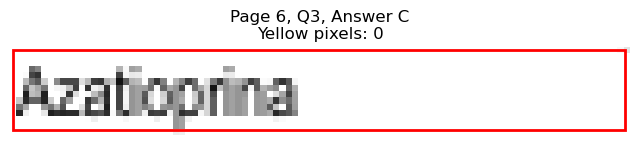

Page 6, Q3 - D: Detected box: x0=334.6, y0=249.1, x1=381.3, y1=261.8
Page 6, Q3, D: Yellow pixels: 1113
Page 6, Q3, D: Total non-white pixels: 1274
Page 6, Q3, D: Yellow percentage: 87.4%


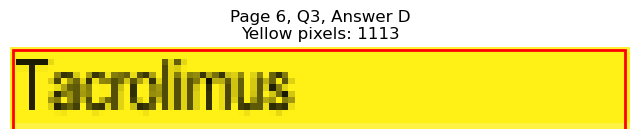

Page 6, Q3 - E: Detected box: x0=334.1, y0=261.7, x1=373.7, y1=274.4
Page 6, Q3, E: Yellow pixels: 90
Page 6, Q3, E: Total non-white pixels: 302
Page 6, Q3, E: Yellow percentage: 29.8%


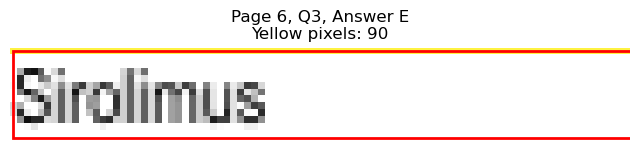


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.5, y0=249.1, x1=136.2, y1=261.8
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 525
Page 6, Q4, A: Yellow percentage: 0.0%


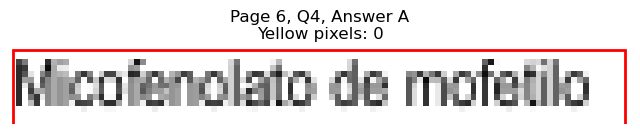

Page 6, Q4 - B: Detected box: x0=82.5, y0=324.9, x1=129.1, y1=337.5
Page 6, Q4, B: Yellow pixels: 1107
Page 6, Q4, B: Total non-white pixels: 1372
Page 6, Q4, B: Yellow percentage: 80.7%


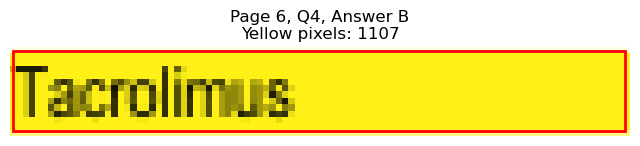

Page 6, Q4 - C: Detected box: x0=82.9, y0=337.5, x1=122.5, y1=350.1
Page 6, Q4, C: Yellow pixels: 91
Page 6, Q4, C: Total non-white pixels: 293
Page 6, Q4, C: Yellow percentage: 31.1%


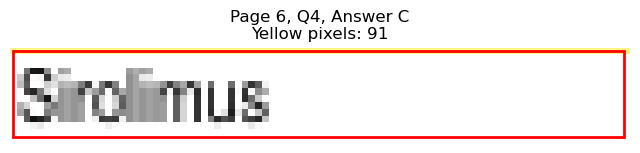

Page 6, Q4 - D: Detected box: x0=334.6, y0=312.3, x1=382.3, y1=324.9
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 246
Page 6, Q4, D: Yellow percentage: 0.0%


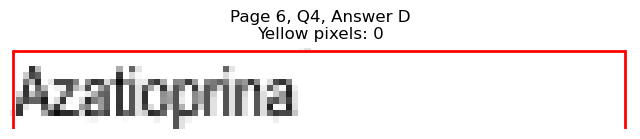

Page 6, Q4 - E: Detected box: x0=334.1, y0=324.9, x1=382.3, y1=337.5
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 273
Page 6, Q4, E: Yellow percentage: 0.0%


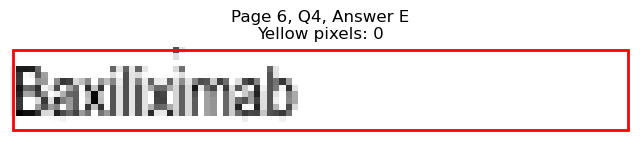


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.5, y0=400.6, x1=244.5, y1=413.3
Page 6, Q5, A: Yellow pixels: 1636
Page 6, Q5, A: Total non-white pixels: 2702
Page 6, Q5, A: Yellow percentage: 60.5%


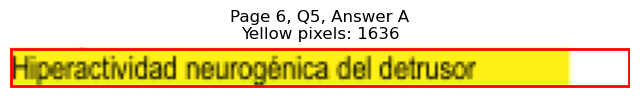

Page 6, Q5 - B: Detected box: x0=82.5, y0=413.3, x1=223.4, y1=426.0
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 932
Page 6, Q5, B: Yellow percentage: 0.0%


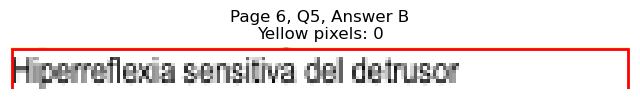

Page 6, Q5 - C: Detected box: x0=82.9, y0=425.9, x1=233.4, y1=438.6
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 804
Page 6, Q5, C: Yellow percentage: 0.0%


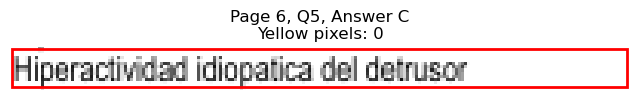

Page 6, Q5 - D: Detected box: x0=334.6, y0=400.6, x1=508.2, y1=413.3
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 946
Page 6, Q5, D: Yellow percentage: 0.0%


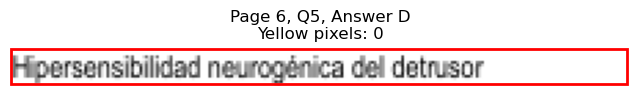

Page 6, Q5 - E: Detected box: x0=334.1, y0=413.3, x1=478.1, y1=426.0
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 759
Page 6, Q5, E: Yellow percentage: 0.0%


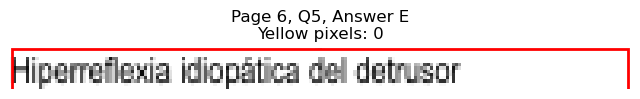


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.5, y0=476.3, x1=126.6, y1=489.0
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 226
Page 6, Q6, A: Yellow percentage: 0.0%


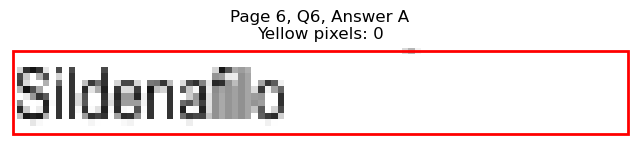

Page 6, Q6 - B: Detected box: x0=82.5, y0=489.1, x1=124.1, y1=501.7
Page 6, Q6, B: Yellow pixels: 1038
Page 6, Q6, B: Total non-white pixels: 1209
Page 6, Q6, B: Yellow percentage: 85.9%


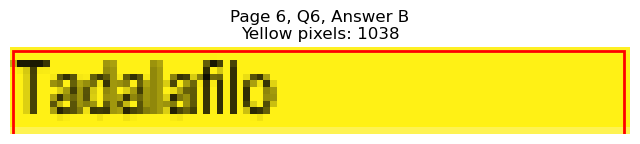

Page 6, Q6 - C: Detected box: x0=82.9, y0=501.7, x1=127.6, y1=514.3
Page 6, Q6, C: Yellow pixels: 96
Page 6, Q6, C: Total non-white pixels: 349
Page 6, Q6, C: Yellow percentage: 27.5%


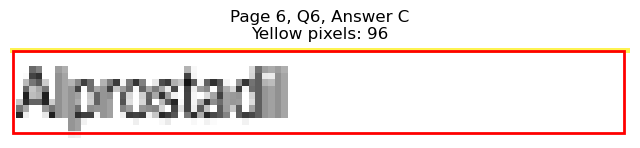

Page 6, Q6 - D: Detected box: x0=334.6, y0=476.3, x1=382.7, y1=489.0
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 252
Page 6, Q6, D: Yellow percentage: 0.0%


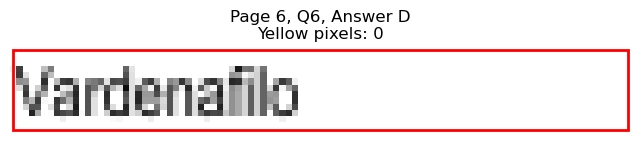

Page 6, Q6 - E: Detected box: x0=334.1, y0=489.1, x1=377.2, y1=501.7
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 225
Page 6, Q6, E: Yellow percentage: 0.0%


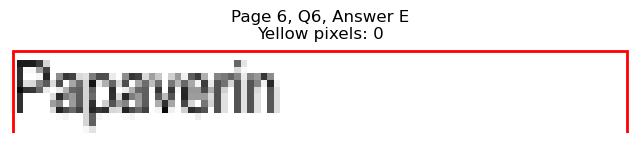


Page 6, Q6 - Selected Answer: B (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.5, y0=552.2, x1=153.6, y1=564.8
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 508
Page 6, Q7, A: Yellow percentage: 0.0%


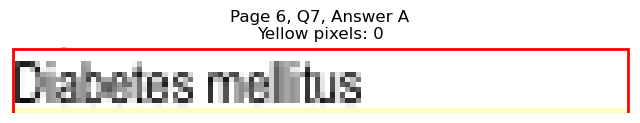

Page 6, Q7 - B: Detected box: x0=82.5, y0=564.8, x1=247.5, y1=577.4
Page 6, Q7, B: Yellow pixels: 1641
Page 6, Q7, B: Total non-white pixels: 2702
Page 6, Q7, B: Yellow percentage: 60.7%


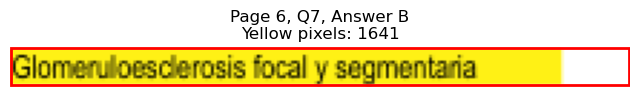

Page 6, Q7 - C: Detected box: x0=82.9, y0=577.4, x1=134.8, y1=590.0
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 563
Page 6, Q7, C: Yellow percentage: 0.0%


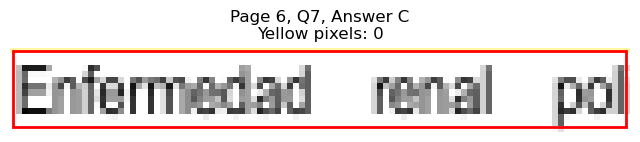

Page 6, Q7 - D: Detected box: x0=334.6, y0=552.2, x1=395.3, y1=564.8
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 307
Page 6, Q7, D: Yellow percentage: 0.0%


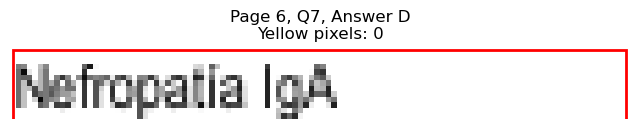

Page 6, Q7 - E: Detected box: x0=334.1, y0=564.8, x1=395.8, y1=577.4
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 339
Page 6, Q7, E: Yellow percentage: 0.0%


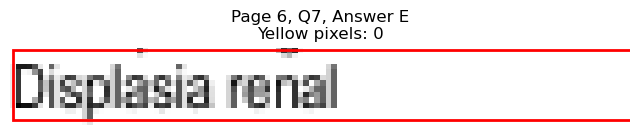


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.5, y0=653.1, x1=199.0, y1=665.8
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 580
Page 6, Q8, A: Yellow percentage: 0.0%


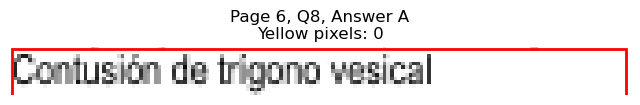

Page 6, Q8 - B: Detected box: x0=82.5, y0=665.7, x1=182.8, y1=678.4
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 506
Page 6, Q8, B: Yellow percentage: 0.0%


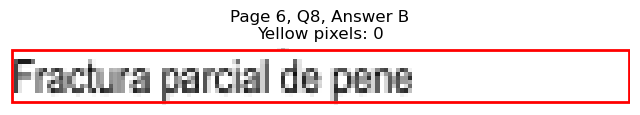

Page 6, Q8 - C: Detected box: x0=82.9, y0=678.3, x1=182.2, y1=691.0
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 472
Page 6, Q8, C: Yellow percentage: 0.0%


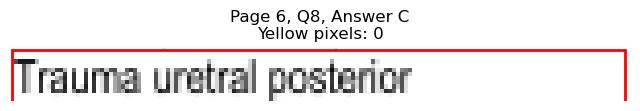

Page 6, Q8 - D: Detected box: x0=334.6, y0=653.1, x1=429.4, y1=665.8
Page 6, Q8, D: Yellow pixels: 1541
Page 6, Q8, D: Total non-white pixels: 1898
Page 6, Q8, D: Yellow percentage: 81.2%


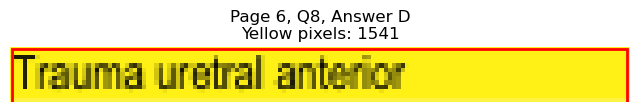

Page 6, Q8 - E: Detected box: x0=334.1, y0=665.7, x1=468.6, y1=678.4
Page 6, Q8, E: Yellow pixels: 185
Page 6, Q8, E: Total non-white pixels: 869
Page 6, Q8, E: Yellow percentage: 21.3%


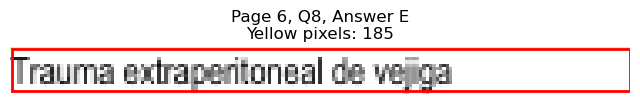


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=82.5, y0=728.9, x1=166.2, y1=741.5
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 433
Page 6, Q9, A: Yellow percentage: 0.0%


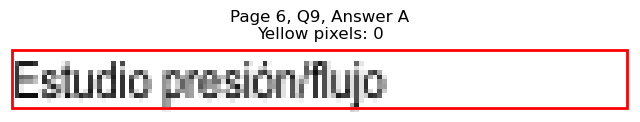

Page 6, Q9 - B: Detected box: x0=82.5, y0=741.4, x1=131.1, y1=754.1
Page 6, Q9, B: Yellow pixels: 100
Page 6, Q9, B: Total non-white pixels: 354
Page 6, Q9, B: Yellow percentage: 28.2%


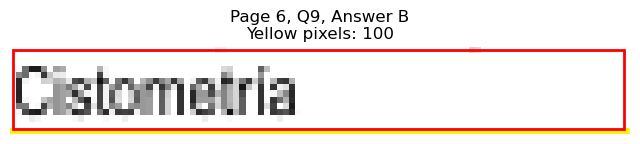

Page 6, Q9 - C: Detected box: x0=82.9, y0=754.0, x1=142.1, y1=766.7
Page 6, Q9, C: Yellow pixels: 1199
Page 6, Q9, C: Total non-white pixels: 1443
Page 6, Q9, C: Yellow percentage: 83.1%


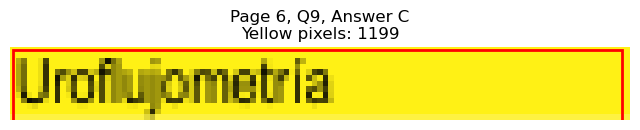

Page 6, Q9 - D: Detected box: x0=334.6, y0=728.9, x1=402.8, y1=741.5
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 357
Page 6, Q9, D: Yellow percentage: 0.0%


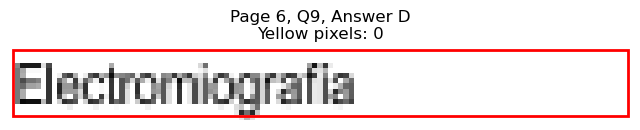

Page 6, Q9 - E: Detected box: x0=334.1, y0=741.4, x1=427.5, y1=754.1
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 473
Page 6, Q9, E: Yellow percentage: 0.0%


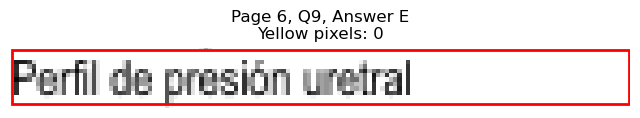


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=157.2, y1=123.0
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 365
Page 7, Q1, A: Yellow percentage: 0.0%


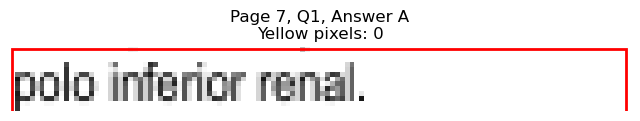

Page 7, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=179.2, y1=135.6
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 487
Page 7, Q1, B: Yellow percentage: 0.0%


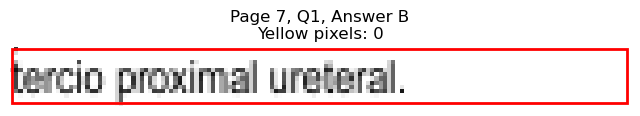

Page 7, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=143.7, y1=148.2
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 269
Page 7, Q1, C: Yellow percentage: 0.0%


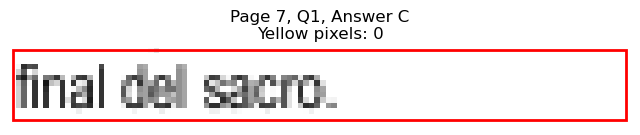

Page 7, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=410.3, y1=123.0
Page 7, Q1, D: Yellow pixels: 1376
Page 7, Q1, D: Total non-white pixels: 1651
Page 7, Q1, D: Yellow percentage: 83.3%


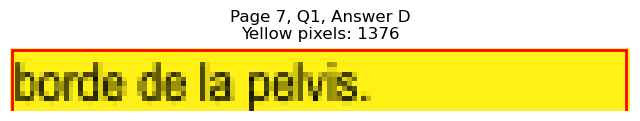

Page 7, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=419.9, y1=135.6
Page 7, Q1, E: Yellow pixels: 135
Page 7, Q1, E: Total non-white pixels: 571
Page 7, Q1, E: Yellow percentage: 23.6%


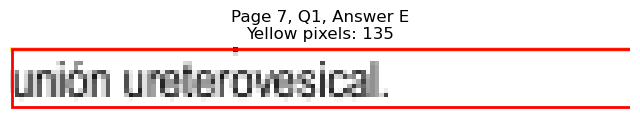


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=138.1, y1=186.1
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 294
Page 7, Q2, A: Yellow percentage: 0.0%


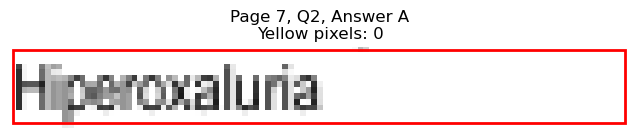

Page 7, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=145.6, y1=198.7
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 337
Page 7, Q2, B: Yellow percentage: 0.0%


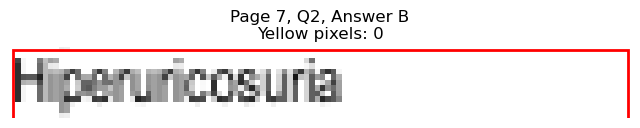

Page 7, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=138.6, y1=211.3
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 299
Page 7, Q2, C: Yellow percentage: 0.0%


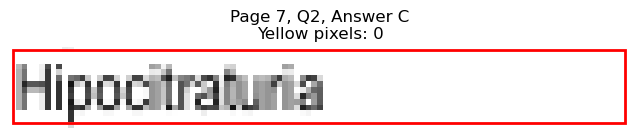

Page 7, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=391.7, y1=186.1
Page 7, Q2, D: Yellow pixels: 1149
Page 7, Q2, D: Total non-white pixels: 1512
Page 7, Q2, D: Yellow percentage: 76.0%


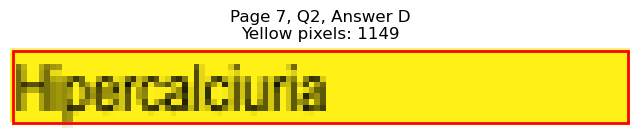

Page 7, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=401.9, y1=198.7
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 508
Page 7, Q2, E: Yellow percentage: 0.0%


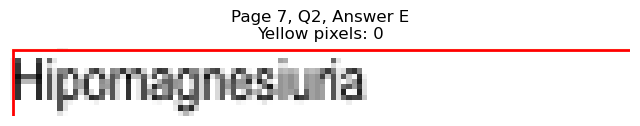


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.5, y0=249.1, x1=125.1, y1=261.8
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 192
Page 7, Q3, A: Yellow percentage: 0.0%


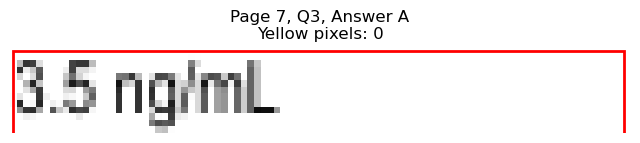

Page 7, Q3 - B: Detected box: x0=82.5, y0=261.7, x1=125.1, y1=274.4
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 193
Page 7, Q3, B: Yellow percentage: 0.0%


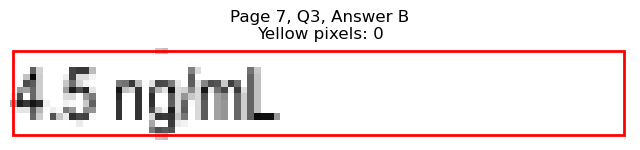

Page 7, Q3 - C: Detected box: x0=82.9, y0=274.5, x1=118.1, y1=287.1
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 142
Page 7, Q3, C: Yellow percentage: 0.0%


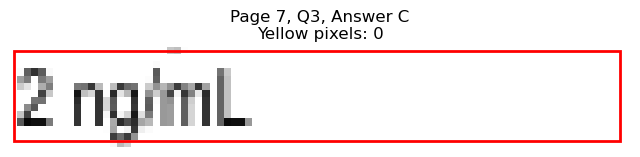

Page 7, Q3 - D: Detected box: x0=334.6, y0=249.1, x1=369.8, y1=261.8
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 244
Page 7, Q3, D: Yellow percentage: 0.0%


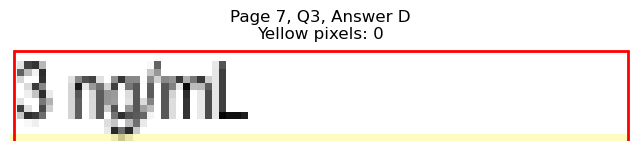

Page 7, Q3 - E: Detected box: x0=334.1, y0=261.7, x1=376.7, y1=274.4
Page 7, Q3, E: Yellow pixels: 1061
Page 7, Q3, E: Total non-white pixels: 1302
Page 7, Q3, E: Yellow percentage: 81.5%


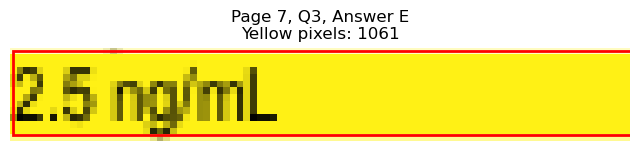


Page 7, Q3 - Selected Answer: E (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.5, y0=312.3, x1=139.6, y1=324.9
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 313
Page 7, Q4, A: Yellow percentage: 0.0%


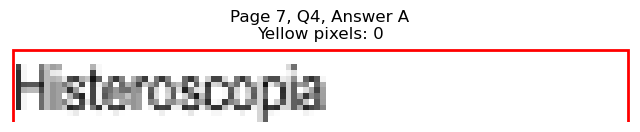

Page 7, Q4 - B: Detected box: x0=82.5, y0=324.9, x1=131.7, y1=337.5
Page 7, Q4, B: Yellow pixels: 100
Page 7, Q4, B: Total non-white pixels: 372
Page 7, Q4, B: Yellow percentage: 26.9%


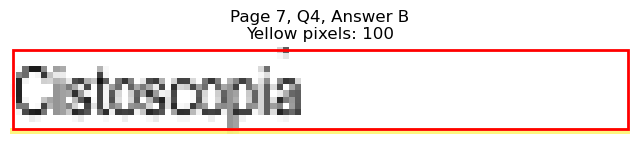

Page 7, Q4 - C: Detected box: x0=82.9, y0=337.5, x1=119.5, y1=350.1
Page 7, Q4, C: Yellow pixels: 991
Page 7, Q4, C: Total non-white pixels: 1232
Page 7, Q4, C: Yellow percentage: 80.4%


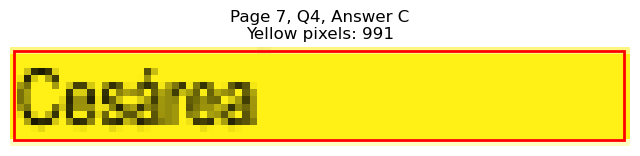

Page 7, Q4 - D: Detected box: x0=334.6, y0=312.3, x1=370.3, y1=324.9
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 176
Page 7, Q4, D: Yellow percentage: 0.0%


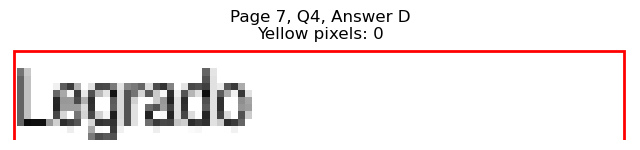

Page 7, Q4 - E: Detected box: x0=334.1, y0=324.9, x1=391.9, y1=337.5
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 300
Page 7, Q4, E: Yellow percentage: 0.0%


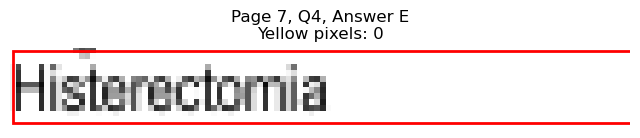


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.5, y0=400.6, x1=119.5, y1=413.3
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 192
Page 7, Q5, A: Yellow percentage: 0.0%


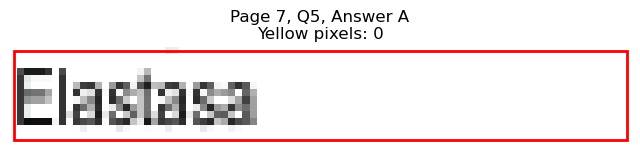

Page 7, Q5 - B: Detected box: x0=82.5, y0=413.3, x1=149.2, y1=426.0
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 368
Page 7, Q5, B: Yellow percentage: 0.0%


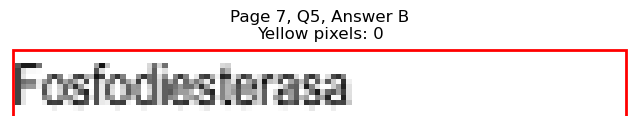

Page 7, Q5 - C: Detected box: x0=82.9, y0=425.9, x1=105.0, y1=438.6
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 102
Page 7, Q5, C: Yellow percentage: 0.0%


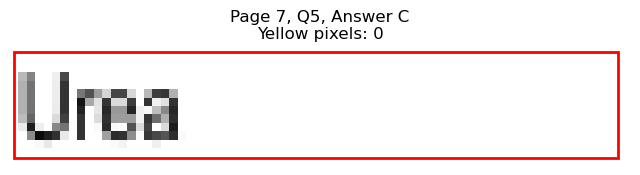

Page 7, Q5 - D: Detected box: x0=334.6, y0=400.6, x1=383.2, y1=413.3
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 267
Page 7, Q5, D: Yellow percentage: 0.0%


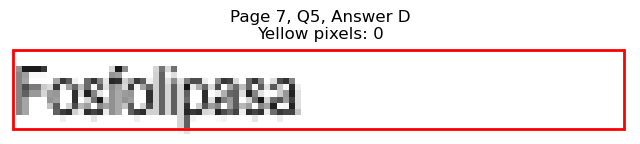

Page 7, Q5 - E: Detected box: x0=334.1, y0=413.3, x1=365.7, y1=426.0
Page 7, Q5, E: Yellow pixels: 952
Page 7, Q5, E: Total non-white pixels: 1066
Page 7, Q5, E: Yellow percentage: 89.3%


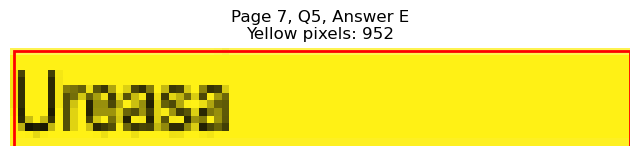


Page 7, Q5 - Selected Answer: E (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.5, y0=476.3, x1=131.1, y1=489.0
Page 7, Q6, A: Yellow pixels: 1098
Page 7, Q6, A: Total non-white pixels: 1400
Page 7, Q6, A: Yellow percentage: 78.4%


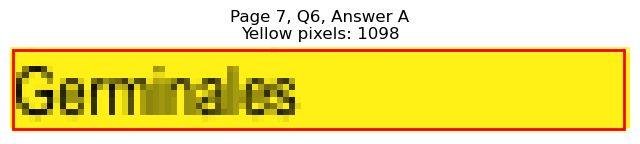

Page 7, Q6 - B: Detected box: x0=82.5, y0=489.1, x1=110.5, y1=501.7
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 232
Page 7, Q6, B: Yellow percentage: 0.0%


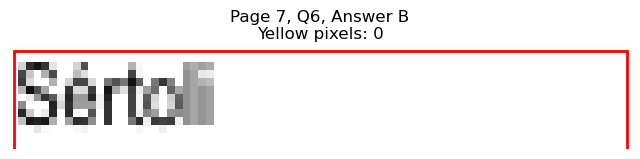

Page 7, Q6 - C: Detected box: x0=82.9, y0=501.7, x1=112.1, y1=514.3
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 141
Page 7, Q6, C: Yellow percentage: 0.0%


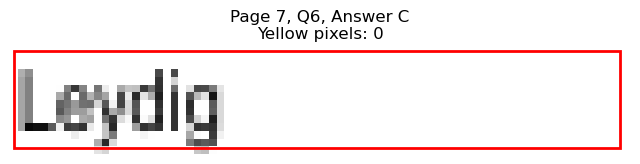

Page 7, Q6 - D: Detected box: x0=334.6, y0=476.3, x1=368.2, y1=489.0
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 175
Page 7, Q6, D: Yellow percentage: 0.0%


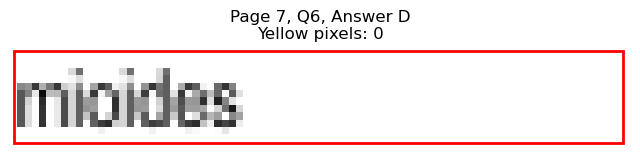

Page 7, Q6 - E: Detected box: x0=334.1, y0=489.1, x1=409.9, y1=501.7
Page 7, Q6, E: Yellow pixels: 0
Page 7, Q6, E: Total non-white pixels: 422
Page 7, Q6, E: Yellow percentage: 0.0%


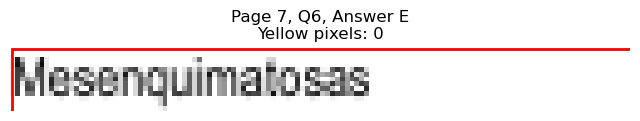


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.5, y0=564.8, x1=139.1, y1=577.4
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 285
Page 7, Q7, A: Yellow percentage: 0.0%


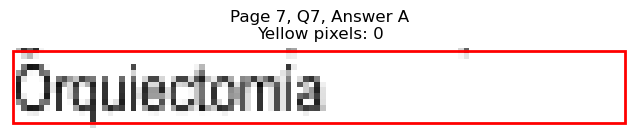

Page 7, Q7 - B: Detected box: x0=82.5, y0=577.4, x1=213.9, y1=590.0
Page 7, Q7, B: Yellow pixels: 182
Page 7, Q7, B: Total non-white pixels: 1020
Page 7, Q7, B: Yellow percentage: 17.8%


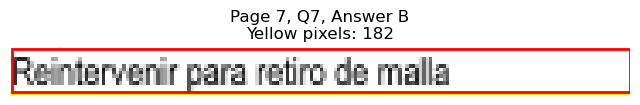

Page 7, Q7 - C: Detected box: x0=82.9, y0=590.0, x1=209.4, y1=602.6
Page 7, Q7, C: Yellow pixels: 1779
Page 7, Q7, C: Total non-white pixels: 2492
Page 7, Q7, C: Yellow percentage: 71.4%


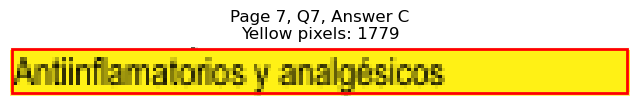

Page 7, Q7 - D: Detected box: x0=334.6, y0=564.8, x1=421.5, y1=577.4
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 458
Page 7, Q7, D: Yellow percentage: 0.0%


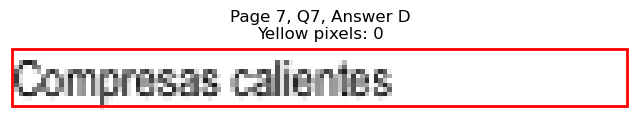

Page 7, Q7 - E: Detected box: x0=334.1, y0=577.4, x1=402.8, y1=590.0
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 348
Page 7, Q7, E: Yellow percentage: 0.0%


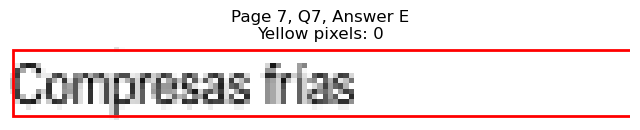


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.5, y0=640.5, x1=131.1, y1=653.2
Page 7, Q8, A: Yellow pixels: 100
Page 7, Q8, A: Total non-white pixels: 317
Page 7, Q8, A: Yellow percentage: 31.5%


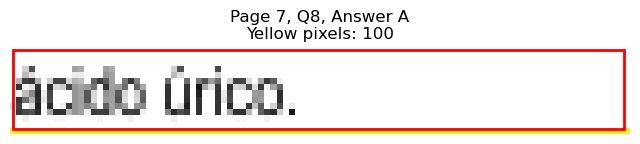

Page 7, Q8 - B: Detected box: x0=82.5, y0=653.1, x1=121.1, y1=665.8
Page 7, Q8, B: Yellow pixels: 1038
Page 7, Q8, B: Total non-white pixels: 1170
Page 7, Q8, B: Yellow percentage: 88.7%


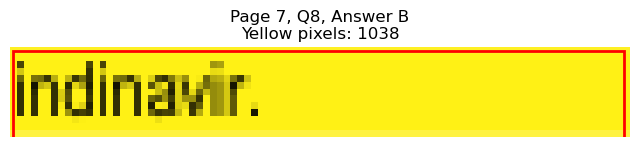

Page 7, Q8 - C: Detected box: x0=82.9, y0=665.7, x1=113.5, y1=678.4
Page 7, Q8, C: Yellow pixels: 82
Page 7, Q8, C: Total non-white pixels: 210
Page 7, Q8, C: Yellow percentage: 39.0%


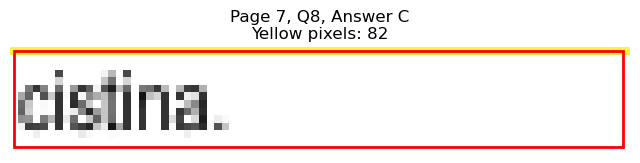

Page 7, Q8 - D: Detected box: x0=334.6, y0=640.5, x1=382.7, y1=653.2
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 239
Page 7, Q8, D: Yellow percentage: 0.0%


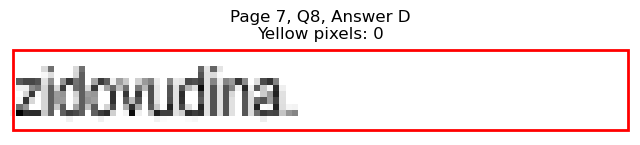

Page 7, Q8 - E: Detected box: x0=334.1, y0=653.1, x1=378.3, y1=665.8
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 223
Page 7, Q8, E: Yellow percentage: 0.0%


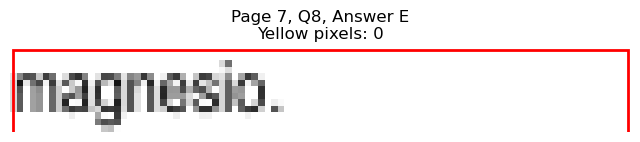


Page 7, Q8 - Selected Answer: B (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=82.5, y0=716.3, x1=267.3, y1=728.9
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 894
Page 7, Q9, A: Yellow percentage: 0.0%


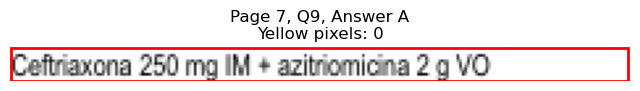

Page 7, Q9 - B: Detected box: x0=82.5, y0=728.9, x1=265.2, y1=741.5
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 891
Page 7, Q9, B: Yellow percentage: 0.0%


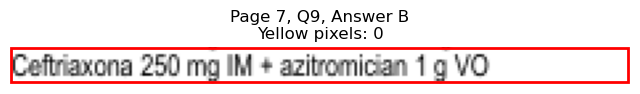

Page 7, Q9 - C: Detected box: x0=82.9, y0=741.4, x1=265.7, y1=754.1
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 846
Page 7, Q9, C: Yellow percentage: 0.0%


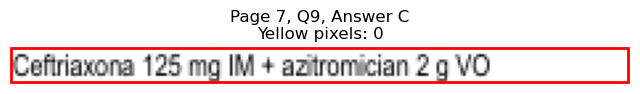

Page 7, Q9 - D: Detected box: x0=334.6, y0=716.3, x1=526.9, y1=728.9
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 874
Page 7, Q9, D: Yellow percentage: 0.0%


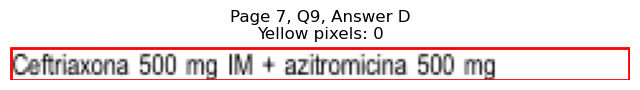

Page 7, Q9 - E: Detected box: x0=334.1, y0=741.4, x1=514.5, y1=754.1
Page 7, Q9, E: Yellow pixels: 1859
Page 7, Q9, E: Total non-white pixels: 2688
Page 7, Q9, E: Yellow percentage: 69.2%


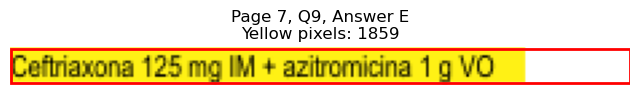


Page 7, Q9 - Selected Answer: E (based on yellow pixel count)





Page 8: Found 8 questions
Page 8, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=191.8, y1=123.0
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 569
Page 8, Q1, A: Yellow percentage: 0.0%


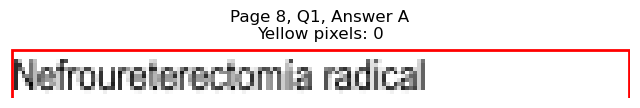

Page 8, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=265.5, y1=135.6
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 880
Page 8, Q1, B: Yellow percentage: 0.0%


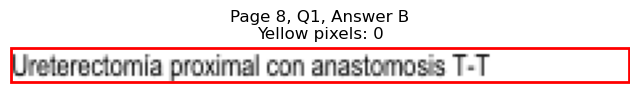

Page 8, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=215.4, y1=148.2
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 667
Page 8, Q1, C: Yellow percentage: 0.0%


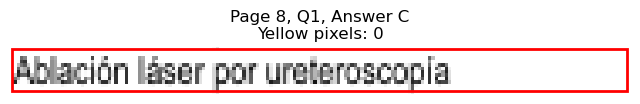

Page 8, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=471.6, y1=123.0
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 863
Page 8, Q1, D: Yellow percentage: 0.0%


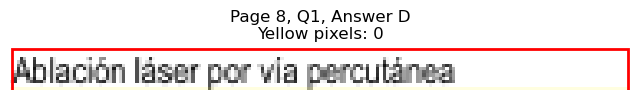

Page 8, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=414.4, y1=135.6
Page 8, Q1, E: Yellow pixels: 1237
Page 8, Q1, E: Total non-white pixels: 1834
Page 8, Q1, E: Yellow percentage: 67.4%


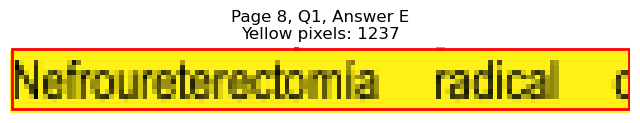


Page 8, Q1 - Selected Answer: E (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=232.4, y1=224.0
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 765
Page 8, Q2, A: Yellow percentage: 0.0%


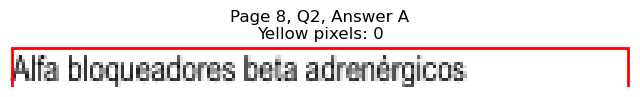

Page 8, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=128.7, y1=236.6
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 213
Page 8, Q2, B: Yellow percentage: 0.0%


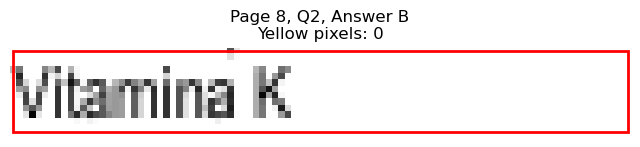

Page 8, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=156.1, y1=249.2
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 409
Page 8, Q2, C: Yellow percentage: 0.0%


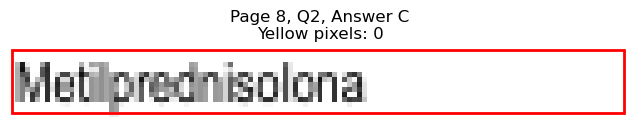

Page 8, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=384.3, y1=224.0
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 361
Page 8, Q2, D: Yellow percentage: 0.0%


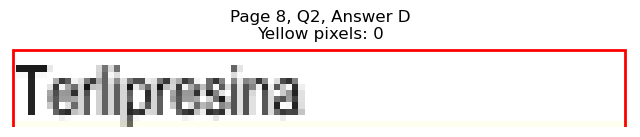

Page 8, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=484.1, y1=236.6
Page 8, Q2, E: Yellow pixels: 1917
Page 8, Q2, E: Total non-white pixels: 2688
Page 8, Q2, E: Yellow percentage: 71.3%


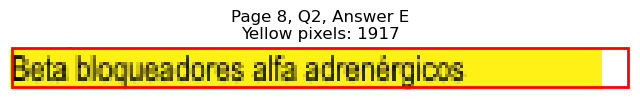


Page 8, Q2 - Selected Answer: E (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=176.8, y1=312.3
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 498
Page 8, Q3, A: Yellow percentage: 0.0%


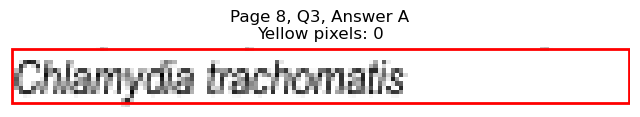

Page 8, Q3 - B: Detected box: x0=82.5, y0=312.3, x1=161.7, y1=324.9
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 416
Page 8, Q3, B: Yellow percentage: 0.0%


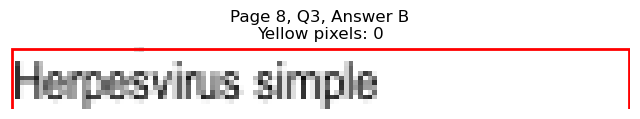

Page 8, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=175.2, y1=337.5
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 463
Page 8, Q3, C: Yellow percentage: 0.0%


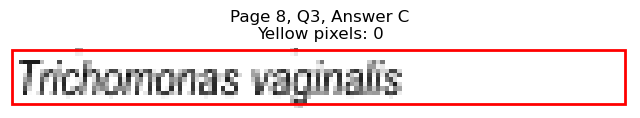

Page 8, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=428.5, y1=312.3
Page 8, Q3, D: Yellow pixels: 1346
Page 8, Q3, D: Total non-white pixels: 2030
Page 8, Q3, D: Yellow percentage: 66.3%


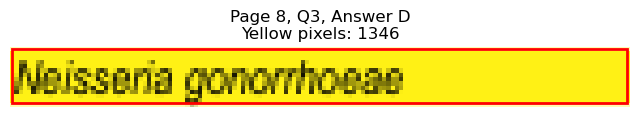

Page 8, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=431.0, y1=324.9
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 652
Page 8, Q3, E: Yellow percentage: 0.0%


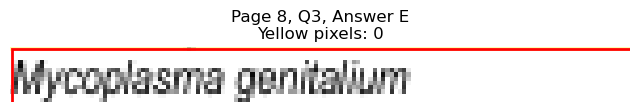


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.5, y0=362.8, x1=131.5, y1=375.5
Page 8, Q4, A: Yellow pixels: 100
Page 8, Q4, A: Total non-white pixels: 367
Page 8, Q4, A: Yellow percentage: 27.2%


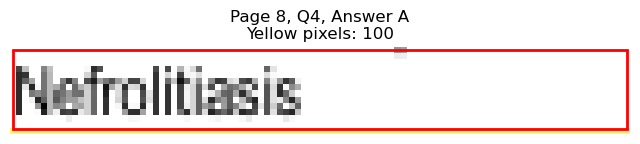

Page 8, Q4 - B: Detected box: x0=82.5, y0=375.4, x1=268.1, y1=388.1
Page 8, Q4, B: Yellow pixels: 1783
Page 8, Q4, B: Total non-white pixels: 2701
Page 8, Q4, B: Yellow percentage: 66.0%


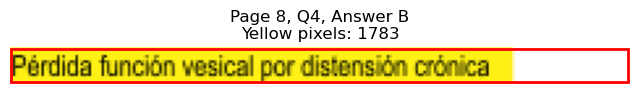

Page 8, Q4 - C: Detected box: x0=82.9, y0=388.0, x1=149.7, y1=400.7
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 430
Page 8, Q4, C: Yellow percentage: 0.0%


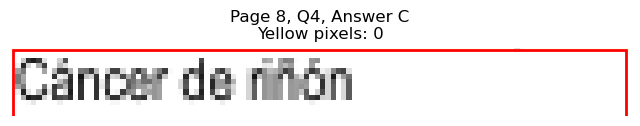

Page 8, Q4 - D: Detected box: x0=334.6, y0=362.8, x1=404.8, y1=375.5
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 363
Page 8, Q4, D: Yellow percentage: 0.0%


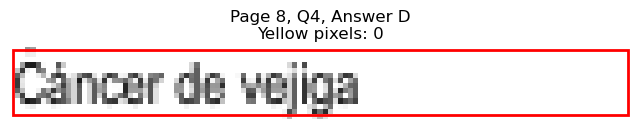

Page 8, Q4 - E: Detected box: x0=334.1, y0=375.4, x1=423.9, y1=388.1
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 485
Page 8, Q4, E: Yellow percentage: 0.0%


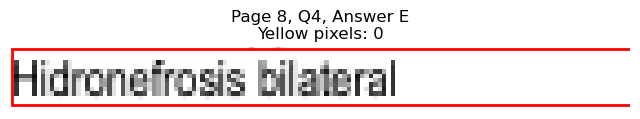


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.5, y0=451.1, x1=159.7, y1=463.8
Page 8, Q5, A: Yellow pixels: 1
Page 8, Q5, A: Total non-white pixels: 524
Page 8, Q5, A: Yellow percentage: 0.2%


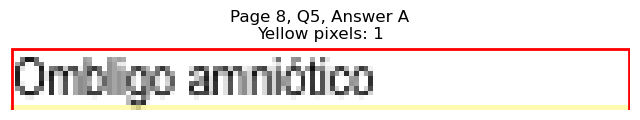

Page 8, Q5 - B: Detected box: x0=82.5, y0=463.7, x1=264.0, y1=476.4
Page 8, Q5, B: Yellow pixels: 1560
Page 8, Q5, B: Total non-white pixels: 2702
Page 8, Q5, B: Yellow percentage: 57.7%


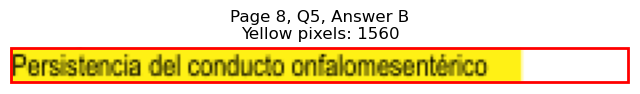

Page 8, Q5 - C: Detected box: x0=82.9, y0=476.3, x1=128.5, y1=489.0
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 328
Page 8, Q5, C: Yellow percentage: 0.0%


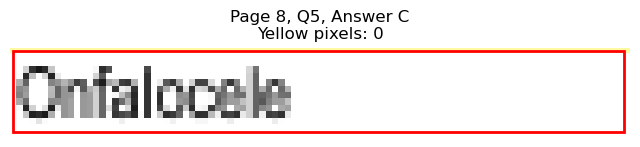

Page 8, Q5 - D: Detected box: x0=334.6, y0=451.1, x1=419.3, y1=463.8
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 435
Page 8, Q5, D: Yellow percentage: 0.0%


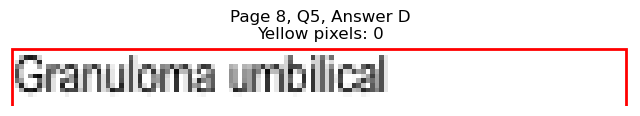

Page 8, Q5 - E: Detected box: x0=334.1, y0=463.7, x1=429.4, y1=476.4
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 464
Page 8, Q5, E: Yellow percentage: 0.0%


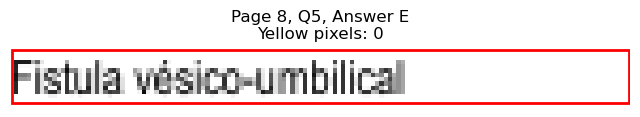


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=99.4, y0=514.3, x1=147.6, y1=526.9
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 474
Page 8, Q6, A: Yellow percentage: 0.0%


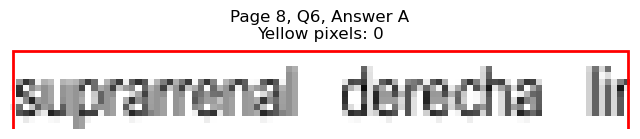

Page 8, Q6 - B: Detected box: x0=98.6, y0=539.5, x1=146.9, y1=552.1
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 480
Page 8, Q6, B: Yellow percentage: 0.0%


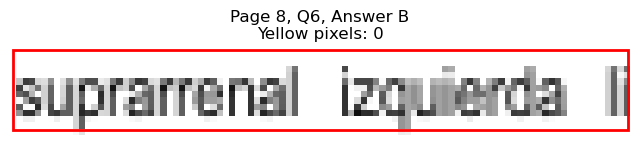

Page 8, Q6 - C: Detected box: x0=225.7, y0=564.8, x1=262.9, y1=577.4
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 238
Page 8, Q6, C: Yellow percentage: 0.0%


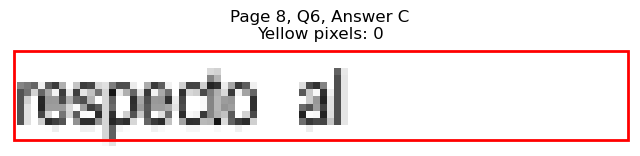

Page 8, Q6 - D: Detected box: x0=477.4, y0=514.3, x1=514.6, y1=526.9
Page 8, Q6, D: Yellow pixels: 461
Page 8, Q6, D: Total non-white pixels: 637
Page 8, Q6, D: Yellow percentage: 72.4%


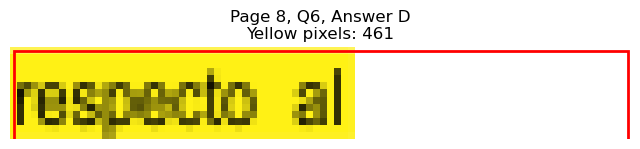

Page 8, Q6 - E: Detected box: x0=350.3, y0=539.5, x1=398.5, y1=552.1
Page 8, Q6, E: Yellow pixels: 98
Page 8, Q6, E: Total non-white pixels: 594
Page 8, Q6, E: Yellow percentage: 16.5%


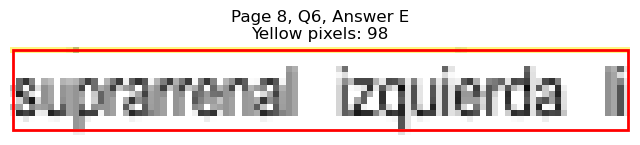


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.5, y0=615.2, x1=127.1, y1=627.8
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 215
Page 8, Q7, A: Yellow percentage: 0.0%


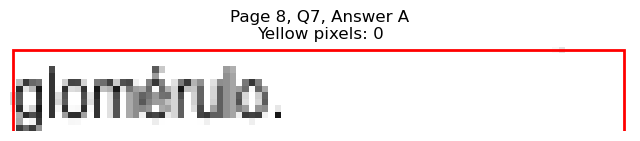

Page 8, Q7 - B: Detected box: x0=82.5, y0=627.9, x1=148.7, y1=640.6
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 350
Page 8, Q7, B: Yellow percentage: 0.0%


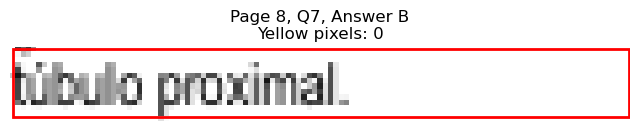

Page 8, Q7 - C: Detected box: x0=82.9, y0=640.5, x1=136.1, y1=653.2
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 255
Page 8, Q7, C: Yellow percentage: 0.0%


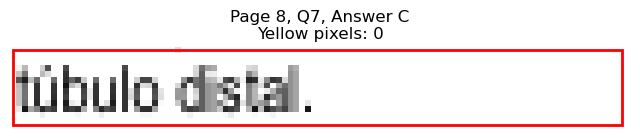

Page 8, Q7 - D: Detected box: x0=334.6, y0=615.2, x1=392.8, y1=627.8
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 275
Page 8, Q7, D: Yellow percentage: 0.0%


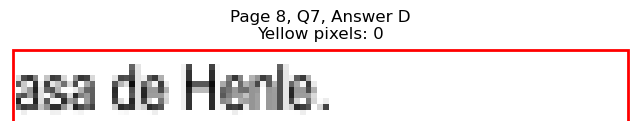

Page 8, Q7 - E: Detected box: x0=334.1, y0=627.9, x1=369.8, y1=640.6
Page 8, Q7, E: Yellow pixels: 998
Page 8, Q7, E: Total non-white pixels: 1204
Page 8, Q7, E: Yellow percentage: 82.9%


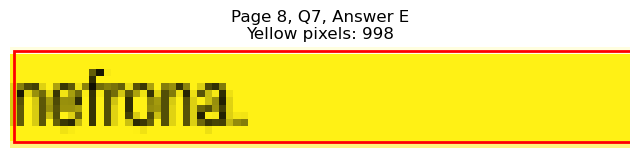


Page 8, Q7 - Selected Answer: E (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.5, y0=716.3, x1=345.8, y1=728.9
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 1310
Page 8, Q8, A: Yellow percentage: 0.0%


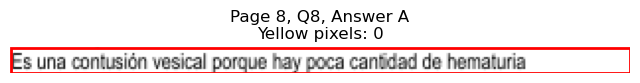

Page 8, Q8 - B: Detected box: x0=82.5, y0=728.9, x1=404.0, y1=741.5
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 1549
Page 8, Q8, B: Yellow percentage: 0.0%


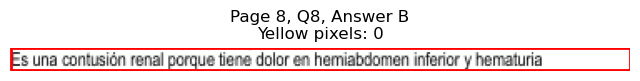

Page 8, Q8 - C: Detected box: x0=82.9, y0=741.4, x1=461.0, y1=754.1
Page 8, Q8, C: Yellow pixels: 429
Page 8, Q8, C: Total non-white pixels: 2339
Page 8, Q8, C: Yellow percentage: 18.3%


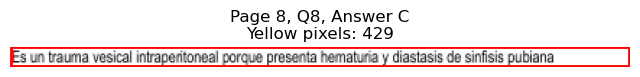

Page 8, Q8 - D: Detected box: x0=82.9, y0=754.0, x1=459.1, y1=766.7
Page 8, Q8, D: Yellow pixels: 4091
Page 8, Q8, D: Total non-white pixels: 5564
Page 8, Q8, D: Yellow percentage: 73.5%


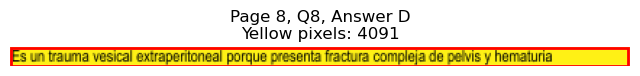

Page 8, Q8 - E: Detected box: x0=82.5, y0=766.8, x1=365.9, y1=779.4
Page 8, Q8, E: Yellow pixels: 332
Page 8, Q8, E: Total non-white pixels: 1729
Page 8, Q8, E: Yellow percentage: 19.2%


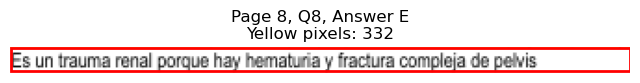


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)





Page 9: Found 7 questions
Page 9, Q1 - A: Detected box: x0=82.5, y0=135.5, x1=185.3, y1=148.2
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 510
Page 9, Q1, A: Yellow percentage: 0.0%


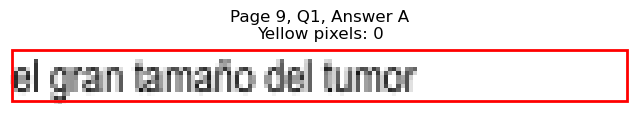

Page 9, Q1 - B: Detected box: x0=82.5, y0=148.2, x1=220.4, y1=160.9
Page 9, Q1, B: Yellow pixels: 1963
Page 9, Q1, B: Total non-white pixels: 2457
Page 9, Q1, B: Yellow percentage: 79.9%


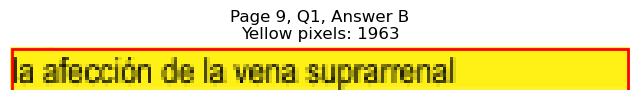

Page 9, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=173.8, y1=173.5
Page 9, Q1, C: Yellow pixels: 141
Page 9, Q1, C: Total non-white pixels: 601
Page 9, Q1, C: Yellow percentage: 23.5%


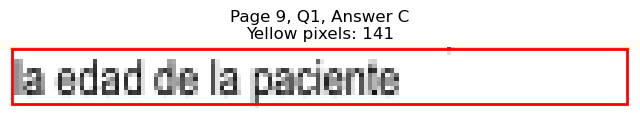

Page 9, Q1 - D: Detected box: x0=334.6, y0=135.5, x1=442.5, y1=148.2
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 551
Page 9, Q1, D: Yellow percentage: 0.0%


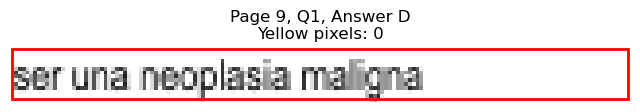

Page 9, Q1 - E: Detected box: x0=334.1, y0=148.2, x1=473.6, y1=160.9
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 671
Page 9, Q1, E: Yellow percentage: 0.0%


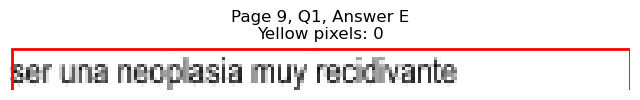


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.5, y0=223.9, x1=143.2, y1=236.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 317
Page 9, Q2, A: Yellow percentage: 0.0%


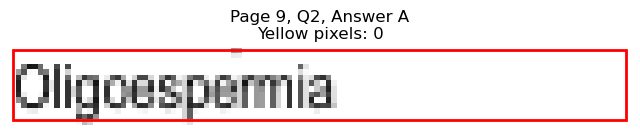

Page 9, Q2 - B: Detected box: x0=82.5, y0=236.5, x1=148.1, y1=249.2
Page 9, Q2, B: Yellow pixels: 117
Page 9, Q2, B: Total non-white pixels: 468
Page 9, Q2, B: Yellow percentage: 25.0%


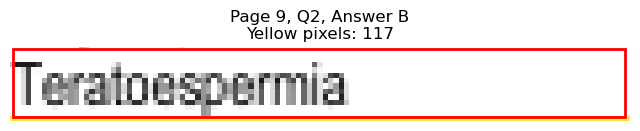

Page 9, Q2 - C: Detected box: x0=82.9, y0=249.1, x1=145.6, y1=261.8
Page 9, Q2, C: Yellow pixels: 1225
Page 9, Q2, C: Total non-white pixels: 1482
Page 9, Q2, C: Yellow percentage: 82.7%


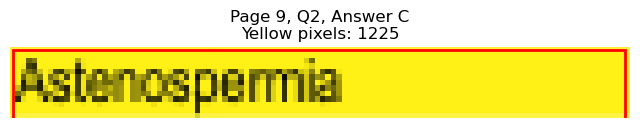

Page 9, Q2 - D: Detected box: x0=334.6, y0=223.9, x1=392.8, y1=236.6
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 314
Page 9, Q2, D: Yellow percentage: 0.0%


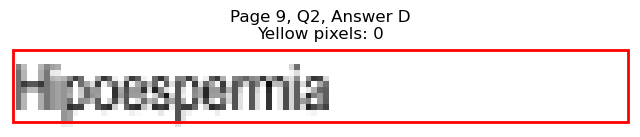

Page 9, Q2 - E: Detected box: x0=334.1, y0=236.5, x1=388.9, y1=249.2
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 297
Page 9, Q2, E: Yellow percentage: 0.0%


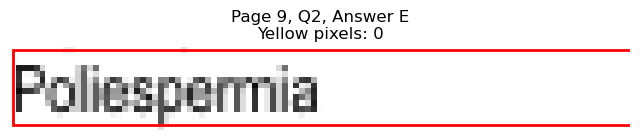


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.5, y0=350.2, x1=169.2, y1=362.9
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 439
Page 9, Q3, A: Yellow percentage: 0.0%


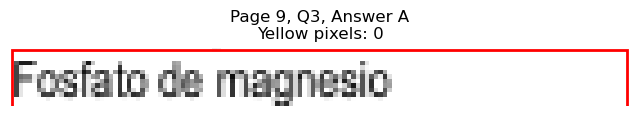

Page 9, Q3 - B: Detected box: x0=82.5, y0=362.8, x1=159.7, y1=375.5
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 380
Page 9, Q3, B: Yellow percentage: 0.0%


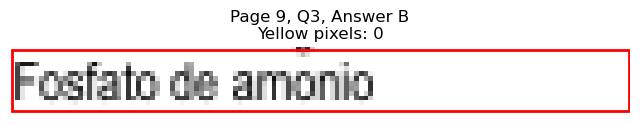

Page 9, Q3 - C: Detected box: x0=82.9, y0=375.4, x1=171.3, y1=388.1
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 470
Page 9, Q3, C: Yellow percentage: 0.0%


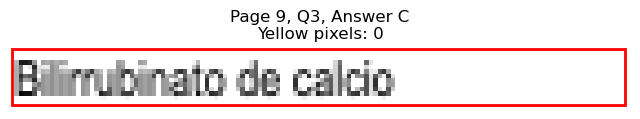

Page 9, Q3 - D: Detected box: x0=334.6, y0=350.2, x1=406.4, y1=362.9
Page 9, Q3, D: Yellow pixels: 1323
Page 9, Q3, D: Total non-white pixels: 1599
Page 9, Q3, D: Yellow percentage: 82.7%


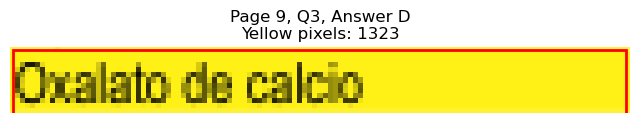

Page 9, Q3 - E: Detected box: x0=334.1, y0=362.8, x1=387.8, y1=375.5
Page 9, Q3, E: Yellow pixels: 104
Page 9, Q3, E: Total non-white pixels: 375
Page 9, Q3, E: Yellow percentage: 27.7%


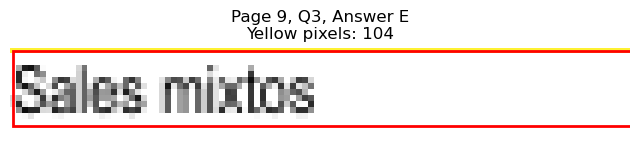


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.5, y0=425.9, x1=92.5, y1=438.6
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 30
Page 9, Q4, A: Yellow percentage: 0.0%


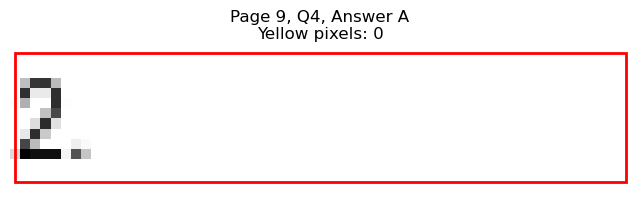

Page 9, Q4 - B: Detected box: x0=82.5, y0=438.5, x1=92.5, y1=451.2
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 17
Page 9, Q4, B: Yellow percentage: 0.0%


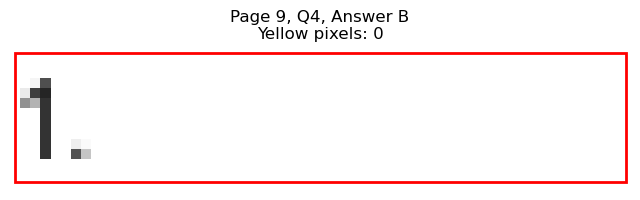

Page 9, Q4 - C: Detected box: x0=82.9, y0=451.1, x1=93.0, y1=463.8
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 30
Page 9, Q4, C: Yellow percentage: 0.0%


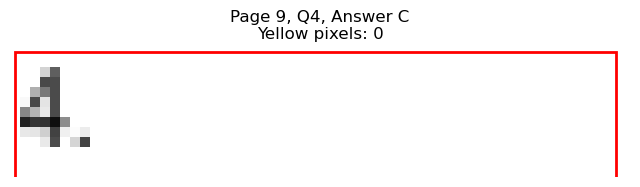

Page 9, Q4 - D: Detected box: x0=334.6, y0=425.9, x1=344.7, y1=438.6
Page 9, Q4, D: Yellow pixels: 771
Page 9, Q4, D: Total non-white pixels: 854
Page 9, Q4, D: Yellow percentage: 90.3%


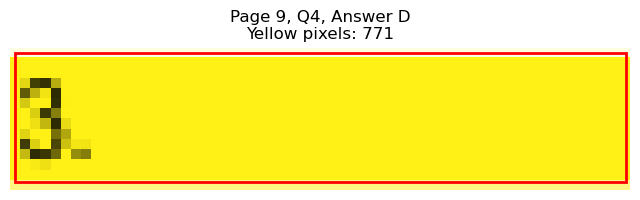

Page 9, Q4 - E: Detected box: x0=334.1, y0=438.5, x1=344.2, y1=451.2
Page 9, Q4, E: Yellow pixels: 61
Page 9, Q4, E: Total non-white pixels: 95
Page 9, Q4, E: Yellow percentage: 64.2%


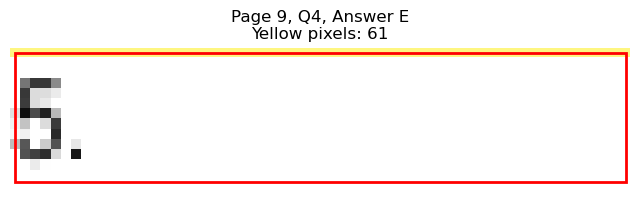


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.5, y0=501.7, x1=243.6, y1=514.3
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 775
Page 9, Q5, A: Yellow percentage: 0.0%


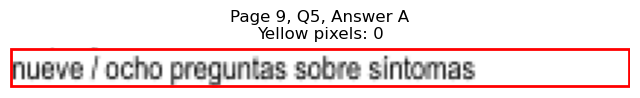

Page 9, Q5 - B: Detected box: x0=82.5, y0=514.3, x1=234.5, y1=526.9
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 771
Page 9, Q5, B: Yellow percentage: 0.0%


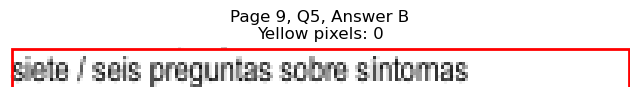

Page 9, Q5 - C: Detected box: x0=82.9, y0=526.9, x1=241.0, y1=539.5
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 792
Page 9, Q5, C: Yellow percentage: 0.0%


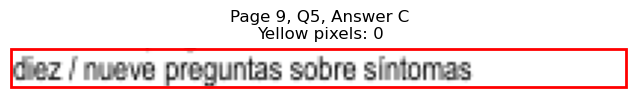

Page 9, Q5 - D: Detected box: x0=334.6, y0=501.7, x1=488.7, y1=514.3
Page 9, Q5, D: Yellow pixels: 192
Page 9, Q5, D: Total non-white pixels: 949
Page 9, Q5, D: Yellow percentage: 20.2%


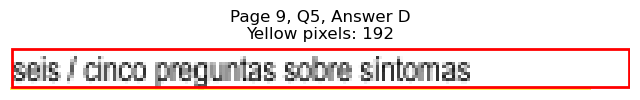

Page 9, Q5 - E: Detected box: x0=334.1, y0=514.3, x1=489.7, y1=526.9
Page 9, Q5, E: Yellow pixels: 1887
Page 9, Q5, E: Total non-white pixels: 2496
Page 9, Q5, E: Yellow percentage: 75.6%


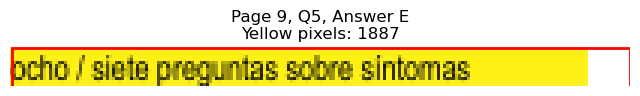


Page 9, Q5 - Selected Answer: E (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.5, y0=602.6, x1=141.1, y1=615.2
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 287
Page 9, Q6, A: Yellow percentage: 0.0%


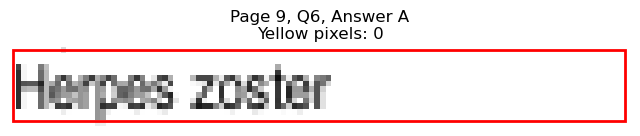

Page 9, Q6 - B: Detected box: x0=82.5, y0=615.2, x1=198.3, y1=627.8
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 601
Page 9, Q6, B: Yellow percentage: 0.0%


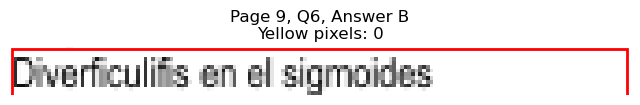

Page 9, Q6 - C: Detected box: x0=82.9, y0=627.9, x1=207.3, y1=640.6
Page 9, Q6, C: Yellow pixels: 1822
Page 9, Q6, C: Total non-white pixels: 2464
Page 9, Q6, C: Yellow percentage: 73.9%


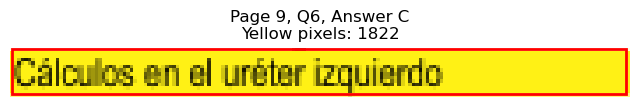

Page 9, Q6 - D: Detected box: x0=334.6, y0=602.6, x1=455.0, y1=615.2
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 579
Page 9, Q6, D: Yellow percentage: 0.0%


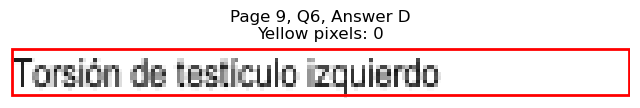

Page 9, Q6 - E: Detected box: x0=334.1, y0=615.2, x1=411.9, y1=627.8
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 424
Page 9, Q6, E: Yellow percentage: 0.0%


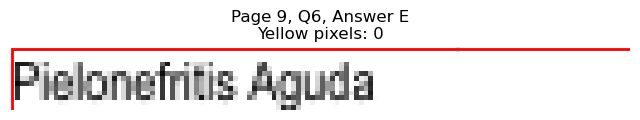


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.5, y0=665.7, x1=238.5, y1=678.4
Page 9, Q7, A: Yellow pixels: 192
Page 9, Q7, A: Total non-white pixels: 932
Page 9, Q7, A: Yellow percentage: 20.6%


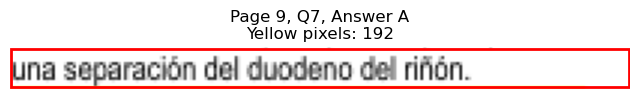

Page 9, Q7 - B: Detected box: x0=82.5, y0=678.3, x1=234.0, y1=691.0
Page 9, Q7, B: Yellow pixels: 1966
Page 9, Q7, B: Total non-white pixels: 2509
Page 9, Q7, B: Yellow percentage: 78.4%


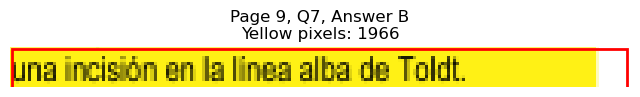

Page 9, Q7 - C: Detected box: x0=82.9, y0=691.1, x1=206.3, y1=703.7
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 775
Page 9, Q7, C: Yellow percentage: 0.0%


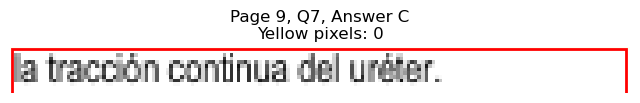

Page 9, Q7 - D: Detected box: x0=334.6, y0=665.7, x1=492.2, y1=678.4
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 751
Page 9, Q7, D: Yellow percentage: 0.0%


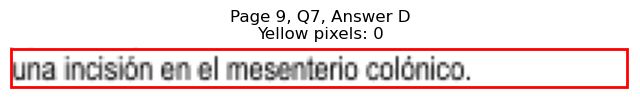

Page 9, Q7 - E: Detected box: x0=334.1, y0=678.3, x1=509.7, y1=691.0
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 863
Page 9, Q7, E: Yellow percentage: 0.0%


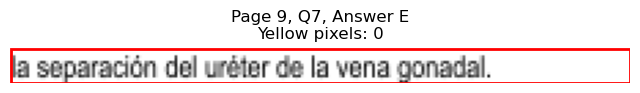


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=195.0, y1=135.6
Page 10, Q1, A: Yellow pixels: 1717
Page 10, Q1, A: Total non-white pixels: 2296
Page 10, Q1, A: Yellow percentage: 74.8%


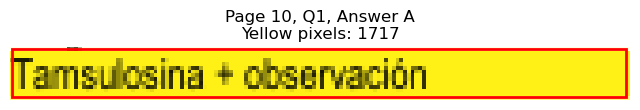

Page 10, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=214.5, y1=148.2
Page 10, Q1, B: Yellow pixels: 183
Page 10, Q1, B: Total non-white pixels: 858
Page 10, Q1, B: Yellow percentage: 21.3%


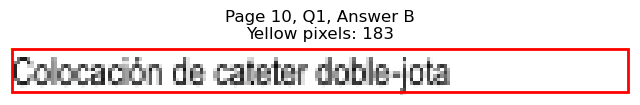

Page 10, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=168.7, y1=160.9
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 467
Page 10, Q1, C: Yellow percentage: 0.0%


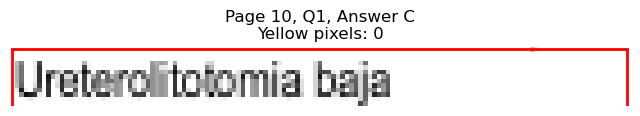

Page 10, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=433.9, y1=135.6
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 502
Page 10, Q1, D: Yellow percentage: 0.0%


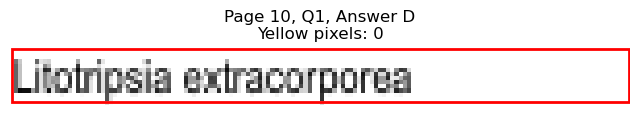

Page 10, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=435.7, y1=148.2
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 525
Page 10, Q1, E: Yellow percentage: 0.0%


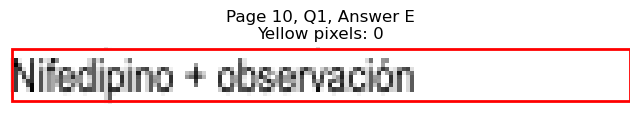


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.5, y0=198.6, x1=188.8, y1=211.3
Page 10, Q2, A: Yellow pixels: 1456
Page 10, Q2, A: Total non-white pixels: 2198
Page 10, Q2, A: Yellow percentage: 66.2%


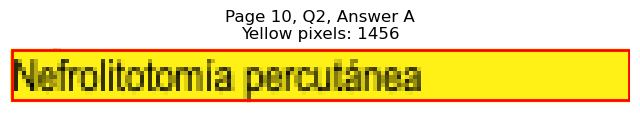

Page 10, Q2 - B: Detected box: x0=82.5, y0=211.3, x1=269.1, y1=224.0
Page 10, Q2, B: Yellow pixels: 1
Page 10, Q2, B: Total non-white pixels: 1075
Page 10, Q2, B: Yellow percentage: 0.1%


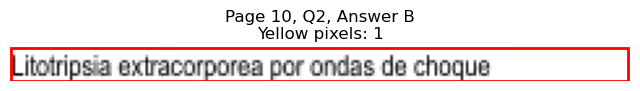

Page 10, Q2 - C: Detected box: x0=82.9, y0=223.9, x1=221.3, y1=236.6
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 738
Page 10, Q2, C: Yellow percentage: 0.0%


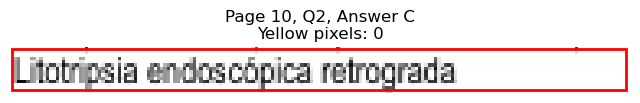

Page 10, Q2 - D: Detected box: x0=334.6, y0=198.6, x1=515.1, y1=211.3
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 889
Page 10, Q2, D: Yellow percentage: 0.0%


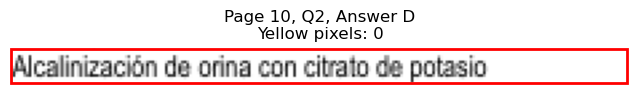

Page 10, Q2 - E: Detected box: x0=334.1, y0=211.3, x1=412.4, y1=224.0
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 402
Page 10, Q2, E: Yellow percentage: 0.0%


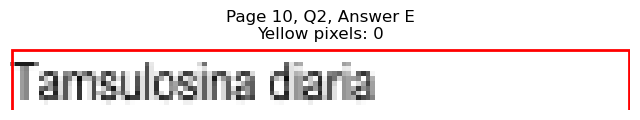


Page 10, Q2 - Selected Answer: A (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=209.9, y1=274.4
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 618
Page 10, Q3, A: Yellow percentage: 0.0%


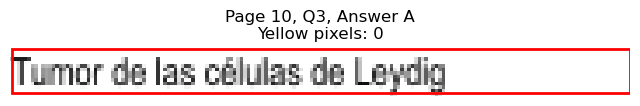

Page 10, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=148.1, y1=287.1
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 331
Page 10, Q3, B: Yellow percentage: 0.0%


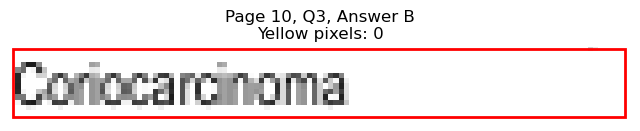

Page 10, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=153.1, y1=299.7
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 349
Page 10, Q3, C: Yellow percentage: 0.0%


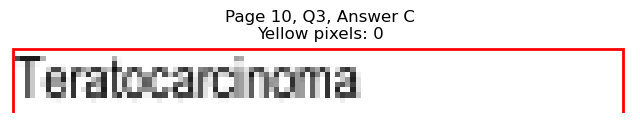

Page 10, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=397.9, y1=274.4
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 309
Page 10, Q3, D: Yellow percentage: 0.0%


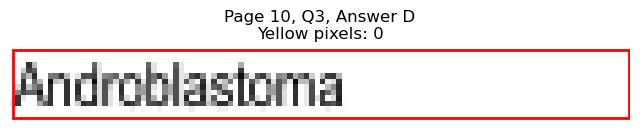

Page 10, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=379.7, y1=287.1
Page 10, Q3, E: Yellow pixels: 1082
Page 10, Q3, E: Total non-white pixels: 1344
Page 10, Q3, E: Yellow percentage: 80.5%


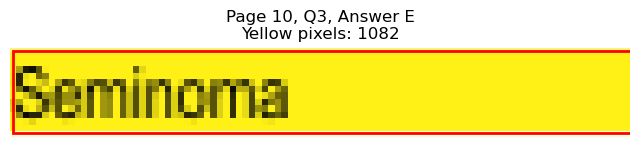


Page 10, Q3 - Selected Answer: E (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=70.8, y0=350.2, x1=79.3, y1=362.9
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 54
Page 10, Q4, A: Yellow percentage: 0.0%


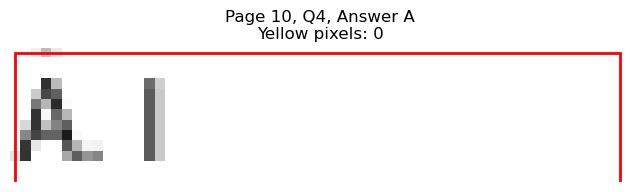

Page 10, Q4 - B: Detected box: x0=82.5, y0=362.8, x1=95.5, y1=375.5
Page 10, Q4, B: Yellow pixels: 64
Page 10, Q4, B: Total non-white pixels: 123
Page 10, Q4, B: Yellow percentage: 52.0%


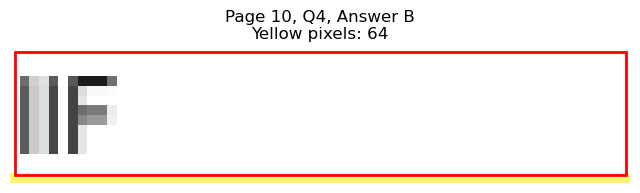

Page 10, Q4 - C: Detected box: x0=70.8, y0=375.4, x1=79.8, y1=388.1
Page 10, Q4, C: Yellow pixels: 731
Page 10, Q4, C: Total non-white pixels: 840
Page 10, Q4, C: Yellow percentage: 87.0%


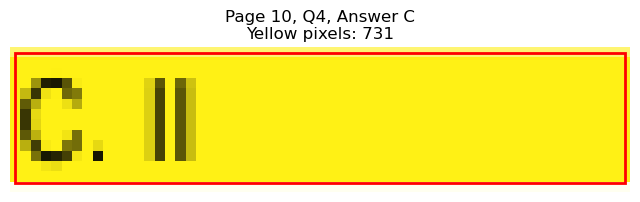

Page 10, Q4 - D: Detected box: x0=334.6, y0=350.2, x1=344.7, y1=362.9
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 40
Page 10, Q4, D: Yellow percentage: 0.0%


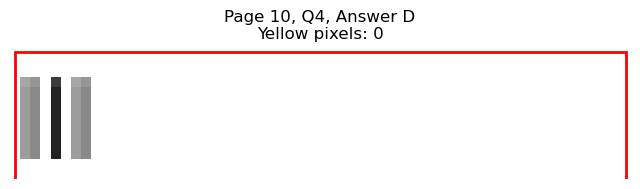

Page 10, Q4 - E: Detected box: x0=334.1, y0=362.8, x1=345.2, y1=375.5
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 36
Page 10, Q4, E: Yellow percentage: 0.0%


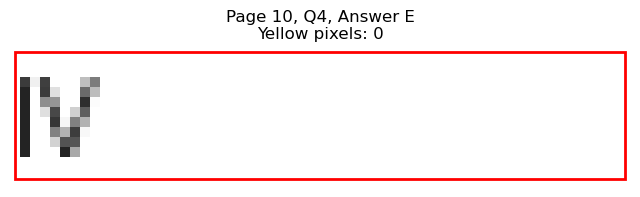


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.5, y0=413.3, x1=152.2, y1=426.0
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 492
Page 10, Q5, A: Yellow percentage: 0.0%


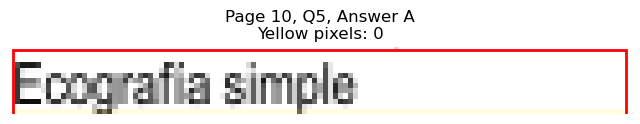

Page 10, Q5 - B: Detected box: x0=82.5, y0=425.9, x1=156.1, y1=438.6
Page 10, Q5, B: Yellow pixels: 1323
Page 10, Q5, B: Total non-white pixels: 1750
Page 10, Q5, B: Yellow percentage: 75.6%


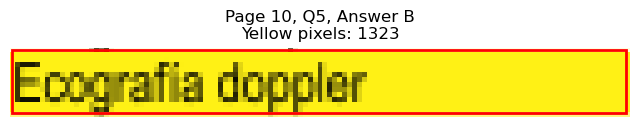

Page 10, Q5 - C: Detected box: x0=82.9, y0=438.5, x1=131.5, y1=451.2
Page 10, Q5, C: Yellow pixels: 99
Page 10, Q5, C: Total non-white pixels: 349
Page 10, Q5, C: Yellow percentage: 28.4%


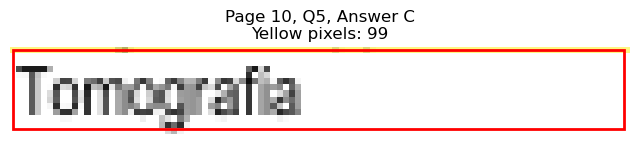

Page 10, Q5 - D: Detected box: x0=334.6, y0=413.3, x1=384.8, y1=426.0
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 256
Page 10, Q5, D: Yellow percentage: 0.0%


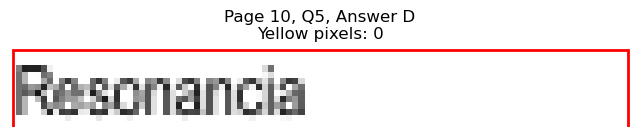

Page 10, Q5 - E: Detected box: x0=334.1, y0=425.9, x1=391.9, y1=438.6
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 302
Page 10, Q5, E: Yellow percentage: 0.0%


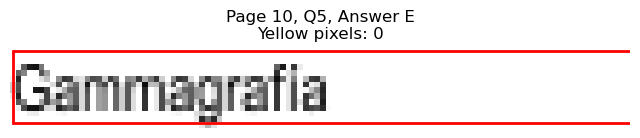


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.5, y0=476.3, x1=134.7, y1=489.0
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 254
Page 10, Q6, A: Yellow percentage: 0.0%


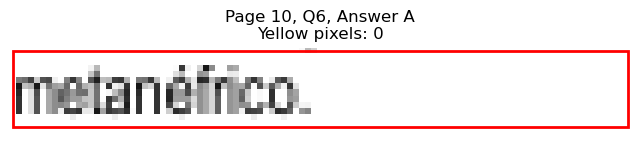

Page 10, Q6 - B: Detected box: x0=82.5, y0=489.1, x1=108.0, y1=501.7
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 129
Page 10, Q6, B: Yellow percentage: 0.0%


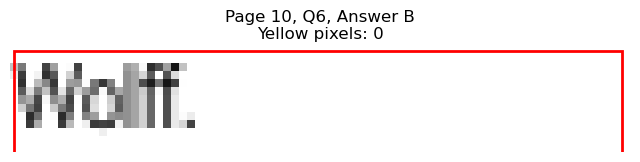

Page 10, Q6 - C: Detected box: x0=82.9, y0=501.7, x1=112.6, y1=514.3
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 127
Page 10, Q6, C: Yellow percentage: 0.0%


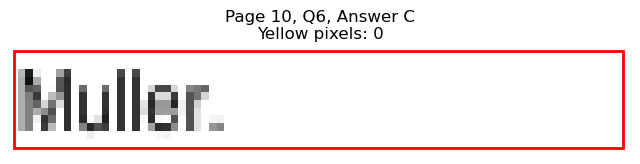

Page 10, Q6 - D: Detected box: x0=334.6, y0=476.3, x1=408.3, y1=489.0
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 367
Page 10, Q6, D: Yellow percentage: 0.0%


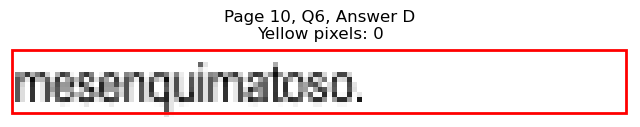

Page 10, Q6 - E: Detected box: x0=334.1, y0=489.1, x1=388.3, y1=501.7
Page 10, Q6, E: Yellow pixels: 1163
Page 10, Q6, E: Total non-white pixels: 1365
Page 10, Q6, E: Yellow percentage: 85.2%


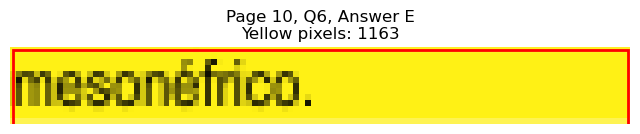


Page 10, Q6 - Selected Answer: E (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.5, y0=552.2, x1=157.2, y1=564.8
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 374
Page 10, Q7, A: Yellow percentage: 0.0%


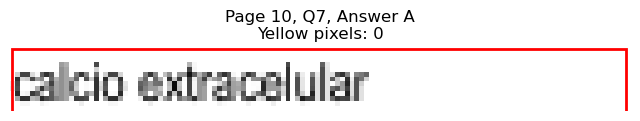

Page 10, Q7 - B: Detected box: x0=82.5, y0=564.8, x1=131.7, y1=577.4
Page 10, Q7, B: Yellow pixels: 100
Page 10, Q7, B: Total non-white pixels: 351
Page 10, Q7, B: Yellow percentage: 28.5%


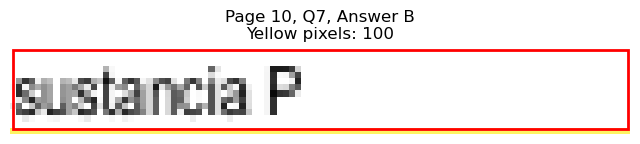

Page 10, Q7 - C: Detected box: x0=82.9, y0=577.4, x1=130.1, y1=590.0
Page 10, Q7, C: Yellow pixels: 1100
Page 10, Q7, C: Total non-white pixels: 1287
Page 10, Q7, C: Yellow percentage: 85.5%


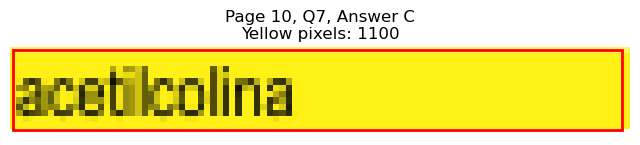

Page 10, Q7 - D: Detected box: x0=334.6, y0=552.2, x1=379.3, y1=564.8
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 222
Page 10, Q7, D: Yellow percentage: 0.0%


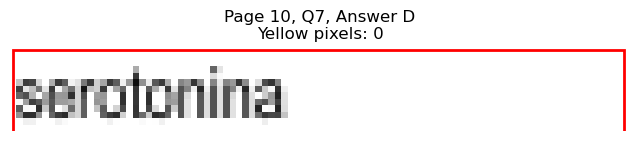

Page 10, Q7 - E: Detected box: x0=334.1, y0=564.8, x1=375.8, y1=577.4
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 222
Page 10, Q7, E: Yellow percentage: 0.0%


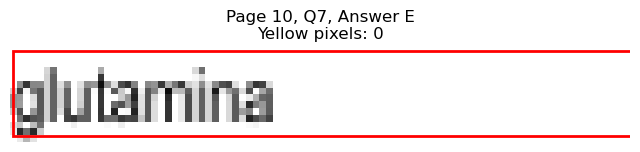


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=82.5, y0=627.9, x1=200.3, y1=640.6
Page 10, Q8, A: Yellow pixels: 169
Page 10, Q8, A: Total non-white pixels: 731
Page 10, Q8, A: Yellow percentage: 23.1%


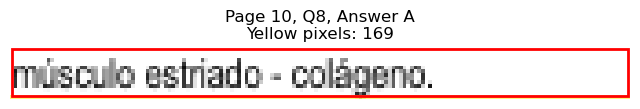

Page 10, Q8 - B: Detected box: x0=82.5, y0=640.5, x1=213.4, y1=653.2
Page 10, Q8, B: Yellow pixels: 1890
Page 10, Q8, B: Total non-white pixels: 2548
Page 10, Q8, B: Yellow percentage: 74.2%


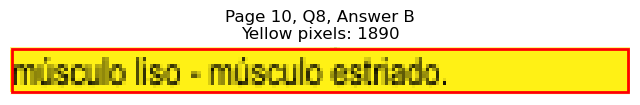

Page 10, Q8 - C: Detected box: x0=82.9, y0=653.1, x1=200.8, y1=665.8
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 551
Page 10, Q8, C: Yellow percentage: 0.0%


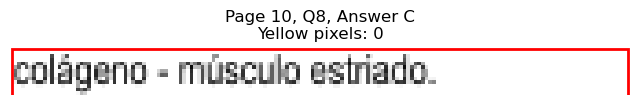

Page 10, Q8 - D: Detected box: x0=334.6, y0=627.9, x1=434.0, y1=640.6
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 475
Page 10, Q8, D: Yellow percentage: 0.0%


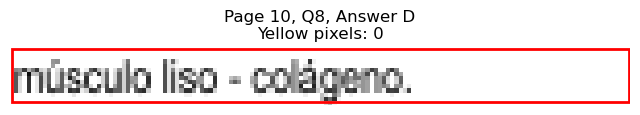

Page 10, Q8 - E: Detected box: x0=334.1, y0=640.5, x1=465.1, y1=653.2
Page 10, Q8, E: Yellow pixels: 0
Page 10, Q8, E: Total non-white pixels: 628
Page 10, Q8, E: Yellow percentage: 0.0%


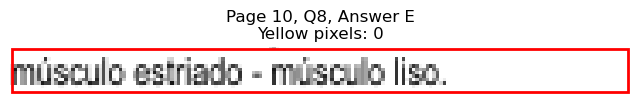


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=82.5, y0=741.4, x1=141.6, y1=754.1
Page 10, Q9, A: Yellow pixels: 110
Page 10, Q9, A: Total non-white pixels: 403
Page 10, Q9, A: Yellow percentage: 27.3%


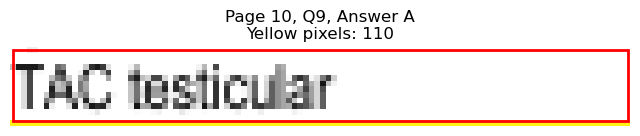

Page 10, Q9 - B: Detected box: x0=82.5, y0=754.0, x1=137.7, y1=766.7
Page 10, Q9, B: Yellow pixels: 1163
Page 10, Q9, B: Total non-white pixels: 1378
Page 10, Q9, B: Yellow percentage: 84.4%


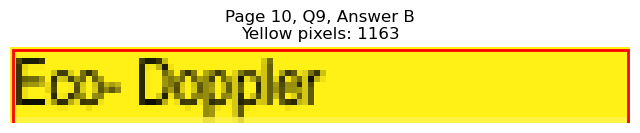

Page 10, Q9 - C: Detected box: x0=82.9, y0=766.8, x1=174.7, y1=779.4
Page 10, Q9, C: Yellow pixels: 143
Page 10, Q9, C: Total non-white pixels: 623
Page 10, Q9, C: Yellow percentage: 23.0%


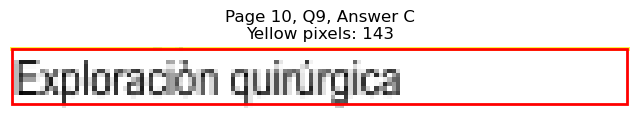

Page 10, Q9 - D: Detected box: x0=334.6, y0=741.4, x1=408.3, y1=754.1
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 362
Page 10, Q9, D: Yellow percentage: 0.0%


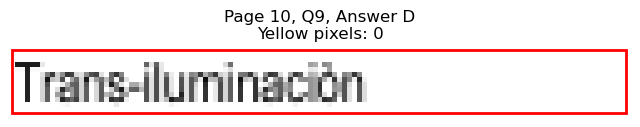

Page 10, Q9 - E: Detected box: x0=334.1, y0=754.0, x1=409.4, y1=766.7
Page 10, Q9, E: Yellow pixels: 0
Page 10, Q9, E: Total non-white pixels: 374
Page 10, Q9, E: Yellow percentage: 0.0%


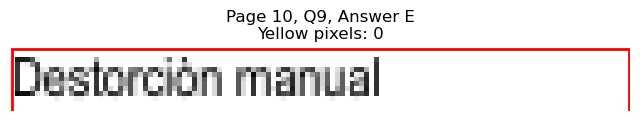


Page 10, Q9 - Selected Answer: B (based on yellow pixel count)





Page 11: Found 8 questions
Page 11, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=202.4, y1=123.0
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 609
Page 11, Q1, A: Yellow percentage: 0.0%


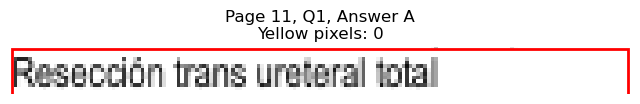

Page 11, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=212.0, y1=135.6
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 661
Page 11, Q1, B: Yellow percentage: 0.0%


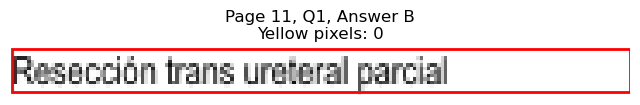

Page 11, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=237.4, y1=148.2
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 809
Page 11, Q1, C: Yellow percentage: 0.0%


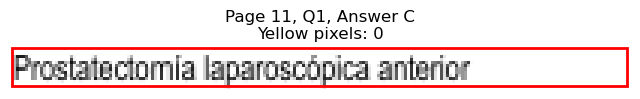

Page 11, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=450.4, y1=123.0
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 744
Page 11, Q1, D: Yellow percentage: 0.0%


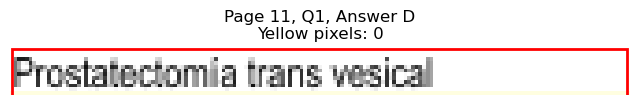

Page 11, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=526.9, y1=135.6
Page 11, Q1, E: Yellow pixels: 1728
Page 11, Q1, E: Total non-white pixels: 2688
Page 11, Q1, E: Yellow percentage: 64.3%


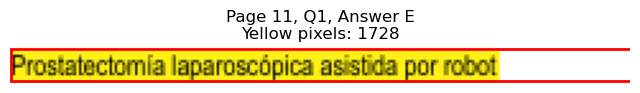


Page 11, Q1 - Selected Answer: E (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=82.5, y0=198.6, x1=92.5, y1=211.3
Page 11, Q2, A: Yellow pixels: 694
Page 11, Q2, A: Total non-white pixels: 854
Page 11, Q2, A: Yellow percentage: 81.3%


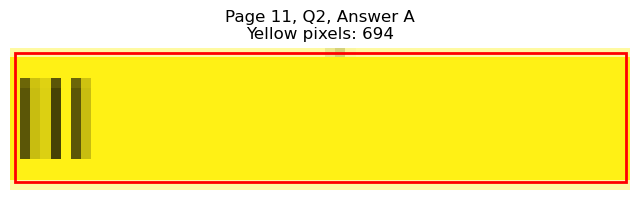

Page 11, Q2 - B: Detected box: x0=70.8, y0=211.3, x1=79.3, y1=224.0
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 118
Page 11, Q2, B: Yellow percentage: 0.0%


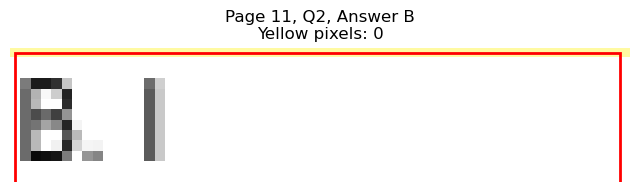

Page 11, Q2 - C: Detected box: x0=70.8, y0=223.9, x1=79.8, y1=236.6
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 68
Page 11, Q2, C: Yellow percentage: 0.0%


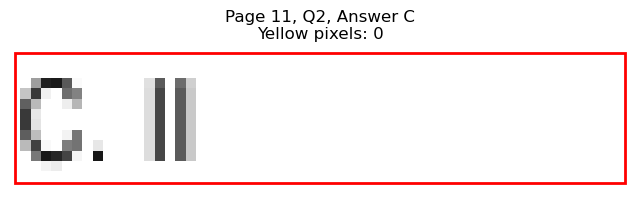

Page 11, Q2 - D: Detected box: x0=334.6, y0=198.6, x1=345.7, y1=211.3
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 44
Page 11, Q2, D: Yellow percentage: 0.0%


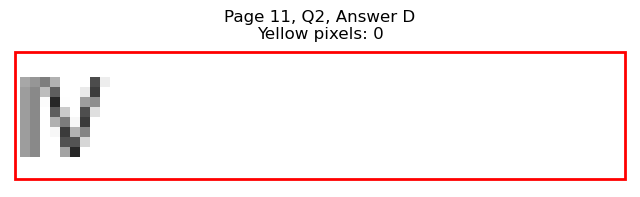

Page 11, Q2 - E: Detected box: x0=334.1, y0=211.3, x1=342.7, y1=224.0
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 28
Page 11, Q2, E: Yellow percentage: 0.0%


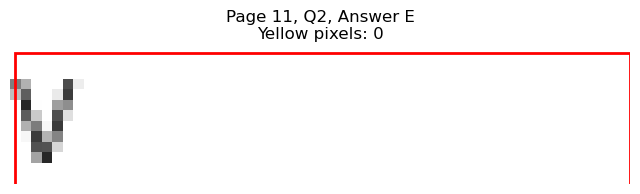


Page 11, Q2 - Selected Answer: A (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=242.2, y0=261.7, x1=275.2, y1=274.4
Page 11, Q3, A: Yellow pixels: 53
Page 11, Q3, A: Total non-white pixels: 231
Page 11, Q3, A: Yellow percentage: 22.9%


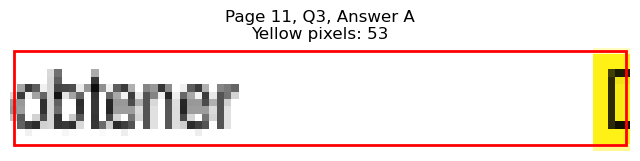

Page 11, Q3 - B: Detected box: x0=82.5, y0=299.7, x1=275.2, y1=312.3
Page 11, Q3, B: Yellow pixels: 5
Page 11, Q3, B: Total non-white pixels: 931
Page 11, Q3, B: Yellow percentage: 0.5%


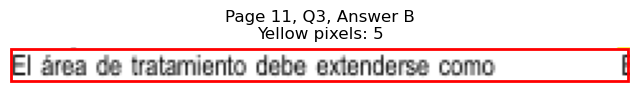

Page 11, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=275.2, y1=337.5
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 936
Page 11, Q3, C: Yellow percentage: 0.0%


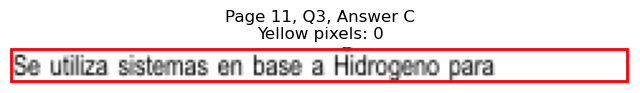

Page 11, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=526.9, y1=274.4
Page 11, Q3, D: Yellow pixels: 1831
Page 11, Q3, D: Total non-white pixels: 2688
Page 11, Q3, D: Yellow percentage: 68.1%


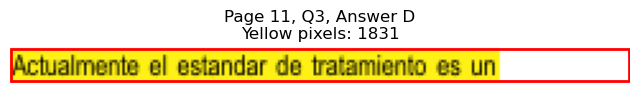

Page 11, Q3 - E: Detected box: x0=426.1, y0=299.7, x1=501.8, y1=312.3
Page 11, Q3, E: Yellow pixels: 100
Page 11, Q3, E: Total non-white pixels: 586
Page 11, Q3, E: Yellow percentage: 17.1%


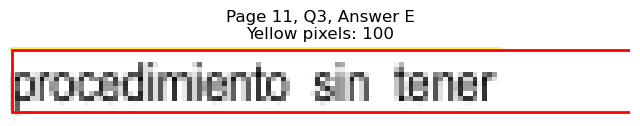


Page 11, Q3 - Selected Answer: D (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=82.5, y0=400.6, x1=127.1, y1=413.3
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 224
Page 11, Q4, A: Yellow percentage: 0.0%


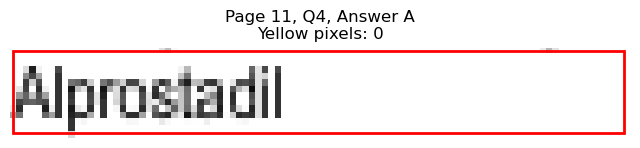

Page 11, Q4 - B: Detected box: x0=82.5, y0=413.3, x1=123.1, y1=426.0
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 191
Page 11, Q4, B: Yellow percentage: 0.0%


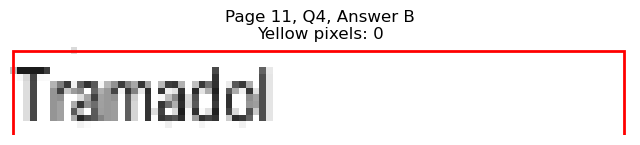

Page 11, Q4 - C: Detected box: x0=82.9, y0=425.9, x1=124.6, y1=438.6
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 209
Page 11, Q4, C: Yellow percentage: 0.0%


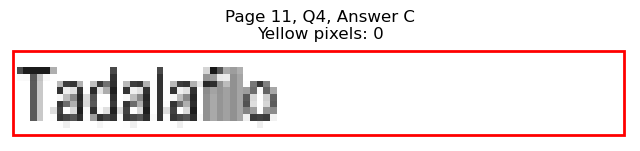

Page 11, Q4 - D: Detected box: x0=334.6, y0=400.6, x1=381.8, y1=413.3
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 248
Page 11, Q4, D: Yellow percentage: 0.0%


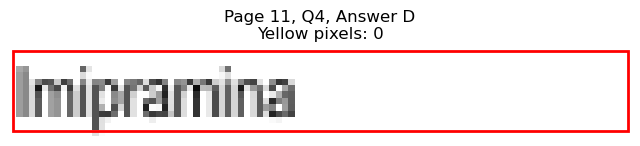

Page 11, Q4 - E: Detected box: x0=334.1, y0=413.3, x1=382.3, y1=426.0
Page 11, Q4, E: Yellow pixels: 1109
Page 11, Q4, E: Total non-white pixels: 1287
Page 11, Q4, E: Yellow percentage: 86.2%


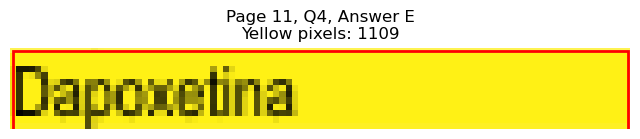


Page 11, Q4 - Selected Answer: E (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=70.8, y0=489.1, x1=79.3, y1=501.7
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 108
Page 11, Q5, A: Yellow percentage: 0.0%


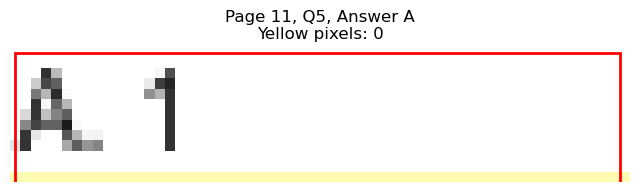

Page 11, Q5 - B: Detected box: x0=70.8, y0=501.7, x1=79.3, y1=514.3
Page 11, Q5, B: Yellow pixels: 664
Page 11, Q5, B: Total non-white pixels: 840
Page 11, Q5, B: Yellow percentage: 79.0%


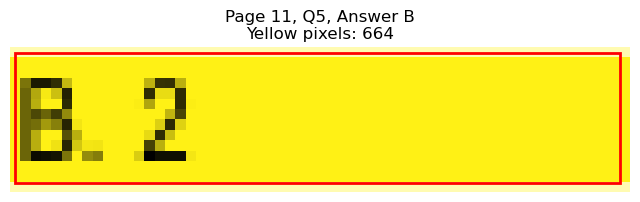

Page 11, Q5 - C: Detected box: x0=70.8, y0=514.3, x1=79.8, y1=526.9
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 126
Page 11, Q5, C: Yellow percentage: 0.0%


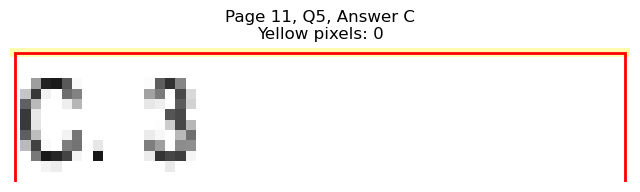

Page 11, Q5 - D: Detected box: x0=322.5, y0=489.1, x1=331.5, y1=501.7
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 69
Page 11, Q5, D: Yellow percentage: 0.0%


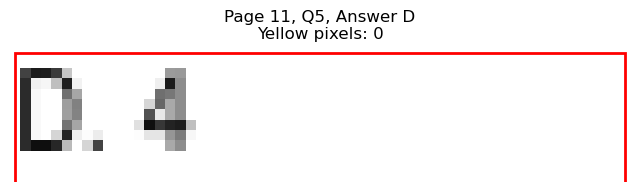

Page 11, Q5 - E: Detected box: x0=322.5, y0=501.7, x1=331.0, y1=514.3
Page 11, Q5, E: Yellow pixels: 0
Page 11, Q5, E: Total non-white pixels: 68
Page 11, Q5, E: Yellow percentage: 0.0%


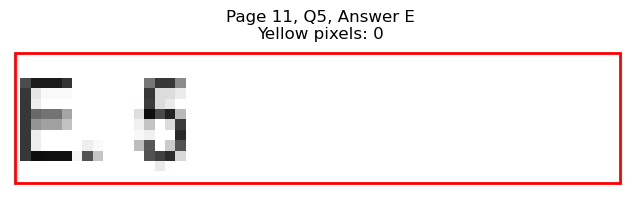


Page 11, Q5 - Selected Answer: B (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=82.5, y0=577.4, x1=237.9, y1=590.0
Page 11, Q6, A: Yellow pixels: 1885
Page 11, Q6, A: Total non-white pixels: 2509
Page 11, Q6, A: Yellow percentage: 75.1%


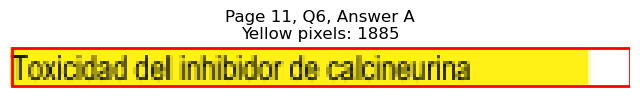

Page 11, Q6 - B: Detected box: x0=82.5, y0=590.0, x1=189.7, y1=602.6
Page 11, Q6, B: Yellow pixels: 158
Page 11, Q6, B: Total non-white pixels: 696
Page 11, Q6, B: Yellow percentage: 22.7%


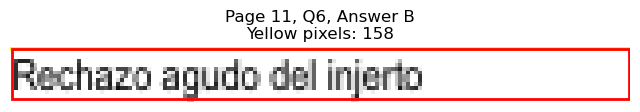

Page 11, Q6 - C: Detected box: x0=82.9, y0=602.6, x1=202.4, y1=615.2
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 599
Page 11, Q6, C: Yellow percentage: 0.0%


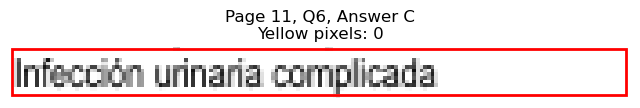

Page 11, Q6 - D: Detected box: x0=334.6, y0=577.4, x1=454.0, y1=590.0
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 603
Page 11, Q6, D: Yellow percentage: 0.0%


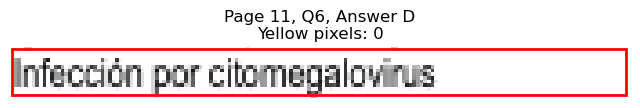

Page 11, Q6 - E: Detected box: x0=334.1, y0=590.0, x1=487.1, y1=602.6
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 740
Page 11, Q6, E: Yellow percentage: 0.0%


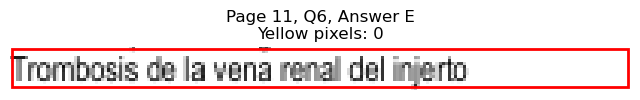


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=82.5, y0=653.1, x1=122.1, y1=665.8
Page 11, Q7, A: Yellow pixels: 1035
Page 11, Q7, A: Total non-white pixels: 1183
Page 11, Q7, A: Yellow percentage: 87.5%


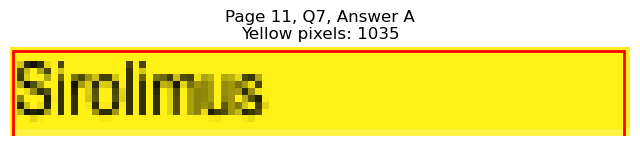

Page 11, Q7 - B: Detected box: x0=82.5, y0=665.7, x1=124.1, y1=678.4
Page 11, Q7, B: Yellow pixels: 93
Page 11, Q7, B: Total non-white pixels: 306
Page 11, Q7, B: Yellow percentage: 30.4%


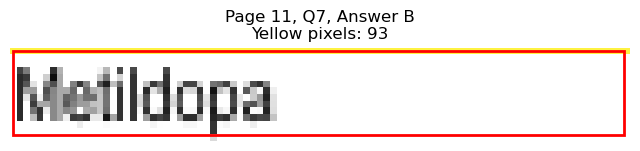

Page 11, Q7 - C: Detected box: x0=82.9, y0=678.3, x1=131.1, y1=691.0
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 241
Page 11, Q7, C: Yellow percentage: 0.0%


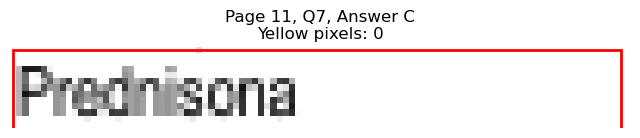

Page 11, Q7 - D: Detected box: x0=334.6, y0=653.1, x1=386.8, y1=665.8
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 279
Page 11, Q7, D: Yellow percentage: 0.0%


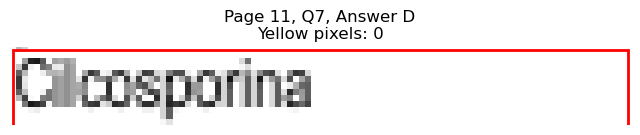

Page 11, Q7 - E: Detected box: x0=334.1, y0=665.7, x1=374.2, y1=678.4
Page 11, Q7, E: Yellow pixels: 0
Page 11, Q7, E: Total non-white pixels: 215
Page 11, Q7, E: Yellow percentage: 0.0%


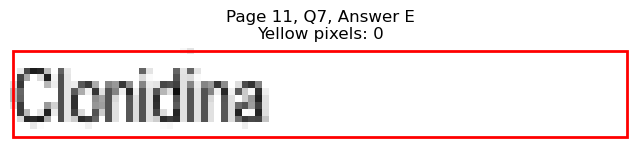


Page 11, Q7 - Selected Answer: A (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=82.5, y0=716.3, x1=125.5, y1=728.9
Page 11, Q8, A: Yellow pixels: 0
Page 11, Q8, A: Total non-white pixels: 329
Page 11, Q8, A: Yellow percentage: 0.0%


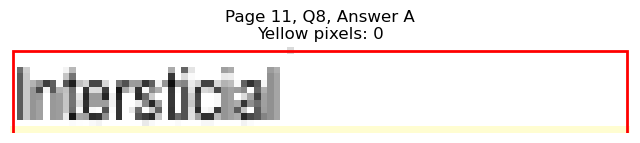

Page 11, Q8 - B: Detected box: x0=82.5, y0=728.9, x1=173.8, y1=741.5
Page 11, Q8, B: Yellow pixels: 1466
Page 11, Q8, B: Total non-white pixels: 1988
Page 11, Q8, B: Yellow percentage: 73.7%


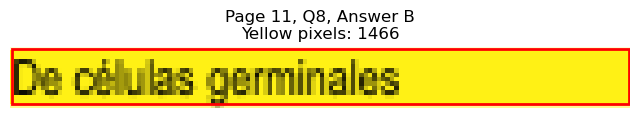

Page 11, Q8 - C: Detected box: x0=82.9, y0=741.4, x1=169.2, y1=754.1
Page 11, Q8, C: Yellow pixels: 137
Page 11, Q8, C: Total non-white pixels: 565
Page 11, Q8, C: Yellow percentage: 24.2%


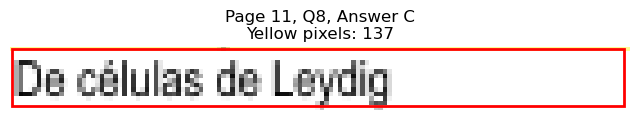

Page 11, Q8 - D: Detected box: x0=334.6, y0=716.3, x1=419.8, y1=728.9
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 440
Page 11, Q8, D: Yellow percentage: 0.0%


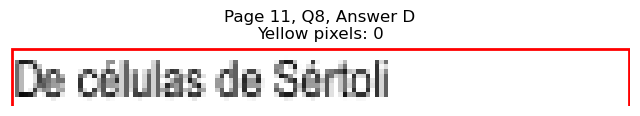

Page 11, Q8 - E: Detected box: x0=334.1, y0=728.9, x1=383.4, y1=741.5
Page 11, Q8, E: Yellow pixels: 0
Page 11, Q8, E: Total non-white pixels: 248
Page 11, Q8, E: Yellow percentage: 0.0%


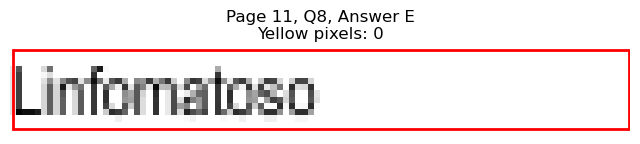


Page 11, Q8 - Selected Answer: B (based on yellow pixel count)





Page 12: Found 8 questions
Page 12, Q1 - A: Detected box: x0=70.8, y0=110.3, x1=79.3, y1=123.0
Page 12, Q1, A: Yellow pixels: 0
Page 12, Q1, A: Total non-white pixels: 77
Page 12, Q1, A: Yellow percentage: 0.0%


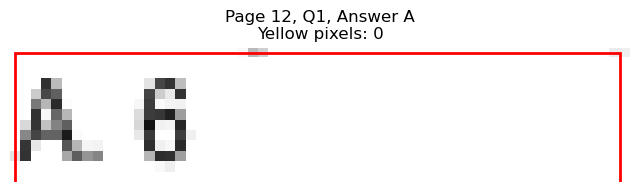

Page 12, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=95.1, y1=135.6
Page 12, Q1, B: Yellow pixels: 64
Page 12, Q1, B: Total non-white pixels: 103
Page 12, Q1, B: Yellow percentage: 62.1%


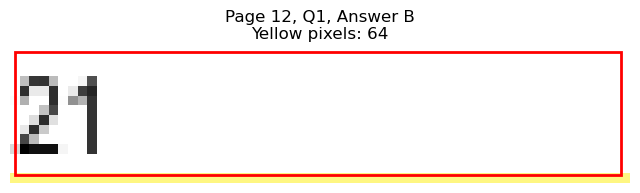

Page 12, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=95.5, y1=148.2
Page 12, Q1, C: Yellow pixels: 784
Page 12, Q1, C: Total non-white pixels: 896
Page 12, Q1, C: Yellow percentage: 87.5%


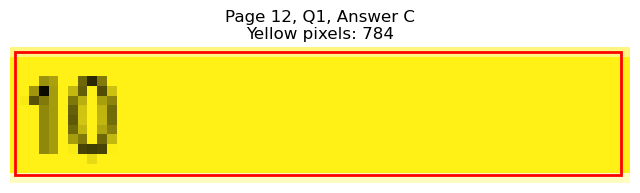

Page 12, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=347.2, y1=123.0
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 60
Page 12, Q1, D: Yellow percentage: 0.0%


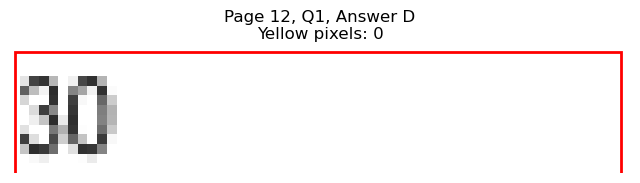

Page 12, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=346.7, y1=135.6
Page 12, Q1, E: Yellow pixels: 0
Page 12, Q1, E: Total non-white pixels: 63
Page 12, Q1, E: Yellow percentage: 0.0%


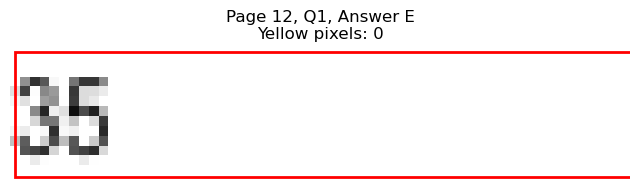


Page 12, Q1 - Selected Answer: C (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=142.7, y1=186.1
Page 12, Q2, A: Yellow pixels: 0
Page 12, Q2, A: Total non-white pixels: 267
Page 12, Q2, A: Yellow percentage: 0.0%


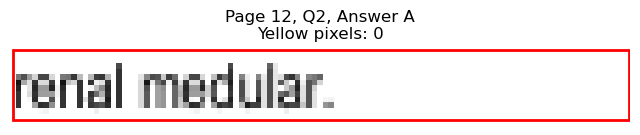

Page 12, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=158.7, y1=198.7
Page 12, Q2, B: Yellow pixels: 0
Page 12, Q2, B: Total non-white pixels: 478
Page 12, Q2, B: Yellow percentage: 0.0%


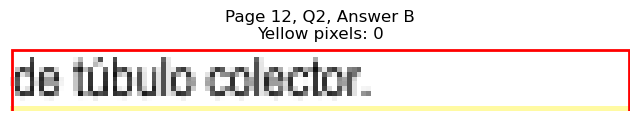

Page 12, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=142.6, y1=211.3
Page 12, Q2, C: Yellow pixels: 1113
Page 12, Q2, C: Total non-white pixels: 1554
Page 12, Q2, C: Yellow percentage: 71.6%


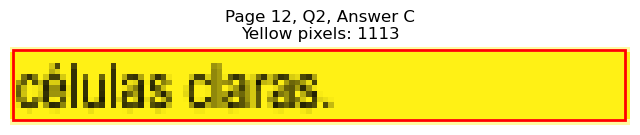

Page 12, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=382.3, y1=186.1
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 227
Page 12, Q2, D: Yellow percentage: 0.0%


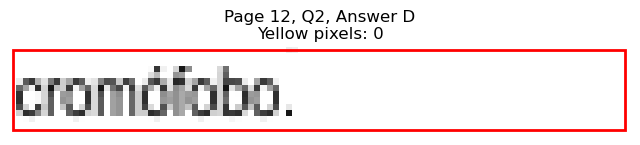

Page 12, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=366.3, y1=198.7
Page 12, Q2, E: Yellow pixels: 0
Page 12, Q2, E: Total non-white pixels: 170
Page 12, Q2, E: Yellow percentage: 0.0%


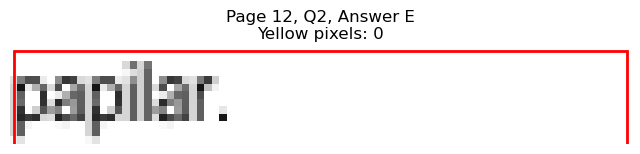


Page 12, Q2 - Selected Answer: C (based on yellow pixel count)




Page 12, Q3 - A: Detected box: x0=82.5, y0=236.5, x1=133.1, y1=249.2
Page 12, Q3, A: Yellow pixels: 1145
Page 12, Q3, A: Total non-white pixels: 1428
Page 12, Q3, A: Yellow percentage: 80.2%


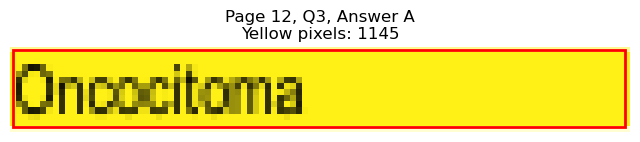

Page 12, Q3 - B: Detected box: x0=82.5, y0=249.1, x1=173.2, y1=261.8
Page 12, Q3, B: Yellow pixels: 0
Page 12, Q3, B: Total non-white pixels: 587
Page 12, Q3, B: Yellow percentage: 0.0%


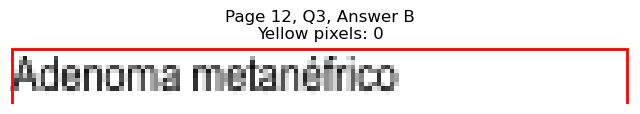

Page 12, Q3 - C: Detected box: x0=82.9, y0=261.7, x1=146.7, y1=274.4
Page 12, Q3, C: Yellow pixels: 0
Page 12, Q3, C: Total non-white pixels: 316
Page 12, Q3, C: Yellow percentage: 0.0%


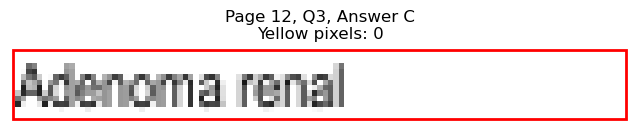

Page 12, Q3 - D: Detected box: x0=334.6, y0=236.5, x1=401.3, y1=249.2
Page 12, Q3, D: Yellow pixels: 0
Page 12, Q3, D: Total non-white pixels: 351
Page 12, Q3, D: Yellow percentage: 0.0%


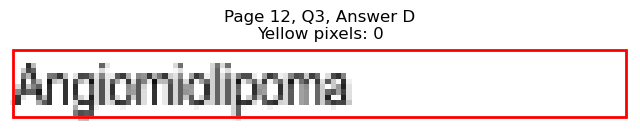

Page 12, Q3 - E: Detected box: x0=334.1, y0=249.1, x1=404.8, y1=261.8
Page 12, Q3, E: Yellow pixels: 0
Page 12, Q3, E: Total non-white pixels: 360
Page 12, Q3, E: Yellow percentage: 0.0%


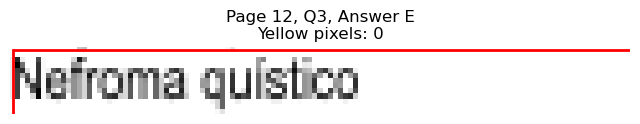


Page 12, Q3 - Selected Answer: A (based on yellow pixel count)




Page 12, Q4 - A: Detected box: x0=82.5, y0=350.2, x1=171.3, y1=362.9
Page 12, Q4, A: Yellow pixels: 0
Page 12, Q4, A: Total non-white pixels: 459
Page 12, Q4, A: Yellow percentage: 0.0%


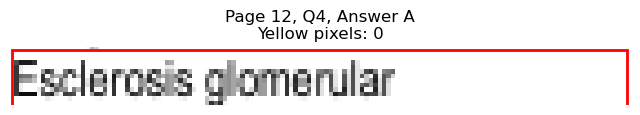

Page 12, Q4 - B: Detected box: x0=82.5, y0=362.8, x1=196.8, y1=375.5
Page 12, Q4, B: Yellow pixels: 0
Page 12, Q4, B: Total non-white pixels: 620
Page 12, Q4, B: Yellow percentage: 0.0%


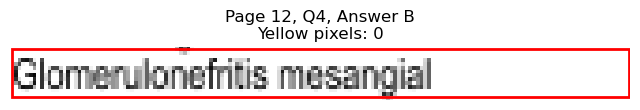

Page 12, Q4 - C: Detected box: x0=82.9, y0=375.4, x1=165.1, y1=388.1
Page 12, Q4, C: Yellow pixels: 0
Page 12, Q4, C: Total non-white pixels: 436
Page 12, Q4, C: Yellow percentage: 0.0%


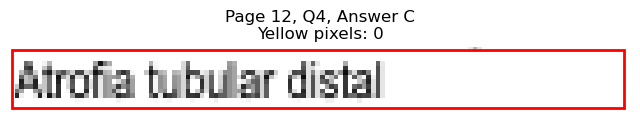

Page 12, Q4 - D: Detected box: x0=334.6, y0=350.2, x1=432.9, y1=362.9
Page 12, Q4, D: Yellow pixels: 0
Page 12, Q4, D: Total non-white pixels: 660
Page 12, Q4, D: Yellow percentage: 0.0%


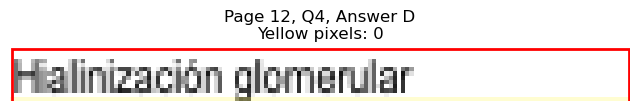

Page 12, Q4 - E: Detected box: x0=334.1, y0=362.8, x1=429.4, y1=375.5
Page 12, Q4, E: Yellow pixels: 1515
Page 12, Q4, E: Total non-white pixels: 2044
Page 12, Q4, E: Yellow percentage: 74.1%


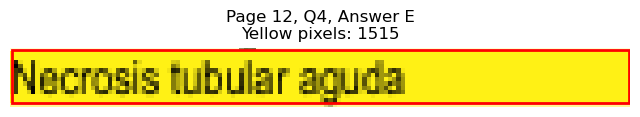


Page 12, Q4 - Selected Answer: E (based on yellow pixel count)




Page 12, Q5 - A: Detected box: x0=82.5, y0=413.3, x1=199.8, y1=426.0
Page 12, Q5, A: Yellow pixels: 1753
Page 12, Q5, A: Total non-white pixels: 2184
Page 12, Q5, A: Yellow percentage: 80.3%


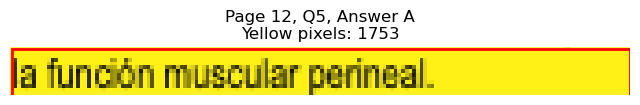

Page 12, Q5 - B: Detected box: x0=82.5, y0=425.9, x1=166.2, y1=438.6
Page 12, Q5, B: Yellow pixels: 134
Page 12, Q5, B: Total non-white pixels: 521
Page 12, Q5, B: Yellow percentage: 25.7%


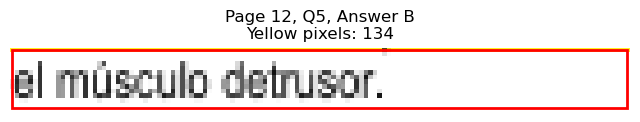

Page 12, Q5 - C: Detected box: x0=82.9, y0=438.5, x1=168.7, y1=451.2
Page 12, Q5, C: Yellow pixels: 0
Page 12, Q5, C: Total non-white pixels: 426
Page 12, Q5, C: Yellow percentage: 0.0%


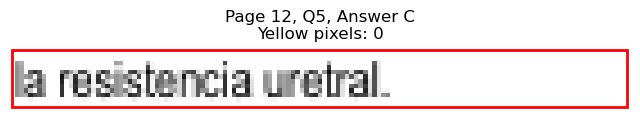

Page 12, Q5 - D: Detected box: x0=334.6, y0=413.3, x1=470.0, y1=426.0
Page 12, Q5, D: Yellow pixels: 0
Page 12, Q5, D: Total non-white pixels: 643
Page 12, Q5, D: Yellow percentage: 0.0%


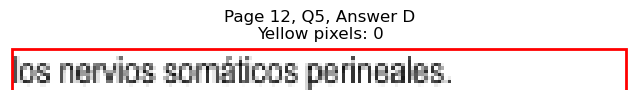

Page 12, Q5 - E: Detected box: x0=334.1, y0=425.9, x1=440.0, y1=438.6
Page 12, Q5, E: Yellow pixels: 0
Page 12, Q5, E: Total non-white pixels: 516
Page 12, Q5, E: Yellow percentage: 0.0%


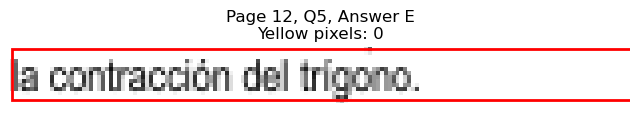


Page 12, Q5 - Selected Answer: A (based on yellow pixel count)




Page 12, Q6 - A: Detected box: x0=70.8, y0=501.7, x1=79.3, y1=514.3
Page 12, Q6, A: Yellow pixels: 0
Page 12, Q6, A: Total non-white pixels: 49
Page 12, Q6, A: Yellow percentage: 0.0%


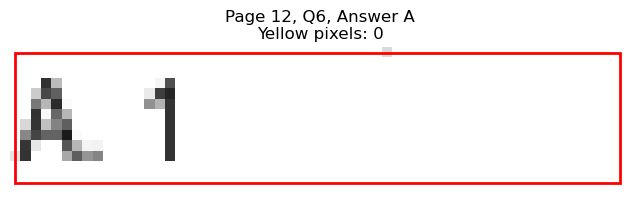

Page 12, Q6 - B: Detected box: x0=70.8, y0=514.3, x1=79.3, y1=526.9
Page 12, Q6, B: Yellow pixels: 0
Page 12, Q6, B: Total non-white pixels: 72
Page 12, Q6, B: Yellow percentage: 0.0%


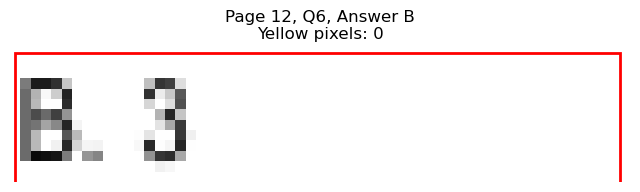

Page 12, Q6 - C: Detected box: x0=70.8, y0=526.9, x1=79.8, y1=539.5
Page 12, Q6, C: Yellow pixels: 0
Page 12, Q6, C: Total non-white pixels: 63
Page 12, Q6, C: Yellow percentage: 0.0%


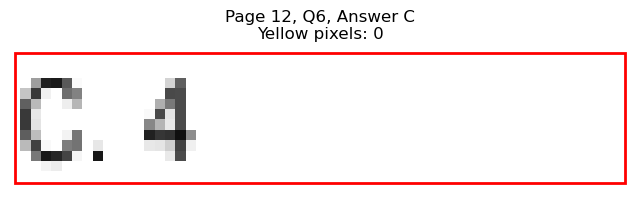

Page 12, Q6 - D: Detected box: x0=322.5, y0=501.7, x1=331.5, y1=514.3
Page 12, Q6, D: Yellow pixels: 669
Page 12, Q6, D: Total non-white pixels: 840
Page 12, Q6, D: Yellow percentage: 79.6%


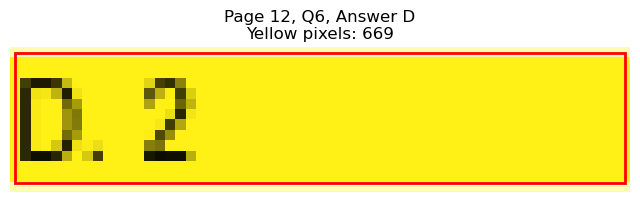

Page 12, Q6 - E: Detected box: x0=322.5, y0=514.3, x1=331.0, y1=526.9
Page 12, Q6, E: Yellow pixels: 0
Page 12, Q6, E: Total non-white pixels: 128
Page 12, Q6, E: Yellow percentage: 0.0%


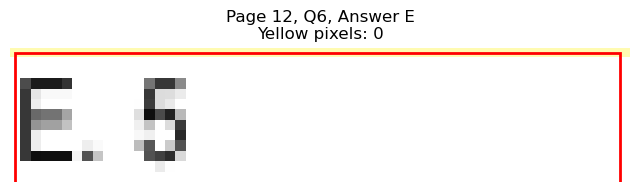


Page 12, Q6 - Selected Answer: D (based on yellow pixel count)




Page 12, Q7 - A: Detected box: x0=82.5, y0=590.0, x1=238.0, y1=602.6
Page 12, Q7, A: Yellow pixels: 0
Page 12, Q7, A: Total non-white pixels: 808
Page 12, Q7, A: Yellow percentage: 0.0%


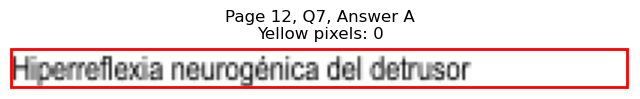

Page 12, Q7 - B: Detected box: x0=82.5, y0=602.6, x1=238.0, y1=615.2
Page 12, Q7, B: Yellow pixels: 0
Page 12, Q7, B: Total non-white pixels: 833
Page 12, Q7, B: Yellow percentage: 0.0%


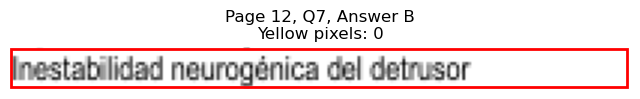

Page 12, Q7 - C: Detected box: x0=82.9, y0=615.2, x1=248.9, y1=627.8
Page 12, Q7, C: Yellow pixels: 0
Page 12, Q7, C: Total non-white pixels: 873
Page 12, Q7, C: Yellow percentage: 0.0%


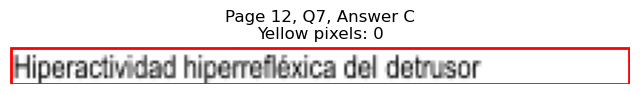

Page 12, Q7 - D: Detected box: x0=334.6, y0=590.0, x1=494.1, y1=602.6
Page 12, Q7, D: Yellow pixels: 191
Page 12, Q7, D: Total non-white pixels: 1054
Page 12, Q7, D: Yellow percentage: 18.1%


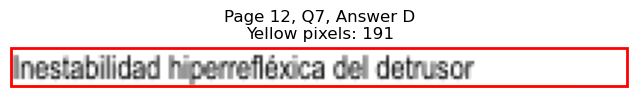

Page 12, Q7 - E: Detected box: x0=334.1, y0=602.6, x1=496.2, y1=615.2
Page 12, Q7, E: Yellow pixels: 1820
Page 12, Q7, E: Total non-white pixels: 2688
Page 12, Q7, E: Yellow percentage: 67.7%


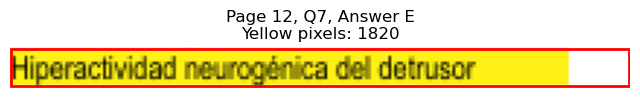


Page 12, Q7 - Selected Answer: E (based on yellow pixel count)




Page 12, Q8 - A: Detected box: x0=82.5, y0=691.1, x1=181.7, y1=703.7
Page 12, Q8, A: Yellow pixels: 0
Page 12, Q8, A: Total non-white pixels: 530
Page 12, Q8, A: Yellow percentage: 0.0%


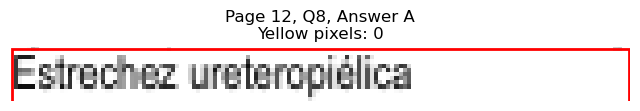

Page 12, Q8 - B: Detected box: x0=82.5, y0=703.7, x1=157.2, y1=716.3
Page 12, Q8, B: Yellow pixels: 0
Page 12, Q8, B: Total non-white pixels: 397
Page 12, Q8, B: Yellow percentage: 0.0%


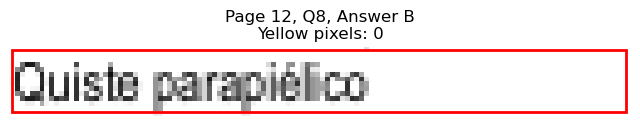

Page 12, Q8 - C: Detected box: x0=82.9, y0=716.3, x1=165.1, y1=728.9
Page 12, Q8, C: Yellow pixels: 0
Page 12, Q8, C: Total non-white pixels: 414
Page 12, Q8, C: Yellow percentage: 0.0%


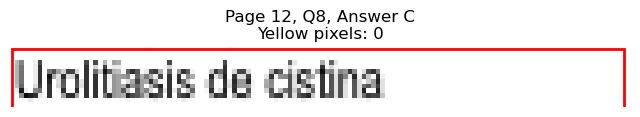

Page 12, Q8 - D: Detected box: x0=334.6, y0=691.1, x1=423.3, y1=703.7
Page 12, Q8, D: Yellow pixels: 0
Page 12, Q8, D: Total non-white pixels: 611
Page 12, Q8, D: Yellow percentage: 0.0%


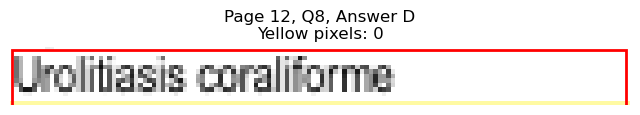

Page 12, Q8 - E: Detected box: x0=334.1, y0=703.7, x1=424.9, y1=716.3
Page 12, Q8, E: Yellow pixels: 1335
Page 12, Q8, E: Total non-white pixels: 1974
Page 12, Q8, E: Yellow percentage: 67.6%


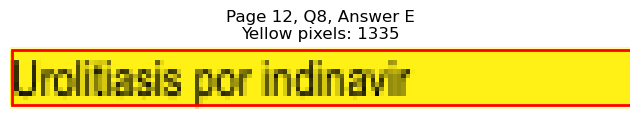


Page 12, Q8 - Selected Answer: E (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Se le interconsulta por gestante de 30 semanas...
1   ¿Cuál es la ecuación para calcular la Pdet (pr...
2   ¿Cuál de los siguientes enunciados caracteriza...
3   Es un anticolinérgico con una mayor afinidad p...
4   ¿Qué informan las estadísticas con respecto al...
..                                                ...
95  Ud. está realizando una pielolitotomía lap izq...
96  En el estudio urodinámico, la electromiografía...
97  Varón de 20 años con dolor testicular izquierd...
98  Mujer de 60 años, con Parkinson, con escape de...
99  Mujer de 30 años, VIH positivo en TARGA desde ...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                 Estenosis de unión pieloureteral   
1                               Pdet = Qmax + Pves   
2   La arteria renal derecha nace por debajo de la   
3                                       Mirabregon   
4    Los niveles de testosterona en hombres suelen   
..                                             ...   
95                           Esclerosis glomerular   
96                   la función muscular perineal.   
97                                               1   
98          Hiperreflexia neurogénica del detrusor   
99                        Estrechez ureteropiélica   

                                         option_B  \
0               Estenosis de unión ureterovesical   
1                              Pdet = Pves - Pabd   
2   La vena renal izquierda pasa por debajo de la   
3                                     Tolterodina   
4       Solo un 10% de los embarazos concluyen de   
..                                            ...   
95                    Glomerulonefritis mesangial   
96                           el músculo detrusor.   
97                                              3   
98         Inestabilidad neurogénica del detrusor   
99                             Quiste parapiélico   

                                             option_C  \
0                    Megauréter congénito obstructivo   
1                                  Pdet = Pabd + Pves   
2    La arteria renal izquierda pasa por encima de la   
3                                         Tamsulosina   
4   Por lo general se restaura la fertilidad tanto en   
..                                                ...   
95                             Atrofia tubular distal   
96                            la resistencia uretral.   
97                                                  4   
98         Hiperactividad hiperrefléxica del detrusor   
99                             Urolitiasis de cistina   

                                       option_D  \
0                Válvulas uretrales posteriores   
1                            Pdet = Pabd - Qmax   
2   La vena renal derecha nace por encima de la   
3                                     Flavoxato   
4   Las anormalidades congénitas son frecuentes   
..                                          ...   
95                     Hialinización glomerular   
96            los nervios somáticos perineales.   
97                                            2   
98    Inestabilidad hiperrefléxica del detrusor   
99                      Urolitiasis coraliforme   

                                            option_E  
0                      Reflujo vesicoureteral severo  
1                                 Pdet = Pabd - Pves  
2        La vena renal derecha nace por debajo de la  
3                                       Solifenacina  
4   Se presenta retraso del crecimiento intrauterino  
..                                               ...  
95                            Necrosis tubular aguda  
96                       la contracción del trígono.  
97                                                 5  
98           Hiperactividad neurogénica del detrusor  
99                         Urolitiasis por indinavir  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               D
1               B
2               A
3               E
4               C
..            ...
95              E
96              A
97              D
98              E
99              E

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Se le interconsulta por gestante de 30 semanas...   
1   ¿Cuál es la ecuación para calcular la Pdet (pr...   
2   ¿Cuál de los siguientes enunciados caracteriza...   
3   Es un anticolinérgico con una mayor afinidad p...   
4   ¿Qué informan las estadísticas con respecto al...   
..                                                ...   
95  Ud. está realizando una pielolitotomía lap izq...   
96  En el estudio urodinámico, la electromiografía...   
97  Varón de 20 años con dolor testicular izquierd...   
98  Mujer de 60 años, con Parkinson, con escape de...   
99  Mujer de 30 años, VIH positivo en TARGA desde ...   

                                          option_A  \
0                 Estenosis de unión pieloureteral   
1                               Pdet = Qmax + Pves   
2   La arteria renal derecha nace por debajo de la   
3                                       Mirabregon   
4    Los niveles de testosterona en hombres suelen   
..                                             ...   
95                           Esclerosis glomerular   
96                   la función muscular perineal.   
97                                               1   
98          Hiperreflexia neurogénica del detrusor   
99                        Estrechez ureteropiélica   

                                         option_B  \
0               Estenosis de unión ureterovesical   
1                              Pdet = Pves - Pabd   
2   La vena renal izquierda pasa por debajo de la   
3                                     Tolterodina   
4       Solo un 10% de los embarazos concluyen de   
..                                            ...   
95                    Glomerulonefritis mesangial   
96                           el músculo detrusor.   
97                                              3   
98         Inestabilidad neurogénica del detrusor   
99                             Quiste parapiélico   

                                             option_C  \
0                    Megauréter congénito obstructivo   
1                                  Pdet = Pabd + Pves   
2    La arteria renal izquierda pasa por encima de la   
3                                         Tamsulosina   
4   Por lo general se restaura la fertilidad tanto en   
..                                                ...   
95                             Atrofia tubular distal   
96                            la resistencia uretral.   
97                                                  4   
98         Hiperactividad hiperrefléxica del detrusor   
99                             Urolitiasis de cistina   

                                       option_D  \
0                Válvulas uretrales posteriores   
1                            Pdet = Pabd - Qmax   
2   La vena renal derecha nace por encima de la   
3                                     Flavoxato   
4   Las anormalidades congénitas son frecuentes   
..                                          ...   
95                     Hialinización glomerular   
96            los nervios somáticos perineales.   
97                                            2   
98    Inestabilidad hiperrefléxica del detrusor   
99                      Urolitiasis coraliforme   

                                            option_E correct_answer  
0                      Reflujo vesicoureteral severo              D  
1                                 Pdet = Pabd - Pves              B  
2        La vena renal derecha nace por debajo de la              A  
3                                       Solifenacina              E  
4   Se presenta retraso del crecimiento intrauterino              C  
..                                               ...            ...  
95                            Necrosis tubular aguda              E  
96                       la contracción del trígono.              A  
97                                                 5              D  
98           Hiperactividad neurogénica del detrusor              E  
99   

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/UROLOGIA.csv
